In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

### Preprocess the data

In [2]:
df = pd.read_csv("dataset_cifar10_v1.csv")

In [3]:
map = {"A":1.0,"B":2.0,"C":3.0,"D":4.0}

In [4]:
df.dtypes

out_channel0            int64
M                       int64
R1                      int64
R2                      int64
R3                      int64
R4                      int64
R5                      int64
convblock1             object
widenfact1              int64
B1                      int64
convblock2             object
widenfact2              int64
B2                      int64
convblock3             object
widenfact3              int64
B3                      int64
convblock4             object
widenfact4              int64
B4                      int64
convblock5             object
widenfact5              int64
B5                      int64
1_day_accuracy        float64
1_day_accuracy_std    float64
AVM                   float64
dtype: object

In [5]:
for column, dtype in df.dtypes.items():
    if dtype == 'object':
        df[column] = df[column].replace(map).astype('float32')

df = df.astype({col: 'float32' for col in df.select_dtypes('int64').columns})

df.dtypes

out_channel0          float32
M                     float32
R1                    float32
R2                    float32
R3                    float32
R4                    float32
R5                    float32
convblock1            float32
widenfact1            float32
B1                    float32
convblock2            float32
widenfact2            float32
B2                    float32
convblock3            float32
widenfact3            float32
B3                    float32
convblock4            float32
widenfact4            float32
B4                    float32
convblock5            float32
widenfact5            float32
B5                    float32
1_day_accuracy        float64
1_day_accuracy_std    float64
AVM                   float64
dtype: object

In [6]:
df.head()

,out_channel0,M,R1,R2,R3,R4,R5,convblock1,widenfact1,B1,...,B3,convblock4,widenfact4,B4,convblock5,widenfact5,B5,1_day_accuracy,1_day_accuracy_std,AVM
0,117.0,1.0,9.0,0.0,0.0,0.0,0.0,2.0,4.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.923597,0.057017,7.955268
1,122.0,1.0,3.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.922466,0.047991,7.772549
2,102.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.876552,0.110986,17.926130
3,32.0,3.0,3.0,1.0,7.0,0.0,0.0,2.0,2.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.658484,0.166616,15.336960
4,38.0,3.0,8.0,4.0,11.0,0.0,0.0,4.0,1.0,12.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.874308,0.192419,12.943313


In [7]:
data = df.iloc[:,:-3]
data.head()

,out_channel0,M,R1,R2,R3,R4,R5,convblock1,widenfact1,B1,...,B2,convblock3,widenfact3,B3,convblock4,widenfact4,B4,convblock5,widenfact5,B5
0,117.0,1.0,9.0,0.0,0.0,0.0,0.0,2.0,4.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,122.0,1.0,3.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,102.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,32.0,3.0,3.0,1.0,7.0,0.0,0.0,2.0,2.0,5.0,...,9.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.0,3.0,8.0,4.0,11.0,0.0,0.0,4.0,1.0,12.0,...,6.0,4.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data = torch.tensor(data[data.columns].values,dtype=torch.float32)

In [9]:
data.shape

torch.Size([1200, 22])

In [10]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In [11]:
class VQVAE_Dataset(Dataset):
  def __init__(self,data):
    self.data = data

  def __getitem__(self,idx):
    return self.data[idx]

  def __len__(self):
    return len(self.data)

In [12]:
class Encoder(nn.Module):
  def __init__(self,inp_dim,embed_dim=10,dropout=0.2):
    super(Encoder,self).__init__()
    self.inp_dim = inp_dim
    self.embed_dim = embed_dim
    self.fc1 = nn.Linear(self.inp_dim,16)
    self.fc2 = nn.Linear(16,self.embed_dim)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)

  def forward(self,x):
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.relu(self.fc2(x))
    return x

class Decoder(nn.Module):
  def __init__(self,out_dim,embed_dim=10,dropout=0.2):
    super(Decoder,self).__init__()
    self.out_dim = out_dim
    self.embed_dim = embed_dim
    self.fc1 = nn.Linear(self.embed_dim,16)
    self.fc2 = nn.Linear(16,self.out_dim)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)

  def forward(self,x):
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.relu(self.fc2(x))
    return x

class VectorQuantizer(nn.Module):
  def __init__(self,num_embeddings=50,embedding_dim=10,commitment_cost=0.25):
    super(VectorQuantizer,self).__init__()
    self.num_embeddings = num_embeddings
    self.embed_dim = embedding_dim
    self.embeddings = nn.Embedding(self.num_embeddings,self.embed_dim)
    self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
    self.commitment_cost = commitment_cost

  def forward(self,x):
    # x: [B,D]
    # embeddings: [num_embeddings, embed_dim]

    latent_vectors = x.unsqueeze(1) # [B,D] -> [B,1,D]
    codebook_vectors = self.embeddings.weight.unsqueeze(0) # [num_embeddings, embed_dim] -> [1,num_embeddings, embed_dim]
    distances = torch.norm(latent_vectors - codebook_vectors, dim=2) # [B,num_embeddings]
    closest_indices = torch.argmin(distances,dim=1).unsqueeze(1)

    # making a one hot encoder of the closest codebook chosen for perplexity calculation [B,num_embeddings]
    encodings = torch.zeros(closest_indices.shape[0], self.num_embeddings, device=x.device)
    encodings.scatter_(1,closest_indices,1)

    quantized = self.embeddings(closest_indices).squeeze(1)

    e_latent_loss = F.mse_loss(quantized.detach(), x)
    q_latent_loss = F.mse_loss(quantized, x.detach())
    loss = q_latent_loss + self.commitment_cost * e_latent_loss

    # to copy gradients from decoder to encoder
    quantized = x + (quantized - x).detach()

    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

    return loss, quantized, perplexity


In [13]:
class VQVAE(nn.Module):
  def __init__(self,x_dim,embed_dim=10,dropout=0.2,num_embeddings=50,commitment_cost=0.25):
    super(VQVAE,self).__init__()
    self.encoder = Encoder(x_dim,embed_dim,dropout)
    self.quantizer = VectorQuantizer(num_embeddings,embed_dim,commitment_cost)
    self.decoder = Decoder(x_dim,embed_dim,dropout)

  def forward(self,x):
    z = self.encoder(x)
    loss, quantized_z, perplexity = self.quantizer(z)
    x_recon = self.decoder(quantized_z)
    return loss, x_recon, perplexity

In [14]:
dataset = VQVAE_Dataset(data)

In [30]:
x_dim = data.shape[1]
embed_dim = 10
dropout = 0.2
num_embeddings = 50
commitment_cost = 0.25
epochs = 1000
learning_rate = 0.001
batch_size = 32

In [16]:
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [17]:
model = VQVAE(x_dim,embed_dim,dropout,num_embeddings,commitment_cost).to(device)

In [18]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [35]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for epoch in tqdm(range(epochs)):

  for i, batch in enumerate(train_loader):  # Iterate over all batches in the dataset
    batch = batch.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(batch)
    recon_error = F.mse_loss(data_recon, batch)
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 10 == 0:
      print('%d iterations of epochs %d/%d' % (i+1,epoch + 1, epochs))
      print('Average recon_error: %.3f' % np.mean(train_res_recon_error[-10:]))
      print('Average perplexity: %.3f' % np.mean(train_res_perplexity[-10:]))
      print()


  0%|          | 1/1000 [00:00<01:51,  8.97it/s]

10 iterations of epochs 1/1000
Average recon_error: 16.401
Average perplexity: 10.961

20 iterations of epochs 1/1000
Average recon_error: 15.868
Average perplexity: 10.489

30 iterations of epochs 1/1000
Average recon_error: 18.371
Average perplexity: 11.478

10 iterations of epochs 2/1000
Average recon_error: 16.792
Average perplexity: 11.539

20 iterations of epochs 2/1000
Average recon_error: 17.045
Average perplexity: 11.049

30 iterations of epochs 2/1000
Average recon_error: 17.532
Average perplexity: 10.321



  0%|          | 3/1000 [00:00<01:59,  8.35it/s]

10 iterations of epochs 3/1000
Average recon_error: 17.291
Average perplexity: 10.858

20 iterations of epochs 3/1000
Average recon_error: 17.992
Average perplexity: 10.838

30 iterations of epochs 3/1000
Average recon_error: 17.462
Average perplexity: 11.348

10 iterations of epochs 4/1000
Average recon_error: 18.502
Average perplexity: 11.272

20 iterations of epochs 4/1000
Average recon_error: 17.138
Average perplexity: 11.149

30 iterations of epochs 4/1000
Average recon_error: 18.485
Average perplexity: 10.764



  0%|          | 5/1000 [00:00<02:05,  7.95it/s]

10 iterations of epochs 5/1000
Average recon_error: 16.708
Average perplexity: 11.185

20 iterations of epochs 5/1000
Average recon_error: 18.019
Average perplexity: 11.015

30 iterations of epochs 5/1000
Average recon_error: 18.043
Average perplexity: 11.005

10 iterations of epochs 6/1000
Average recon_error: 17.068
Average perplexity: 11.372

20 iterations of epochs 6/1000
Average recon_error: 18.470
Average perplexity: 11.677

30 iterations of epochs 6/1000
Average recon_error: 16.768
Average perplexity: 10.593



  1%|          | 7/1000 [00:00<02:04,  7.96it/s]

10 iterations of epochs 7/1000
Average recon_error: 16.535
Average perplexity: 11.164

20 iterations of epochs 7/1000
Average recon_error: 19.080
Average perplexity: 11.387

30 iterations of epochs 7/1000
Average recon_error: 16.760
Average perplexity: 10.514

10 iterations of epochs 8/1000
Average recon_error: 16.807
Average perplexity: 11.905

20 iterations of epochs 8/1000
Average recon_error: 16.279
Average perplexity: 10.962

30 iterations of epochs 8/1000
Average recon_error: 18.080
Average perplexity: 11.464



  1%|          | 9/1000 [00:01<02:02,  8.09it/s]

10 iterations of epochs 9/1000
Average recon_error: 17.969
Average perplexity: 11.130

20 iterations of epochs 9/1000
Average recon_error: 16.722
Average perplexity: 11.636

30 iterations of epochs 9/1000
Average recon_error: 17.173
Average perplexity: 12.372

10 iterations of epochs 10/1000
Average recon_error: 16.955
Average perplexity: 11.364

20 iterations of epochs 10/1000
Average recon_error: 17.986
Average perplexity: 11.469

30 iterations of epochs 10/1000
Average recon_error: 18.419
Average perplexity: 11.276



  1%|          | 11/1000 [00:01<02:01,  8.12it/s]

10 iterations of epochs 11/1000
Average recon_error: 17.750
Average perplexity: 11.223

20 iterations of epochs 11/1000
Average recon_error: 16.501
Average perplexity: 11.711

30 iterations of epochs 11/1000
Average recon_error: 15.810
Average perplexity: 10.595

10 iterations of epochs 12/1000
Average recon_error: 19.424
Average perplexity: 10.886

20 iterations of epochs 12/1000
Average recon_error: 16.860
Average perplexity: 11.580

30 iterations of epochs 12/1000
Average recon_error: 17.844
Average perplexity: 10.889



  1%|▏         | 13/1000 [00:01<02:01,  8.10it/s]

10 iterations of epochs 13/1000
Average recon_error: 17.147
Average perplexity: 10.917

20 iterations of epochs 13/1000
Average recon_error: 16.868
Average perplexity: 10.880

30 iterations of epochs 13/1000
Average recon_error: 17.739
Average perplexity: 11.534

10 iterations of epochs 14/1000
Average recon_error: 19.797
Average perplexity: 11.171

20 iterations of epochs 14/1000
Average recon_error: 16.376
Average perplexity: 12.274

30 iterations of epochs 14/1000
Average recon_error: 15.947
Average perplexity: 10.496



  2%|▏         | 15/1000 [00:01<02:00,  8.14it/s]

10 iterations of epochs 15/1000
Average recon_error: 18.463
Average perplexity: 11.631

20 iterations of epochs 15/1000
Average recon_error: 17.934
Average perplexity: 11.241

30 iterations of epochs 15/1000
Average recon_error: 18.131
Average perplexity: 11.151

10 iterations of epochs 16/1000
Average recon_error: 17.959
Average perplexity: 11.485

20 iterations of epochs 16/1000
Average recon_error: 16.336
Average perplexity: 10.520

30 iterations of epochs 16/1000
Average recon_error: 17.266
Average perplexity: 11.232



  2%|▏         | 17/1000 [00:02<01:58,  8.29it/s]

10 iterations of epochs 17/1000
Average recon_error: 17.225
Average perplexity: 10.827

20 iterations of epochs 17/1000
Average recon_error: 16.926
Average perplexity: 11.278

30 iterations of epochs 17/1000
Average recon_error: 16.641
Average perplexity: 11.103

10 iterations of epochs 18/1000
Average recon_error: 17.327
Average perplexity: 11.468

20 iterations of epochs 18/1000
Average recon_error: 16.872
Average perplexity: 11.758

30 iterations of epochs 18/1000
Average recon_error: 17.303
Average perplexity: 12.081



  2%|▏         | 19/1000 [00:02<02:00,  8.11it/s]

10 iterations of epochs 19/1000
Average recon_error: 15.709
Average perplexity: 10.256

20 iterations of epochs 19/1000
Average recon_error: 16.117
Average perplexity: 10.416

30 iterations of epochs 19/1000
Average recon_error: 16.931
Average perplexity: 12.075

10 iterations of epochs 20/1000
Average recon_error: 18.469
Average perplexity: 11.513

20 iterations of epochs 20/1000
Average recon_error: 18.957
Average perplexity: 11.260

30 iterations of epochs 20/1000
Average recon_error: 16.481
Average perplexity: 11.829



  2%|▏         | 21/1000 [00:02<02:03,  7.96it/s]

10 iterations of epochs 21/1000
Average recon_error: 18.310
Average perplexity: 11.068

20 iterations of epochs 21/1000
Average recon_error: 16.040
Average perplexity: 11.354

30 iterations of epochs 21/1000
Average recon_error: 16.331
Average perplexity: 11.489

10 iterations of epochs 22/1000
Average recon_error: 17.867
Average perplexity: 11.301

20 iterations of epochs 22/1000
Average recon_error: 18.755
Average perplexity: 11.191

30 iterations of epochs 22/1000
Average recon_error: 17.813
Average perplexity: 11.156



  2%|▏         | 23/1000 [00:02<02:01,  8.05it/s]

10 iterations of epochs 23/1000
Average recon_error: 17.434
Average perplexity: 10.948

20 iterations of epochs 23/1000
Average recon_error: 17.127
Average perplexity: 10.798

30 iterations of epochs 23/1000
Average recon_error: 16.030
Average perplexity: 11.265

10 iterations of epochs 24/1000
Average recon_error: 18.750
Average perplexity: 10.442

20 iterations of epochs 24/1000
Average recon_error: 16.482
Average perplexity: 11.568

30 iterations of epochs 24/1000
Average recon_error: 17.576
Average perplexity: 10.826



  2%|▎         | 25/1000 [00:03<01:59,  8.13it/s]

10 iterations of epochs 25/1000
Average recon_error: 18.399
Average perplexity: 11.088

20 iterations of epochs 25/1000
Average recon_error: 17.193
Average perplexity: 11.369

30 iterations of epochs 25/1000
Average recon_error: 16.252
Average perplexity: 10.658

10 iterations of epochs 26/1000
Average recon_error: 16.260
Average perplexity: 11.287

20 iterations of epochs 26/1000
Average recon_error: 20.184
Average perplexity: 11.594

30 iterations of epochs 26/1000
Average recon_error: 18.068
Average perplexity: 11.073



  3%|▎         | 28/1000 [00:03<01:56,  8.37it/s]

10 iterations of epochs 27/1000
Average recon_error: 15.441
Average perplexity: 10.575

20 iterations of epochs 27/1000
Average recon_error: 18.200
Average perplexity: 11.842

30 iterations of epochs 27/1000
Average recon_error: 19.351
Average perplexity: 11.264

10 iterations of epochs 28/1000
Average recon_error: 16.552
Average perplexity: 12.418

20 iterations of epochs 28/1000
Average recon_error: 18.794
Average perplexity: 10.406

30 iterations of epochs 28/1000
Average recon_error: 16.274
Average perplexity: 11.902



  3%|▎         | 29/1000 [00:03<01:58,  8.21it/s]

10 iterations of epochs 29/1000
Average recon_error: 18.175
Average perplexity: 11.363

20 iterations of epochs 29/1000
Average recon_error: 16.937
Average perplexity: 10.816

30 iterations of epochs 29/1000
Average recon_error: 18.218
Average perplexity: 11.887

10 iterations of epochs 30/1000
Average recon_error: 18.093
Average perplexity: 11.616

20 iterations of epochs 30/1000
Average recon_error: 17.195
Average perplexity: 10.675

30 iterations of epochs 30/1000
Average recon_error: 17.514
Average perplexity: 11.041



  3%|▎         | 31/1000 [00:03<01:57,  8.26it/s]

10 iterations of epochs 31/1000
Average recon_error: 19.113
Average perplexity: 10.278

20 iterations of epochs 31/1000
Average recon_error: 16.481
Average perplexity: 11.415

30 iterations of epochs 31/1000
Average recon_error: 15.973
Average perplexity: 11.562

10 iterations of epochs 32/1000
Average recon_error: 17.703
Average perplexity: 10.989

20 iterations of epochs 32/1000
Average recon_error: 16.149
Average perplexity: 11.024

30 iterations of epochs 32/1000
Average recon_error: 17.495
Average perplexity: 11.443



  3%|▎         | 33/1000 [00:04<01:56,  8.28it/s]

10 iterations of epochs 33/1000
Average recon_error: 16.334
Average perplexity: 11.770

20 iterations of epochs 33/1000
Average recon_error: 17.804
Average perplexity: 11.086

30 iterations of epochs 33/1000
Average recon_error: 18.170
Average perplexity: 10.751

10 iterations of epochs 34/1000
Average recon_error: 16.595
Average perplexity: 11.045

20 iterations of epochs 34/1000
Average recon_error: 17.333
Average perplexity: 11.678

30 iterations of epochs 34/1000
Average recon_error: 16.795
Average perplexity: 10.429



  4%|▎         | 35/1000 [00:04<01:57,  8.21it/s]

10 iterations of epochs 35/1000
Average recon_error: 16.982
Average perplexity: 10.363

20 iterations of epochs 35/1000
Average recon_error: 18.510
Average perplexity: 11.724

30 iterations of epochs 35/1000
Average recon_error: 17.677
Average perplexity: 11.153

10 iterations of epochs 36/1000
Average recon_error: 17.242
Average perplexity: 11.546

20 iterations of epochs 36/1000
Average recon_error: 16.159
Average perplexity: 10.629

30 iterations of epochs 36/1000
Average recon_error: 19.988
Average perplexity: 11.572



  4%|▎         | 37/1000 [00:04<02:01,  7.93it/s]

10 iterations of epochs 37/1000
Average recon_error: 17.058
Average perplexity: 11.102

20 iterations of epochs 37/1000
Average recon_error: 18.790
Average perplexity: 10.415

30 iterations of epochs 37/1000
Average recon_error: 17.276
Average perplexity: 10.934

10 iterations of epochs 38/1000
Average recon_error: 18.422
Average perplexity: 11.488

20 iterations of epochs 38/1000
Average recon_error: 18.881
Average perplexity: 11.148

30 iterations of epochs 38/1000
Average recon_error: 16.624
Average perplexity: 10.878



  4%|▍         | 39/1000 [00:04<02:02,  7.87it/s]

10 iterations of epochs 39/1000
Average recon_error: 17.987
Average perplexity: 11.511

20 iterations of epochs 39/1000
Average recon_error: 15.432
Average perplexity: 11.361

30 iterations of epochs 39/1000
Average recon_error: 16.062
Average perplexity: 12.055

10 iterations of epochs 40/1000
Average recon_error: 17.651
Average perplexity: 10.746

20 iterations of epochs 40/1000
Average recon_error: 17.169
Average perplexity: 11.047

30 iterations of epochs 40/1000
Average recon_error: 17.214
Average perplexity: 12.463



  4%|▍         | 41/1000 [00:05<02:00,  7.98it/s]

10 iterations of epochs 41/1000
Average recon_error: 17.879
Average perplexity: 11.781

20 iterations of epochs 41/1000
Average recon_error: 16.524
Average perplexity: 11.117

30 iterations of epochs 41/1000
Average recon_error: 16.670
Average perplexity: 11.414

10 iterations of epochs 42/1000
Average recon_error: 17.213
Average perplexity: 10.885

20 iterations of epochs 42/1000
Average recon_error: 15.464
Average perplexity: 11.347

30 iterations of epochs 42/1000
Average recon_error: 18.695
Average perplexity: 11.827



  4%|▍         | 43/1000 [00:05<02:04,  7.71it/s]

10 iterations of epochs 43/1000
Average recon_error: 16.109
Average perplexity: 10.714

20 iterations of epochs 43/1000
Average recon_error: 17.116
Average perplexity: 10.895

30 iterations of epochs 43/1000
Average recon_error: 17.222
Average perplexity: 10.630

10 iterations of epochs 44/1000
Average recon_error: 17.847
Average perplexity: 11.515

20 iterations of epochs 44/1000
Average recon_error: 16.257
Average perplexity: 10.868

30 iterations of epochs 44/1000
Average recon_error: 16.965
Average perplexity: 10.855



  4%|▍         | 45/1000 [00:05<02:06,  7.56it/s]

10 iterations of epochs 45/1000
Average recon_error: 15.303
Average perplexity: 11.312

20 iterations of epochs 45/1000
Average recon_error: 19.343
Average perplexity: 10.623

30 iterations of epochs 45/1000
Average recon_error: 17.178
Average perplexity: 11.637

10 iterations of epochs 46/1000
Average recon_error: 17.919
Average perplexity: 11.244

20 iterations of epochs 46/1000
Average recon_error: 17.774
Average perplexity: 10.906



  5%|▍         | 47/1000 [00:05<02:05,  7.61it/s]

30 iterations of epochs 46/1000
Average recon_error: 17.513
Average perplexity: 10.424

10 iterations of epochs 47/1000
Average recon_error: 18.950
Average perplexity: 11.126

20 iterations of epochs 47/1000
Average recon_error: 17.964
Average perplexity: 10.861

30 iterations of epochs 47/1000
Average recon_error: 18.204
Average perplexity: 10.553

10 iterations of epochs 48/1000
Average recon_error: 17.989
Average perplexity: 11.328



  5%|▍         | 49/1000 [00:06<01:59,  7.99it/s]

20 iterations of epochs 48/1000
Average recon_error: 17.759
Average perplexity: 10.882

30 iterations of epochs 48/1000
Average recon_error: 16.778
Average perplexity: 10.846

10 iterations of epochs 49/1000
Average recon_error: 18.436
Average perplexity: 10.907

20 iterations of epochs 49/1000
Average recon_error: 16.068
Average perplexity: 11.240

30 iterations of epochs 49/1000
Average recon_error: 16.444
Average perplexity: 11.489



  5%|▌         | 50/1000 [00:06<01:59,  7.95it/s]

10 iterations of epochs 50/1000
Average recon_error: 17.701
Average perplexity: 11.933

20 iterations of epochs 50/1000
Average recon_error: 17.422
Average perplexity: 10.730

30 iterations of epochs 50/1000
Average recon_error: 15.565
Average perplexity: 11.058

10 iterations of epochs 51/1000
Average recon_error: 16.615
Average perplexity: 10.934

20 iterations of epochs 51/1000
Average recon_error: 17.813
Average perplexity: 10.551

30 iterations of epochs 51/1000
Average recon_error: 18.499
Average perplexity: 11.994



  5%|▌         | 52/1000 [00:06<01:56,  8.13it/s]

10 iterations of epochs 52/1000
Average recon_error: 16.881
Average perplexity: 11.771

20 iterations of epochs 52/1000
Average recon_error: 17.310
Average perplexity: 11.526

30 iterations of epochs 52/1000
Average recon_error: 17.162
Average perplexity: 11.460

10 iterations of epochs 53/1000
Average recon_error: 17.904
Average perplexity: 11.251

20 iterations of epochs 53/1000
Average recon_error: 17.669
Average perplexity: 11.255

30 iterations of epochs 53/1000
Average recon_error: 17.567
Average perplexity: 11.080



  5%|▌         | 54/1000 [00:06<01:58,  7.99it/s]

10 iterations of epochs 54/1000
Average recon_error: 15.863
Average perplexity: 11.056

20 iterations of epochs 54/1000
Average recon_error: 17.143
Average perplexity: 11.465

30 iterations of epochs 54/1000
Average recon_error: 19.002
Average perplexity: 11.211

10 iterations of epochs 55/1000
Average recon_error: 17.964
Average perplexity: 11.267

20 iterations of epochs 55/1000
Average recon_error: 18.689
Average perplexity: 11.557

30 iterations of epochs 55/1000
Average recon_error: 17.697
Average perplexity: 11.494



  6%|▌         | 56/1000 [00:06<01:56,  8.08it/s]

10 iterations of epochs 56/1000
Average recon_error: 17.144
Average perplexity: 11.890

20 iterations of epochs 56/1000
Average recon_error: 16.564
Average perplexity: 11.456

30 iterations of epochs 56/1000
Average recon_error: 18.136
Average perplexity: 11.128

10 iterations of epochs 57/1000
Average recon_error: 17.196
Average perplexity: 10.976

20 iterations of epochs 57/1000
Average recon_error: 17.097
Average perplexity: 11.651

30 iterations of epochs 57/1000
Average recon_error: 18.530
Average perplexity: 11.817



  6%|▌         | 58/1000 [00:07<01:53,  8.27it/s]

10 iterations of epochs 58/1000
Average recon_error: 17.939
Average perplexity: 11.045

20 iterations of epochs 58/1000
Average recon_error: 17.681
Average perplexity: 10.264

30 iterations of epochs 58/1000
Average recon_error: 17.198
Average perplexity: 11.169

10 iterations of epochs 59/1000
Average recon_error: 18.201
Average perplexity: 11.993

20 iterations of epochs 59/1000
Average recon_error: 18.119
Average perplexity: 11.471

30 iterations of epochs 59/1000
Average recon_error: 18.210
Average perplexity: 11.903



  6%|▌         | 60/1000 [00:07<01:56,  8.07it/s]

10 iterations of epochs 60/1000
Average recon_error: 17.904
Average perplexity: 10.856

20 iterations of epochs 60/1000
Average recon_error: 17.647
Average perplexity: 10.424

30 iterations of epochs 60/1000
Average recon_error: 18.801
Average perplexity: 11.110

10 iterations of epochs 61/1000
Average recon_error: 16.947
Average perplexity: 11.752

20 iterations of epochs 61/1000
Average recon_error: 15.950
Average perplexity: 11.680

30 iterations of epochs 61/1000
Average recon_error: 16.440
Average perplexity: 11.737



  6%|▌         | 62/1000 [00:07<02:00,  7.81it/s]

10 iterations of epochs 62/1000
Average recon_error: 17.448
Average perplexity: 10.747

20 iterations of epochs 62/1000
Average recon_error: 18.441
Average perplexity: 11.086

30 iterations of epochs 62/1000
Average recon_error: 16.874
Average perplexity: 11.775

10 iterations of epochs 63/1000
Average recon_error: 16.819
Average perplexity: 11.437

20 iterations of epochs 63/1000
Average recon_error: 16.011
Average perplexity: 11.492

30 iterations of epochs 63/1000
Average recon_error: 16.983
Average perplexity: 11.404



  6%|▋         | 64/1000 [00:07<01:58,  7.88it/s]

10 iterations of epochs 64/1000
Average recon_error: 16.600
Average perplexity: 10.901

20 iterations of epochs 64/1000
Average recon_error: 17.383
Average perplexity: 11.290

30 iterations of epochs 64/1000
Average recon_error: 18.061
Average perplexity: 11.093

10 iterations of epochs 65/1000
Average recon_error: 15.607
Average perplexity: 11.725

20 iterations of epochs 65/1000
Average recon_error: 17.143
Average perplexity: 11.168

30 iterations of epochs 65/1000
Average recon_error: 18.365
Average perplexity: 11.087



  7%|▋         | 66/1000 [00:08<01:57,  7.93it/s]

10 iterations of epochs 66/1000
Average recon_error: 16.607
Average perplexity: 10.536

20 iterations of epochs 66/1000
Average recon_error: 16.763
Average perplexity: 11.629

30 iterations of epochs 66/1000
Average recon_error: 17.951
Average perplexity: 10.690

10 iterations of epochs 67/1000
Average recon_error: 16.606
Average perplexity: 11.249

20 iterations of epochs 67/1000
Average recon_error: 16.139
Average perplexity: 11.268

30 iterations of epochs 67/1000
Average recon_error: 18.105
Average perplexity: 10.555



  7%|▋         | 68/1000 [00:08<01:57,  7.94it/s]

10 iterations of epochs 68/1000
Average recon_error: 16.341
Average perplexity: 11.044

20 iterations of epochs 68/1000
Average recon_error: 16.855
Average perplexity: 11.620

30 iterations of epochs 68/1000
Average recon_error: 17.315
Average perplexity: 10.988

10 iterations of epochs 69/1000
Average recon_error: 17.746
Average perplexity: 10.393

20 iterations of epochs 69/1000
Average recon_error: 17.957
Average perplexity: 11.007

30 iterations of epochs 69/1000
Average recon_error: 17.924
Average perplexity: 10.845



  7%|▋         | 70/1000 [00:08<02:18,  6.71it/s]

10 iterations of epochs 70/1000
Average recon_error: 16.580
Average perplexity: 11.651

20 iterations of epochs 70/1000
Average recon_error: 17.363
Average perplexity: 10.922

30 iterations of epochs 70/1000
Average recon_error: 15.877
Average perplexity: 11.415

10 iterations of epochs 71/1000
Average recon_error: 17.738
Average perplexity: 10.921



  7%|▋         | 71/1000 [00:08<02:24,  6.42it/s]

20 iterations of epochs 71/1000
Average recon_error: 16.735
Average perplexity: 10.382

30 iterations of epochs 71/1000
Average recon_error: 16.105
Average perplexity: 11.716

10 iterations of epochs 72/1000
Average recon_error: 17.865
Average perplexity: 10.654

20 iterations of epochs 72/1000
Average recon_error: 17.929
Average perplexity: 10.703



  7%|▋         | 72/1000 [00:09<02:29,  6.21it/s]

30 iterations of epochs 72/1000
Average recon_error: 16.719
Average perplexity: 10.818

10 iterations of epochs 73/1000
Average recon_error: 16.889
Average perplexity: 11.512

20 iterations of epochs 73/1000
Average recon_error: 16.505
Average perplexity: 11.175

30 iterations of epochs 73/1000
Average recon_error: 17.668
Average perplexity: 10.330



  7%|▋         | 74/1000 [00:09<02:32,  6.05it/s]

10 iterations of epochs 74/1000
Average recon_error: 18.920
Average perplexity: 11.763

20 iterations of epochs 74/1000
Average recon_error: 18.620
Average perplexity: 11.285

30 iterations of epochs 74/1000
Average recon_error: 17.131
Average perplexity: 10.594

10 iterations of epochs 75/1000
Average recon_error: 17.043
Average perplexity: 10.810



  8%|▊         | 75/1000 [00:09<02:34,  5.98it/s]

20 iterations of epochs 75/1000
Average recon_error: 18.167
Average perplexity: 10.562

30 iterations of epochs 75/1000
Average recon_error: 17.850
Average perplexity: 12.319

10 iterations of epochs 76/1000
Average recon_error: 16.474
Average perplexity: 11.672

20 iterations of epochs 76/1000
Average recon_error: 16.839
Average perplexity: 10.693



  8%|▊         | 77/1000 [00:10<02:36,  5.91it/s]

30 iterations of epochs 76/1000
Average recon_error: 17.503
Average perplexity: 11.725

10 iterations of epochs 77/1000
Average recon_error: 16.942
Average perplexity: 12.286

20 iterations of epochs 77/1000
Average recon_error: 18.557
Average perplexity: 12.390

30 iterations of epochs 77/1000
Average recon_error: 15.882
Average perplexity: 10.546



  8%|▊         | 78/1000 [00:10<02:37,  5.86it/s]

10 iterations of epochs 78/1000
Average recon_error: 17.881
Average perplexity: 10.929

20 iterations of epochs 78/1000
Average recon_error: 17.484
Average perplexity: 10.988

30 iterations of epochs 78/1000
Average recon_error: 16.308
Average perplexity: 11.235

10 iterations of epochs 79/1000
Average recon_error: 17.333
Average perplexity: 10.905



  8%|▊         | 79/1000 [00:10<02:38,  5.81it/s]

20 iterations of epochs 79/1000
Average recon_error: 18.706
Average perplexity: 11.976

30 iterations of epochs 79/1000
Average recon_error: 17.965
Average perplexity: 10.314

10 iterations of epochs 80/1000
Average recon_error: 16.046
Average perplexity: 10.271

20 iterations of epochs 80/1000
Average recon_error: 16.867
Average perplexity: 11.011



  8%|▊         | 80/1000 [00:10<02:39,  5.78it/s]

30 iterations of epochs 80/1000
Average recon_error: 17.949
Average perplexity: 12.212

10 iterations of epochs 81/1000
Average recon_error: 17.161
Average perplexity: 11.496

20 iterations of epochs 81/1000
Average recon_error: 18.471
Average perplexity: 10.894

30 iterations of epochs 81/1000
Average recon_error: 17.348
Average perplexity: 10.571



  8%|▊         | 82/1000 [00:10<02:47,  5.48it/s]

10 iterations of epochs 82/1000
Average recon_error: 17.208
Average perplexity: 10.951

20 iterations of epochs 82/1000
Average recon_error: 15.785
Average perplexity: 11.198

30 iterations of epochs 82/1000
Average recon_error: 18.099
Average perplexity: 11.969

10 iterations of epochs 83/1000
Average recon_error: 17.527
Average perplexity: 11.364



  8%|▊         | 83/1000 [00:11<02:47,  5.48it/s]

20 iterations of epochs 83/1000
Average recon_error: 17.665
Average perplexity: 12.256

30 iterations of epochs 83/1000
Average recon_error: 17.575
Average perplexity: 11.364

10 iterations of epochs 84/1000
Average recon_error: 17.404
Average perplexity: 10.518

20 iterations of epochs 84/1000
Average recon_error: 16.999
Average perplexity: 10.569



  8%|▊         | 85/1000 [00:11<02:24,  6.33it/s]

30 iterations of epochs 84/1000
Average recon_error: 16.936
Average perplexity: 11.551

10 iterations of epochs 85/1000
Average recon_error: 17.698
Average perplexity: 11.380

20 iterations of epochs 85/1000
Average recon_error: 16.928
Average perplexity: 11.766

30 iterations of epochs 85/1000
Average recon_error: 15.750
Average perplexity: 11.070

10 iterations of epochs 86/1000
Average recon_error: 18.589
Average perplexity: 10.342



  9%|▊         | 87/1000 [00:11<02:07,  7.14it/s]

20 iterations of epochs 86/1000
Average recon_error: 17.278
Average perplexity: 11.851

30 iterations of epochs 86/1000
Average recon_error: 17.314
Average perplexity: 11.375

10 iterations of epochs 87/1000
Average recon_error: 17.295
Average perplexity: 11.146

20 iterations of epochs 87/1000
Average recon_error: 18.576
Average perplexity: 10.533

30 iterations of epochs 87/1000
Average recon_error: 16.698
Average perplexity: 11.607



  9%|▉         | 88/1000 [00:11<02:04,  7.31it/s]

10 iterations of epochs 88/1000
Average recon_error: 18.266
Average perplexity: 10.869

20 iterations of epochs 88/1000
Average recon_error: 18.277
Average perplexity: 11.669

30 iterations of epochs 88/1000
Average recon_error: 18.406
Average perplexity: 11.278

10 iterations of epochs 89/1000
Average recon_error: 16.945
Average perplexity: 12.427

20 iterations of epochs 89/1000
Average recon_error: 16.800
Average perplexity: 11.260

30 iterations of epochs 89/1000
Average recon_error: 16.067
Average perplexity: 10.726



  9%|▉         | 90/1000 [00:12<02:00,  7.57it/s]

10 iterations of epochs 90/1000
Average recon_error: 15.669
Average perplexity: 11.106

20 iterations of epochs 90/1000
Average recon_error: 15.499
Average perplexity: 10.480

30 iterations of epochs 90/1000
Average recon_error: 17.792
Average perplexity: 10.674

10 iterations of epochs 91/1000
Average recon_error: 17.277
Average perplexity: 11.741

20 iterations of epochs 91/1000
Average recon_error: 17.390
Average perplexity: 10.989

30 iterations of epochs 91/1000
Average recon_error: 16.274
Average perplexity: 11.156



  9%|▉         | 92/1000 [00:12<01:54,  7.96it/s]

10 iterations of epochs 92/1000
Average recon_error: 17.943
Average perplexity: 11.387

20 iterations of epochs 92/1000
Average recon_error: 16.422
Average perplexity: 11.323

30 iterations of epochs 92/1000
Average recon_error: 18.620
Average perplexity: 11.279

10 iterations of epochs 93/1000
Average recon_error: 18.463
Average perplexity: 11.179

20 iterations of epochs 93/1000
Average recon_error: 18.052
Average perplexity: 11.197

30 iterations of epochs 93/1000
Average recon_error: 17.168
Average perplexity: 11.866



  9%|▉         | 94/1000 [00:12<01:52,  8.07it/s]

10 iterations of epochs 94/1000
Average recon_error: 15.534
Average perplexity: 11.356

20 iterations of epochs 94/1000
Average recon_error: 17.735
Average perplexity: 10.847

30 iterations of epochs 94/1000
Average recon_error: 16.613
Average perplexity: 11.226

10 iterations of epochs 95/1000
Average recon_error: 16.433
Average perplexity: 11.970

20 iterations of epochs 95/1000
Average recon_error: 17.658
Average perplexity: 11.373

30 iterations of epochs 95/1000
Average recon_error: 17.077
Average perplexity: 10.953



 10%|▉         | 96/1000 [00:12<01:51,  8.07it/s]

10 iterations of epochs 96/1000
Average recon_error: 17.265
Average perplexity: 10.935

20 iterations of epochs 96/1000
Average recon_error: 17.148
Average perplexity: 11.353

30 iterations of epochs 96/1000
Average recon_error: 18.935
Average perplexity: 11.730

10 iterations of epochs 97/1000
Average recon_error: 17.709
Average perplexity: 11.356

20 iterations of epochs 97/1000
Average recon_error: 16.675
Average perplexity: 11.335



 10%|▉         | 98/1000 [00:13<01:54,  7.84it/s]

30 iterations of epochs 97/1000
Average recon_error: 16.761
Average perplexity: 11.215

10 iterations of epochs 98/1000
Average recon_error: 16.505
Average perplexity: 11.256

20 iterations of epochs 98/1000
Average recon_error: 16.419
Average perplexity: 11.980

30 iterations of epochs 98/1000
Average recon_error: 16.879
Average perplexity: 10.423

10 iterations of epochs 99/1000
Average recon_error: 17.490
Average perplexity: 12.002



 10%|█         | 100/1000 [00:13<01:52,  7.96it/s]

20 iterations of epochs 99/1000
Average recon_error: 18.717
Average perplexity: 11.447

30 iterations of epochs 99/1000
Average recon_error: 16.748
Average perplexity: 11.216

10 iterations of epochs 100/1000
Average recon_error: 16.724
Average perplexity: 10.285

20 iterations of epochs 100/1000
Average recon_error: 14.899
Average perplexity: 12.306

30 iterations of epochs 100/1000
Average recon_error: 17.208
Average perplexity: 11.466



 10%|█         | 101/1000 [00:13<01:52,  8.00it/s]

10 iterations of epochs 101/1000
Average recon_error: 16.311
Average perplexity: 10.854

20 iterations of epochs 101/1000
Average recon_error: 17.395
Average perplexity: 10.384

30 iterations of epochs 101/1000
Average recon_error: 18.766
Average perplexity: 11.218

10 iterations of epochs 102/1000
Average recon_error: 16.985
Average perplexity: 10.716

20 iterations of epochs 102/1000
Average recon_error: 17.174
Average perplexity: 12.374

30 iterations of epochs 102/1000
Average recon_error: 17.192
Average perplexity: 11.285



 10%|█         | 103/1000 [00:13<01:50,  8.15it/s]

10 iterations of epochs 103/1000
Average recon_error: 15.566
Average perplexity: 11.483

20 iterations of epochs 103/1000
Average recon_error: 17.192
Average perplexity: 10.411

30 iterations of epochs 103/1000
Average recon_error: 20.393
Average perplexity: 10.927

10 iterations of epochs 104/1000
Average recon_error: 17.059
Average perplexity: 10.418

20 iterations of epochs 104/1000
Average recon_error: 18.158
Average perplexity: 11.389

30 iterations of epochs 104/1000
Average recon_error: 16.610
Average perplexity: 11.645



 10%|█         | 105/1000 [00:13<01:53,  7.91it/s]

10 iterations of epochs 105/1000
Average recon_error: 16.449
Average perplexity: 10.808

20 iterations of epochs 105/1000
Average recon_error: 17.472
Average perplexity: 11.582

30 iterations of epochs 105/1000
Average recon_error: 16.649
Average perplexity: 11.071

10 iterations of epochs 106/1000
Average recon_error: 16.544
Average perplexity: 11.660

20 iterations of epochs 106/1000
Average recon_error: 18.071
Average perplexity: 11.106

30 iterations of epochs 106/1000
Average recon_error: 16.806
Average perplexity: 11.119



 11%|█         | 107/1000 [00:14<01:51,  7.99it/s]

10 iterations of epochs 107/1000
Average recon_error: 17.072
Average perplexity: 10.936

20 iterations of epochs 107/1000
Average recon_error: 17.694
Average perplexity: 11.346

30 iterations of epochs 107/1000
Average recon_error: 17.876
Average perplexity: 11.599

10 iterations of epochs 108/1000
Average recon_error: 17.670
Average perplexity: 10.736

20 iterations of epochs 108/1000
Average recon_error: 17.318
Average perplexity: 11.982

30 iterations of epochs 108/1000
Average recon_error: 17.235
Average perplexity: 11.488



 11%|█         | 109/1000 [00:14<01:50,  8.05it/s]

10 iterations of epochs 109/1000
Average recon_error: 18.285
Average perplexity: 10.957

20 iterations of epochs 109/1000
Average recon_error: 17.459
Average perplexity: 10.935

30 iterations of epochs 109/1000
Average recon_error: 16.349
Average perplexity: 10.754

10 iterations of epochs 110/1000
Average recon_error: 16.714
Average perplexity: 11.325

20 iterations of epochs 110/1000
Average recon_error: 16.738
Average perplexity: 12.182

30 iterations of epochs 110/1000
Average recon_error: 17.532
Average perplexity: 10.957



 11%|█         | 111/1000 [00:14<01:48,  8.18it/s]

10 iterations of epochs 111/1000
Average recon_error: 16.993
Average perplexity: 11.470

20 iterations of epochs 111/1000
Average recon_error: 17.754
Average perplexity: 12.127

30 iterations of epochs 111/1000
Average recon_error: 16.811
Average perplexity: 12.368

10 iterations of epochs 112/1000
Average recon_error: 16.285
Average perplexity: 11.326

20 iterations of epochs 112/1000
Average recon_error: 17.415
Average perplexity: 11.053

30 iterations of epochs 112/1000
Average recon_error: 18.690
Average perplexity: 11.435



 11%|█▏        | 113/1000 [00:14<01:49,  8.07it/s]

10 iterations of epochs 113/1000
Average recon_error: 16.428
Average perplexity: 10.386

20 iterations of epochs 113/1000
Average recon_error: 17.504
Average perplexity: 11.513

30 iterations of epochs 113/1000
Average recon_error: 16.712
Average perplexity: 10.414

10 iterations of epochs 114/1000
Average recon_error: 17.685
Average perplexity: 11.993

20 iterations of epochs 114/1000
Average recon_error: 17.872
Average perplexity: 11.143

30 iterations of epochs 114/1000
Average recon_error: 16.422
Average perplexity: 11.023



 12%|█▏        | 115/1000 [00:15<01:52,  7.86it/s]

10 iterations of epochs 115/1000
Average recon_error: 18.129
Average perplexity: 11.128

20 iterations of epochs 115/1000
Average recon_error: 16.042
Average perplexity: 11.038

30 iterations of epochs 115/1000
Average recon_error: 17.040
Average perplexity: 10.670

10 iterations of epochs 116/1000
Average recon_error: 17.208
Average perplexity: 11.053

20 iterations of epochs 116/1000
Average recon_error: 16.610
Average perplexity: 11.918

30 iterations of epochs 116/1000
Average recon_error: 16.850
Average perplexity: 10.981



 12%|█▏        | 117/1000 [00:15<01:51,  7.92it/s]

10 iterations of epochs 117/1000
Average recon_error: 17.626
Average perplexity: 11.137

20 iterations of epochs 117/1000
Average recon_error: 17.178
Average perplexity: 10.935

30 iterations of epochs 117/1000
Average recon_error: 18.164
Average perplexity: 11.170

10 iterations of epochs 118/1000
Average recon_error: 16.868
Average perplexity: 11.409

20 iterations of epochs 118/1000
Average recon_error: 16.735
Average perplexity: 10.789

30 iterations of epochs 118/1000
Average recon_error: 17.897
Average perplexity: 10.634



 12%|█▏        | 119/1000 [00:15<01:48,  8.15it/s]

10 iterations of epochs 119/1000
Average recon_error: 17.843
Average perplexity: 10.949

20 iterations of epochs 119/1000
Average recon_error: 16.531
Average perplexity: 11.227

30 iterations of epochs 119/1000
Average recon_error: 17.469
Average perplexity: 10.515

10 iterations of epochs 120/1000
Average recon_error: 17.408
Average perplexity: 11.168

20 iterations of epochs 120/1000
Average recon_error: 17.206
Average perplexity: 11.170

30 iterations of epochs 120/1000
Average recon_error: 16.824
Average perplexity: 11.631



 12%|█▏        | 121/1000 [00:15<01:48,  8.07it/s]

10 iterations of epochs 121/1000
Average recon_error: 15.151
Average perplexity: 11.486

20 iterations of epochs 121/1000
Average recon_error: 16.916
Average perplexity: 10.732

30 iterations of epochs 121/1000
Average recon_error: 19.696
Average perplexity: 10.363

10 iterations of epochs 122/1000
Average recon_error: 17.065
Average perplexity: 10.496

20 iterations of epochs 122/1000
Average recon_error: 17.163
Average perplexity: 11.226

30 iterations of epochs 122/1000
Average recon_error: 17.452
Average perplexity: 10.656



 12%|█▏        | 123/1000 [00:16<01:48,  8.06it/s]

10 iterations of epochs 123/1000
Average recon_error: 16.470
Average perplexity: 11.202

20 iterations of epochs 123/1000
Average recon_error: 16.132
Average perplexity: 10.862

30 iterations of epochs 123/1000
Average recon_error: 17.018
Average perplexity: 11.382

10 iterations of epochs 124/1000
Average recon_error: 17.352
Average perplexity: 11.066

20 iterations of epochs 124/1000
Average recon_error: 19.279
Average perplexity: 11.166

30 iterations of epochs 124/1000
Average recon_error: 18.207
Average perplexity: 10.845



 13%|█▎        | 126/1000 [00:16<01:46,  8.24it/s]

10 iterations of epochs 125/1000
Average recon_error: 19.295
Average perplexity: 10.659

20 iterations of epochs 125/1000
Average recon_error: 18.091
Average perplexity: 11.600

30 iterations of epochs 125/1000
Average recon_error: 17.597
Average perplexity: 11.154

10 iterations of epochs 126/1000
Average recon_error: 18.547
Average perplexity: 10.976

20 iterations of epochs 126/1000
Average recon_error: 17.816
Average perplexity: 10.798

30 iterations of epochs 126/1000
Average recon_error: 15.624
Average perplexity: 10.961



 13%|█▎        | 127/1000 [00:16<01:46,  8.21it/s]

10 iterations of epochs 127/1000
Average recon_error: 17.149
Average perplexity: 12.364

20 iterations of epochs 127/1000
Average recon_error: 18.336
Average perplexity: 10.888

30 iterations of epochs 127/1000
Average recon_error: 19.125
Average perplexity: 10.405

10 iterations of epochs 128/1000
Average recon_error: 17.132
Average perplexity: 11.583

20 iterations of epochs 128/1000
Average recon_error: 19.074
Average perplexity: 10.928

30 iterations of epochs 128/1000
Average recon_error: 17.071
Average perplexity: 11.345



 13%|█▎        | 129/1000 [00:16<01:44,  8.31it/s]

10 iterations of epochs 129/1000
Average recon_error: 16.981
Average perplexity: 11.485

20 iterations of epochs 129/1000
Average recon_error: 16.051
Average perplexity: 11.128

30 iterations of epochs 129/1000
Average recon_error: 17.500
Average perplexity: 10.897

10 iterations of epochs 130/1000
Average recon_error: 16.282
Average perplexity: 11.488

20 iterations of epochs 130/1000
Average recon_error: 18.288
Average perplexity: 11.338

30 iterations of epochs 130/1000
Average recon_error: 17.252
Average perplexity: 11.556



 13%|█▎        | 131/1000 [00:17<01:44,  8.34it/s]

10 iterations of epochs 131/1000
Average recon_error: 15.353
Average perplexity: 10.292

20 iterations of epochs 131/1000
Average recon_error: 16.384
Average perplexity: 10.843

30 iterations of epochs 131/1000
Average recon_error: 16.001
Average perplexity: 11.835

10 iterations of epochs 132/1000
Average recon_error: 17.122
Average perplexity: 11.020

20 iterations of epochs 132/1000
Average recon_error: 16.521
Average perplexity: 11.551

30 iterations of epochs 132/1000
Average recon_error: 16.940
Average perplexity: 11.501



 13%|█▎        | 133/1000 [00:17<01:44,  8.32it/s]

10 iterations of epochs 133/1000
Average recon_error: 15.836
Average perplexity: 11.912

20 iterations of epochs 133/1000
Average recon_error: 16.568
Average perplexity: 11.315

30 iterations of epochs 133/1000
Average recon_error: 19.060
Average perplexity: 11.363

10 iterations of epochs 134/1000
Average recon_error: 16.075
Average perplexity: 11.189

20 iterations of epochs 134/1000
Average recon_error: 18.486
Average perplexity: 11.131

30 iterations of epochs 134/1000
Average recon_error: 17.267
Average perplexity: 11.479



 14%|█▎        | 135/1000 [00:17<01:45,  8.17it/s]

10 iterations of epochs 135/1000
Average recon_error: 17.820
Average perplexity: 10.824

20 iterations of epochs 135/1000
Average recon_error: 17.685
Average perplexity: 11.248

30 iterations of epochs 135/1000
Average recon_error: 15.851
Average perplexity: 11.479

10 iterations of epochs 136/1000
Average recon_error: 18.560
Average perplexity: 11.061

20 iterations of epochs 136/1000
Average recon_error: 15.798
Average perplexity: 10.688

30 iterations of epochs 136/1000
Average recon_error: 18.634
Average perplexity: 11.565



 14%|█▎        | 137/1000 [00:17<01:48,  7.93it/s]

10 iterations of epochs 137/1000
Average recon_error: 17.844
Average perplexity: 11.884

20 iterations of epochs 137/1000
Average recon_error: 16.886
Average perplexity: 11.368

30 iterations of epochs 137/1000
Average recon_error: 15.590
Average perplexity: 11.243

10 iterations of epochs 138/1000
Average recon_error: 15.776
Average perplexity: 11.298

20 iterations of epochs 138/1000
Average recon_error: 17.451
Average perplexity: 10.697

30 iterations of epochs 138/1000
Average recon_error: 16.864
Average perplexity: 11.430



 14%|█▍        | 139/1000 [00:18<01:48,  7.96it/s]

10 iterations of epochs 139/1000
Average recon_error: 16.041
Average perplexity: 10.840

20 iterations of epochs 139/1000
Average recon_error: 19.125
Average perplexity: 11.360

30 iterations of epochs 139/1000
Average recon_error: 16.857
Average perplexity: 11.126

10 iterations of epochs 140/1000
Average recon_error: 15.847
Average perplexity: 12.541

20 iterations of epochs 140/1000
Average recon_error: 17.317
Average perplexity: 11.468

30 iterations of epochs 140/1000
Average recon_error: 17.326
Average perplexity: 10.390



 14%|█▍        | 141/1000 [00:18<01:46,  8.06it/s]

10 iterations of epochs 141/1000
Average recon_error: 15.222
Average perplexity: 10.962

20 iterations of epochs 141/1000
Average recon_error: 16.578
Average perplexity: 11.325

30 iterations of epochs 141/1000
Average recon_error: 17.954
Average perplexity: 10.911

10 iterations of epochs 142/1000
Average recon_error: 16.941
Average perplexity: 11.356

20 iterations of epochs 142/1000
Average recon_error: 18.561
Average perplexity: 11.155

30 iterations of epochs 142/1000
Average recon_error: 15.561
Average perplexity: 11.687



 14%|█▍        | 143/1000 [00:18<01:45,  8.13it/s]

10 iterations of epochs 143/1000
Average recon_error: 17.936
Average perplexity: 10.966

20 iterations of epochs 143/1000
Average recon_error: 16.574
Average perplexity: 12.225

30 iterations of epochs 143/1000
Average recon_error: 17.928
Average perplexity: 9.741

10 iterations of epochs 144/1000
Average recon_error: 17.510
Average perplexity: 11.322

20 iterations of epochs 144/1000
Average recon_error: 16.724
Average perplexity: 12.055

30 iterations of epochs 144/1000
Average recon_error: 19.443
Average perplexity: 11.659



 14%|█▍        | 145/1000 [00:18<01:44,  8.18it/s]

10 iterations of epochs 145/1000
Average recon_error: 16.621
Average perplexity: 10.567

20 iterations of epochs 145/1000
Average recon_error: 17.119
Average perplexity: 11.159

30 iterations of epochs 145/1000
Average recon_error: 16.694
Average perplexity: 11.931

10 iterations of epochs 146/1000
Average recon_error: 17.183
Average perplexity: 11.165

20 iterations of epochs 146/1000
Average recon_error: 17.313
Average perplexity: 11.554

30 iterations of epochs 146/1000
Average recon_error: 15.897
Average perplexity: 10.814



 15%|█▍        | 147/1000 [00:19<01:46,  8.03it/s]

10 iterations of epochs 147/1000
Average recon_error: 16.898
Average perplexity: 11.083

20 iterations of epochs 147/1000
Average recon_error: 15.693
Average perplexity: 11.367

30 iterations of epochs 147/1000
Average recon_error: 19.251
Average perplexity: 10.419

10 iterations of epochs 148/1000
Average recon_error: 16.994
Average perplexity: 11.585

20 iterations of epochs 148/1000
Average recon_error: 18.641
Average perplexity: 11.672

30 iterations of epochs 148/1000
Average recon_error: 15.991
Average perplexity: 11.605



 15%|█▌        | 150/1000 [00:19<01:42,  8.29it/s]

10 iterations of epochs 149/1000
Average recon_error: 17.412
Average perplexity: 10.890

20 iterations of epochs 149/1000
Average recon_error: 17.425
Average perplexity: 11.172

30 iterations of epochs 149/1000
Average recon_error: 17.103
Average perplexity: 11.593

10 iterations of epochs 150/1000
Average recon_error: 19.205
Average perplexity: 11.326

20 iterations of epochs 150/1000
Average recon_error: 16.918
Average perplexity: 10.574

30 iterations of epochs 150/1000
Average recon_error: 17.944
Average perplexity: 10.974



 15%|█▌        | 151/1000 [00:19<01:45,  8.05it/s]

10 iterations of epochs 151/1000
Average recon_error: 17.255
Average perplexity: 11.525

20 iterations of epochs 151/1000
Average recon_error: 17.762
Average perplexity: 10.974

30 iterations of epochs 151/1000
Average recon_error: 15.780
Average perplexity: 10.451

10 iterations of epochs 152/1000
Average recon_error: 16.927
Average perplexity: 10.743

20 iterations of epochs 152/1000
Average recon_error: 17.416
Average perplexity: 10.475

30 iterations of epochs 152/1000
Average recon_error: 16.824
Average perplexity: 12.032



 15%|█▌        | 153/1000 [00:19<01:43,  8.19it/s]

10 iterations of epochs 153/1000
Average recon_error: 18.252
Average perplexity: 10.877

20 iterations of epochs 153/1000
Average recon_error: 17.243
Average perplexity: 10.223

30 iterations of epochs 153/1000
Average recon_error: 18.197
Average perplexity: 10.858

10 iterations of epochs 154/1000
Average recon_error: 16.570
Average perplexity: 11.396

20 iterations of epochs 154/1000
Average recon_error: 18.686
Average perplexity: 10.857

30 iterations of epochs 154/1000
Average recon_error: 16.724
Average perplexity: 11.433



 16%|█▌        | 155/1000 [00:20<01:46,  7.93it/s]

10 iterations of epochs 155/1000
Average recon_error: 17.698
Average perplexity: 11.631

20 iterations of epochs 155/1000
Average recon_error: 17.113
Average perplexity: 11.379

30 iterations of epochs 155/1000
Average recon_error: 18.499
Average perplexity: 11.231

10 iterations of epochs 156/1000
Average recon_error: 17.620
Average perplexity: 11.686

20 iterations of epochs 156/1000
Average recon_error: 15.571
Average perplexity: 11.759

30 iterations of epochs 156/1000
Average recon_error: 18.461
Average perplexity: 10.640



 16%|█▌        | 157/1000 [00:20<01:44,  8.08it/s]

10 iterations of epochs 157/1000
Average recon_error: 17.524
Average perplexity: 10.660

20 iterations of epochs 157/1000
Average recon_error: 17.258
Average perplexity: 11.111

30 iterations of epochs 157/1000
Average recon_error: 17.128
Average perplexity: 11.786

10 iterations of epochs 158/1000
Average recon_error: 16.678
Average perplexity: 11.401

20 iterations of epochs 158/1000
Average recon_error: 16.496
Average perplexity: 10.725

30 iterations of epochs 158/1000
Average recon_error: 17.064
Average perplexity: 11.299



 16%|█▌        | 159/1000 [00:20<01:45,  7.94it/s]

10 iterations of epochs 159/1000
Average recon_error: 16.498
Average perplexity: 10.811

20 iterations of epochs 159/1000
Average recon_error: 16.461
Average perplexity: 11.104

30 iterations of epochs 159/1000
Average recon_error: 16.469
Average perplexity: 11.257

10 iterations of epochs 160/1000
Average recon_error: 17.339
Average perplexity: 10.778

20 iterations of epochs 160/1000
Average recon_error: 15.899
Average perplexity: 11.026

30 iterations of epochs 160/1000
Average recon_error: 17.863
Average perplexity: 11.349



 16%|█▌        | 161/1000 [00:20<01:48,  7.71it/s]

10 iterations of epochs 161/1000
Average recon_error: 18.947
Average perplexity: 10.530

20 iterations of epochs 161/1000
Average recon_error: 17.853
Average perplexity: 11.871

30 iterations of epochs 161/1000
Average recon_error: 17.357
Average perplexity: 10.809

10 iterations of epochs 162/1000
Average recon_error: 17.988
Average perplexity: 11.171

20 iterations of epochs 162/1000
Average recon_error: 16.573
Average perplexity: 10.681

30 iterations of epochs 162/1000
Average recon_error: 16.957
Average perplexity: 11.349



 16%|█▋        | 163/1000 [00:21<01:48,  7.75it/s]

10 iterations of epochs 163/1000
Average recon_error: 15.729
Average perplexity: 11.338

20 iterations of epochs 163/1000
Average recon_error: 16.838
Average perplexity: 11.049

30 iterations of epochs 163/1000
Average recon_error: 17.856
Average perplexity: 10.734

10 iterations of epochs 164/1000
Average recon_error: 16.569
Average perplexity: 11.405

20 iterations of epochs 164/1000
Average recon_error: 16.191
Average perplexity: 11.141



 16%|█▋        | 164/1000 [00:21<01:53,  7.35it/s]

30 iterations of epochs 164/1000
Average recon_error: 16.199
Average perplexity: 11.455

10 iterations of epochs 165/1000
Average recon_error: 17.309
Average perplexity: 11.679

20 iterations of epochs 165/1000
Average recon_error: 17.867
Average perplexity: 11.532



 16%|█▋        | 165/1000 [00:21<02:10,  6.40it/s]

30 iterations of epochs 165/1000
Average recon_error: 16.991
Average perplexity: 11.632

10 iterations of epochs 166/1000
Average recon_error: 16.837
Average perplexity: 11.908

20 iterations of epochs 166/1000
Average recon_error: 16.483
Average perplexity: 10.805

30 iterations of epochs 166/1000
Average recon_error: 15.441
Average perplexity: 12.047



 17%|█▋        | 167/1000 [00:21<02:18,  6.02it/s]

10 iterations of epochs 167/1000
Average recon_error: 16.263
Average perplexity: 11.510

20 iterations of epochs 167/1000
Average recon_error: 16.925
Average perplexity: 11.405

30 iterations of epochs 167/1000
Average recon_error: 16.670
Average perplexity: 11.309

10 iterations of epochs 168/1000
Average recon_error: 15.394
Average perplexity: 11.188



 17%|█▋        | 168/1000 [00:21<02:20,  5.93it/s]

20 iterations of epochs 168/1000
Average recon_error: 16.968
Average perplexity: 11.488

30 iterations of epochs 168/1000
Average recon_error: 15.843
Average perplexity: 11.957

10 iterations of epochs 169/1000
Average recon_error: 18.116
Average perplexity: 11.037

20 iterations of epochs 169/1000
Average recon_error: 16.057
Average perplexity: 11.365



 17%|█▋        | 169/1000 [00:22<02:19,  5.96it/s]

30 iterations of epochs 169/1000
Average recon_error: 17.801
Average perplexity: 11.571

10 iterations of epochs 170/1000
Average recon_error: 18.357
Average perplexity: 11.389

20 iterations of epochs 170/1000
Average recon_error: 16.427
Average perplexity: 10.496

30 iterations of epochs 170/1000
Average recon_error: 17.300
Average perplexity: 10.730



 17%|█▋        | 171/1000 [00:22<02:20,  5.89it/s]

10 iterations of epochs 171/1000
Average recon_error: 17.141
Average perplexity: 10.920

20 iterations of epochs 171/1000
Average recon_error: 15.883
Average perplexity: 11.574

30 iterations of epochs 171/1000
Average recon_error: 16.393
Average perplexity: 12.171

10 iterations of epochs 172/1000
Average recon_error: 17.121
Average perplexity: 11.174



 17%|█▋        | 172/1000 [00:22<02:22,  5.80it/s]

20 iterations of epochs 172/1000
Average recon_error: 16.318
Average perplexity: 10.731

30 iterations of epochs 172/1000
Average recon_error: 16.720
Average perplexity: 12.617

10 iterations of epochs 173/1000
Average recon_error: 18.167
Average perplexity: 11.719

20 iterations of epochs 173/1000
Average recon_error: 17.543
Average perplexity: 11.782



 17%|█▋        | 173/1000 [00:22<02:26,  5.63it/s]

30 iterations of epochs 173/1000
Average recon_error: 15.392
Average perplexity: 11.360

10 iterations of epochs 174/1000
Average recon_error: 16.747
Average perplexity: 11.928

20 iterations of epochs 174/1000
Average recon_error: 17.265
Average perplexity: 11.706

30 iterations of epochs 174/1000
Average recon_error: 16.809
Average perplexity: 11.238



 18%|█▊        | 175/1000 [00:23<02:25,  5.66it/s]

10 iterations of epochs 175/1000
Average recon_error: 16.181
Average perplexity: 10.436

20 iterations of epochs 175/1000
Average recon_error: 16.156
Average perplexity: 11.157

30 iterations of epochs 175/1000
Average recon_error: 17.404
Average perplexity: 11.591

10 iterations of epochs 176/1000
Average recon_error: 16.948
Average perplexity: 10.543



 18%|█▊        | 176/1000 [00:23<02:28,  5.55it/s]

20 iterations of epochs 176/1000
Average recon_error: 16.041
Average perplexity: 12.027

30 iterations of epochs 176/1000
Average recon_error: 16.236
Average perplexity: 10.890

10 iterations of epochs 177/1000
Average recon_error: 17.215
Average perplexity: 11.467

20 iterations of epochs 177/1000
Average recon_error: 15.972
Average perplexity: 9.985



 18%|█▊        | 177/1000 [00:23<02:33,  5.36it/s]

30 iterations of epochs 177/1000
Average recon_error: 17.780
Average perplexity: 10.789

10 iterations of epochs 178/1000
Average recon_error: 17.012
Average perplexity: 11.223

20 iterations of epochs 178/1000
Average recon_error: 17.504
Average perplexity: 10.991



 18%|█▊        | 179/1000 [00:23<02:18,  5.93it/s]

30 iterations of epochs 178/1000
Average recon_error: 16.358
Average perplexity: 11.684

10 iterations of epochs 179/1000
Average recon_error: 17.742
Average perplexity: 11.403

20 iterations of epochs 179/1000
Average recon_error: 19.015
Average perplexity: 10.615

30 iterations of epochs 179/1000
Average recon_error: 17.852
Average perplexity: 11.123

10 iterations of epochs 180/1000
Average recon_error: 19.186
Average perplexity: 11.741



 18%|█▊        | 181/1000 [00:24<01:58,  6.93it/s]

20 iterations of epochs 180/1000
Average recon_error: 16.138
Average perplexity: 11.509

30 iterations of epochs 180/1000
Average recon_error: 17.992
Average perplexity: 10.899

10 iterations of epochs 181/1000
Average recon_error: 17.427
Average perplexity: 11.462

20 iterations of epochs 181/1000
Average recon_error: 16.473
Average perplexity: 11.236

30 iterations of epochs 181/1000
Average recon_error: 17.815
Average perplexity: 10.702



 18%|█▊        | 182/1000 [00:24<01:55,  7.11it/s]

10 iterations of epochs 182/1000
Average recon_error: 18.106
Average perplexity: 11.052

20 iterations of epochs 182/1000
Average recon_error: 16.366
Average perplexity: 11.413

30 iterations of epochs 182/1000
Average recon_error: 17.345
Average perplexity: 11.350

10 iterations of epochs 183/1000
Average recon_error: 17.550
Average perplexity: 11.393

20 iterations of epochs 183/1000
Average recon_error: 15.632
Average perplexity: 11.937

30 iterations of epochs 183/1000
Average recon_error: 15.381
Average perplexity: 11.846



 18%|█▊        | 184/1000 [00:24<01:45,  7.70it/s]

10 iterations of epochs 184/1000
Average recon_error: 17.289
Average perplexity: 11.374

20 iterations of epochs 184/1000
Average recon_error: 16.269
Average perplexity: 11.463

30 iterations of epochs 184/1000
Average recon_error: 17.676
Average perplexity: 11.376

10 iterations of epochs 185/1000
Average recon_error: 16.478
Average perplexity: 11.160

20 iterations of epochs 185/1000
Average recon_error: 16.217
Average perplexity: 11.135

30 iterations of epochs 185/1000
Average recon_error: 17.408
Average perplexity: 10.478



 19%|█▊        | 186/1000 [00:24<01:43,  7.88it/s]

10 iterations of epochs 186/1000
Average recon_error: 16.716
Average perplexity: 11.283

20 iterations of epochs 186/1000
Average recon_error: 17.143
Average perplexity: 10.640

30 iterations of epochs 186/1000
Average recon_error: 15.220
Average perplexity: 11.429

10 iterations of epochs 187/1000
Average recon_error: 17.016
Average perplexity: 12.036

20 iterations of epochs 187/1000
Average recon_error: 16.616
Average perplexity: 11.151

30 iterations of epochs 187/1000
Average recon_error: 17.009
Average perplexity: 11.874



 19%|█▉        | 188/1000 [00:25<01:41,  8.01it/s]

10 iterations of epochs 188/1000
Average recon_error: 15.879
Average perplexity: 11.953

20 iterations of epochs 188/1000
Average recon_error: 19.283
Average perplexity: 11.541

30 iterations of epochs 188/1000
Average recon_error: 15.867
Average perplexity: 10.358

10 iterations of epochs 189/1000
Average recon_error: 16.765
Average perplexity: 10.624

20 iterations of epochs 189/1000
Average recon_error: 18.315
Average perplexity: 11.061

30 iterations of epochs 189/1000
Average recon_error: 16.245
Average perplexity: 11.972



 19%|█▉        | 190/1000 [00:25<01:45,  7.70it/s]

10 iterations of epochs 190/1000
Average recon_error: 16.837
Average perplexity: 11.652

20 iterations of epochs 190/1000
Average recon_error: 16.103
Average perplexity: 11.391

30 iterations of epochs 190/1000
Average recon_error: 19.222
Average perplexity: 12.185

10 iterations of epochs 191/1000
Average recon_error: 15.622
Average perplexity: 12.353

20 iterations of epochs 191/1000
Average recon_error: 18.216
Average perplexity: 11.858



 19%|█▉        | 192/1000 [00:25<01:43,  7.84it/s]

30 iterations of epochs 191/1000
Average recon_error: 16.146
Average perplexity: 11.461

10 iterations of epochs 192/1000
Average recon_error: 16.426
Average perplexity: 11.053

20 iterations of epochs 192/1000
Average recon_error: 18.128
Average perplexity: 12.179

30 iterations of epochs 192/1000
Average recon_error: 16.345
Average perplexity: 10.403

10 iterations of epochs 193/1000
Average recon_error: 17.185
Average perplexity: 12.014



 19%|█▉        | 194/1000 [00:25<01:41,  7.94it/s]

20 iterations of epochs 193/1000
Average recon_error: 16.683
Average perplexity: 11.055

30 iterations of epochs 193/1000
Average recon_error: 16.777
Average perplexity: 10.679

10 iterations of epochs 194/1000
Average recon_error: 15.750
Average perplexity: 11.433

20 iterations of epochs 194/1000
Average recon_error: 17.624
Average perplexity: 10.978

30 iterations of epochs 194/1000
Average recon_error: 15.841
Average perplexity: 10.748



 20%|█▉        | 195/1000 [00:25<01:42,  7.85it/s]

10 iterations of epochs 195/1000
Average recon_error: 17.863
Average perplexity: 10.250

20 iterations of epochs 195/1000
Average recon_error: 16.863
Average perplexity: 11.176

30 iterations of epochs 195/1000
Average recon_error: 17.264
Average perplexity: 11.673

10 iterations of epochs 196/1000
Average recon_error: 16.901
Average perplexity: 11.187

20 iterations of epochs 196/1000
Average recon_error: 17.219
Average perplexity: 11.190

30 iterations of epochs 196/1000
Average recon_error: 16.878
Average perplexity: 10.890



 20%|█▉        | 197/1000 [00:26<01:39,  8.10it/s]

10 iterations of epochs 197/1000
Average recon_error: 16.853
Average perplexity: 11.899

20 iterations of epochs 197/1000
Average recon_error: 16.642
Average perplexity: 10.925

30 iterations of epochs 197/1000
Average recon_error: 16.594
Average perplexity: 11.124

10 iterations of epochs 198/1000
Average recon_error: 16.098
Average perplexity: 11.137

20 iterations of epochs 198/1000
Average recon_error: 17.285
Average perplexity: 10.812

30 iterations of epochs 198/1000
Average recon_error: 18.575
Average perplexity: 10.890



 20%|█▉        | 199/1000 [00:26<01:41,  7.91it/s]

10 iterations of epochs 199/1000
Average recon_error: 16.902
Average perplexity: 10.784

20 iterations of epochs 199/1000
Average recon_error: 18.140
Average perplexity: 9.735

30 iterations of epochs 199/1000
Average recon_error: 16.114
Average perplexity: 10.441

10 iterations of epochs 200/1000
Average recon_error: 16.036
Average perplexity: 11.388

20 iterations of epochs 200/1000
Average recon_error: 16.558
Average perplexity: 11.157

30 iterations of epochs 200/1000
Average recon_error: 16.766
Average perplexity: 10.216



 20%|██        | 201/1000 [00:26<01:40,  7.95it/s]

10 iterations of epochs 201/1000
Average recon_error: 18.846
Average perplexity: 10.760

20 iterations of epochs 201/1000
Average recon_error: 16.234
Average perplexity: 11.662

30 iterations of epochs 201/1000
Average recon_error: 16.014
Average perplexity: 11.853

10 iterations of epochs 202/1000
Average recon_error: 16.778
Average perplexity: 11.124

20 iterations of epochs 202/1000
Average recon_error: 17.399
Average perplexity: 10.864

30 iterations of epochs 202/1000
Average recon_error: 16.609
Average perplexity: 12.161



 20%|██        | 204/1000 [00:27<01:36,  8.22it/s]

10 iterations of epochs 203/1000
Average recon_error: 17.508
Average perplexity: 10.487

20 iterations of epochs 203/1000
Average recon_error: 17.523
Average perplexity: 11.712

30 iterations of epochs 203/1000
Average recon_error: 17.060
Average perplexity: 11.748

10 iterations of epochs 204/1000
Average recon_error: 15.973
Average perplexity: 11.004

20 iterations of epochs 204/1000
Average recon_error: 17.715
Average perplexity: 10.804

30 iterations of epochs 204/1000
Average recon_error: 17.269
Average perplexity: 11.485



 21%|██        | 206/1000 [00:27<01:34,  8.43it/s]

10 iterations of epochs 205/1000
Average recon_error: 16.821
Average perplexity: 11.995

20 iterations of epochs 205/1000
Average recon_error: 18.096
Average perplexity: 11.133

30 iterations of epochs 205/1000
Average recon_error: 15.610
Average perplexity: 11.650

10 iterations of epochs 206/1000
Average recon_error: 18.732
Average perplexity: 11.331

20 iterations of epochs 206/1000
Average recon_error: 18.344
Average perplexity: 11.071

30 iterations of epochs 206/1000
Average recon_error: 17.266
Average perplexity: 11.806



 21%|██        | 207/1000 [00:27<01:37,  8.13it/s]

10 iterations of epochs 207/1000
Average recon_error: 16.194
Average perplexity: 11.575

20 iterations of epochs 207/1000
Average recon_error: 17.021
Average perplexity: 11.292

30 iterations of epochs 207/1000
Average recon_error: 15.942
Average perplexity: 11.308

10 iterations of epochs 208/1000
Average recon_error: 17.573
Average perplexity: 11.317

20 iterations of epochs 208/1000
Average recon_error: 18.405
Average perplexity: 11.012

30 iterations of epochs 208/1000
Average recon_error: 15.146
Average perplexity: 12.065



 21%|██        | 209/1000 [00:27<01:36,  8.24it/s]

10 iterations of epochs 209/1000
Average recon_error: 16.972
Average perplexity: 10.154

20 iterations of epochs 209/1000
Average recon_error: 16.862
Average perplexity: 11.522

30 iterations of epochs 209/1000
Average recon_error: 15.025
Average perplexity: 11.393

10 iterations of epochs 210/1000
Average recon_error: 16.164
Average perplexity: 11.384

20 iterations of epochs 210/1000
Average recon_error: 17.905
Average perplexity: 11.849

30 iterations of epochs 210/1000
Average recon_error: 16.665
Average perplexity: 11.138



 21%|██        | 211/1000 [00:27<01:35,  8.27it/s]

10 iterations of epochs 211/1000
Average recon_error: 16.221
Average perplexity: 11.398

20 iterations of epochs 211/1000
Average recon_error: 16.010
Average perplexity: 10.688

30 iterations of epochs 211/1000
Average recon_error: 16.229
Average perplexity: 10.729

10 iterations of epochs 212/1000
Average recon_error: 17.806
Average perplexity: 12.034

20 iterations of epochs 212/1000
Average recon_error: 16.873
Average perplexity: 10.485

30 iterations of epochs 212/1000
Average recon_error: 18.877
Average perplexity: 11.603



 21%|██▏       | 213/1000 [00:28<01:35,  8.23it/s]

10 iterations of epochs 213/1000
Average recon_error: 15.838
Average perplexity: 10.508

20 iterations of epochs 213/1000
Average recon_error: 16.781
Average perplexity: 11.905

30 iterations of epochs 213/1000
Average recon_error: 18.493
Average perplexity: 11.552

10 iterations of epochs 214/1000
Average recon_error: 17.411
Average perplexity: 12.361

20 iterations of epochs 214/1000
Average recon_error: 15.531
Average perplexity: 11.303

30 iterations of epochs 214/1000
Average recon_error: 15.769
Average perplexity: 11.602



 22%|██▏       | 215/1000 [00:28<01:39,  7.88it/s]

10 iterations of epochs 215/1000
Average recon_error: 17.819
Average perplexity: 11.623

20 iterations of epochs 215/1000
Average recon_error: 17.418
Average perplexity: 10.584

30 iterations of epochs 215/1000
Average recon_error: 18.741
Average perplexity: 11.540

10 iterations of epochs 216/1000
Average recon_error: 16.746
Average perplexity: 11.207

20 iterations of epochs 216/1000
Average recon_error: 17.186
Average perplexity: 10.748

30 iterations of epochs 216/1000
Average recon_error: 16.625
Average perplexity: 11.087



 22%|██▏       | 217/1000 [00:28<01:38,  7.96it/s]

10 iterations of epochs 217/1000
Average recon_error: 17.029
Average perplexity: 11.290

20 iterations of epochs 217/1000
Average recon_error: 16.901
Average perplexity: 11.628

30 iterations of epochs 217/1000
Average recon_error: 18.403
Average perplexity: 11.651

10 iterations of epochs 218/1000
Average recon_error: 19.225
Average perplexity: 10.838

20 iterations of epochs 218/1000
Average recon_error: 17.112
Average perplexity: 11.749

30 iterations of epochs 218/1000
Average recon_error: 16.233
Average perplexity: 11.694



 22%|██▏       | 219/1000 [00:28<01:38,  7.93it/s]

10 iterations of epochs 219/1000
Average recon_error: 16.443
Average perplexity: 11.470

20 iterations of epochs 219/1000
Average recon_error: 17.176
Average perplexity: 10.518

30 iterations of epochs 219/1000
Average recon_error: 16.483
Average perplexity: 11.958

10 iterations of epochs 220/1000
Average recon_error: 16.785
Average perplexity: 10.563

20 iterations of epochs 220/1000
Average recon_error: 16.300
Average perplexity: 11.718

30 iterations of epochs 220/1000
Average recon_error: 16.460
Average perplexity: 10.561



 22%|██▏       | 221/1000 [00:29<01:36,  8.07it/s]

10 iterations of epochs 221/1000
Average recon_error: 17.373
Average perplexity: 11.893

20 iterations of epochs 221/1000
Average recon_error: 18.777
Average perplexity: 10.606

30 iterations of epochs 221/1000
Average recon_error: 16.127
Average perplexity: 11.097

10 iterations of epochs 222/1000
Average recon_error: 17.149
Average perplexity: 12.030

20 iterations of epochs 222/1000
Average recon_error: 17.162
Average perplexity: 11.291

30 iterations of epochs 222/1000
Average recon_error: 17.308
Average perplexity: 11.736



 22%|██▏       | 223/1000 [00:29<01:36,  8.08it/s]

10 iterations of epochs 223/1000
Average recon_error: 15.617
Average perplexity: 11.169

20 iterations of epochs 223/1000
Average recon_error: 17.172
Average perplexity: 11.283

30 iterations of epochs 223/1000
Average recon_error: 16.552
Average perplexity: 11.486

10 iterations of epochs 224/1000
Average recon_error: 17.055
Average perplexity: 11.853

20 iterations of epochs 224/1000
Average recon_error: 16.072
Average perplexity: 11.125

30 iterations of epochs 224/1000
Average recon_error: 17.250
Average perplexity: 11.456



 22%|██▎       | 225/1000 [00:29<01:37,  7.95it/s]

10 iterations of epochs 225/1000
Average recon_error: 18.619
Average perplexity: 11.408

20 iterations of epochs 225/1000
Average recon_error: 16.617
Average perplexity: 11.491

30 iterations of epochs 225/1000
Average recon_error: 15.723
Average perplexity: 10.910

10 iterations of epochs 226/1000
Average recon_error: 19.369
Average perplexity: 10.872

20 iterations of epochs 226/1000
Average recon_error: 16.320
Average perplexity: 12.000

30 iterations of epochs 226/1000
Average recon_error: 17.014
Average perplexity: 11.364



 23%|██▎       | 227/1000 [00:29<01:38,  7.82it/s]

10 iterations of epochs 227/1000
Average recon_error: 16.955
Average perplexity: 12.028

20 iterations of epochs 227/1000
Average recon_error: 18.593
Average perplexity: 11.920

30 iterations of epochs 227/1000
Average recon_error: 15.651
Average perplexity: 9.796

10 iterations of epochs 228/1000
Average recon_error: 16.468
Average perplexity: 11.514

20 iterations of epochs 228/1000
Average recon_error: 18.146
Average perplexity: 10.780

30 iterations of epochs 228/1000
Average recon_error: 15.857
Average perplexity: 11.207



 23%|██▎       | 229/1000 [00:30<01:35,  8.08it/s]

10 iterations of epochs 229/1000
Average recon_error: 15.909
Average perplexity: 11.642

20 iterations of epochs 229/1000
Average recon_error: 17.693
Average perplexity: 9.777

30 iterations of epochs 229/1000
Average recon_error: 17.840
Average perplexity: 11.701

10 iterations of epochs 230/1000
Average recon_error: 17.938
Average perplexity: 11.774

20 iterations of epochs 230/1000
Average recon_error: 15.404
Average perplexity: 10.583

30 iterations of epochs 230/1000
Average recon_error: 18.121
Average perplexity: 11.588



 23%|██▎       | 231/1000 [00:30<01:38,  7.84it/s]

10 iterations of epochs 231/1000
Average recon_error: 17.806
Average perplexity: 11.571

20 iterations of epochs 231/1000
Average recon_error: 16.956
Average perplexity: 10.822

30 iterations of epochs 231/1000
Average recon_error: 16.779
Average perplexity: 10.650

10 iterations of epochs 232/1000
Average recon_error: 17.892
Average perplexity: 11.698

20 iterations of epochs 232/1000
Average recon_error: 17.929
Average perplexity: 11.112



 23%|██▎       | 233/1000 [00:30<01:39,  7.71it/s]

30 iterations of epochs 232/1000
Average recon_error: 16.899
Average perplexity: 11.977

10 iterations of epochs 233/1000
Average recon_error: 18.441
Average perplexity: 10.490

20 iterations of epochs 233/1000
Average recon_error: 16.772
Average perplexity: 10.885

30 iterations of epochs 233/1000
Average recon_error: 18.529
Average perplexity: 12.080

10 iterations of epochs 234/1000
Average recon_error: 15.028
Average perplexity: 11.275



 24%|██▎       | 235/1000 [00:30<01:37,  7.84it/s]

20 iterations of epochs 234/1000
Average recon_error: 18.080
Average perplexity: 11.010

30 iterations of epochs 234/1000
Average recon_error: 18.344
Average perplexity: 10.257

10 iterations of epochs 235/1000
Average recon_error: 16.317
Average perplexity: 11.368

20 iterations of epochs 235/1000
Average recon_error: 17.049
Average perplexity: 10.341

30 iterations of epochs 235/1000
Average recon_error: 15.747
Average perplexity: 10.640



 24%|██▎       | 236/1000 [00:31<01:37,  7.86it/s]

10 iterations of epochs 236/1000
Average recon_error: 18.884
Average perplexity: 10.970

20 iterations of epochs 236/1000
Average recon_error: 17.184
Average perplexity: 11.690

30 iterations of epochs 236/1000
Average recon_error: 18.280
Average perplexity: 11.698

10 iterations of epochs 237/1000
Average recon_error: 16.439
Average perplexity: 11.757

20 iterations of epochs 237/1000
Average recon_error: 15.726
Average perplexity: 10.924

30 iterations of epochs 237/1000
Average recon_error: 16.202
Average perplexity: 11.267



 24%|██▍       | 238/1000 [00:31<01:41,  7.49it/s]

10 iterations of epochs 238/1000
Average recon_error: 17.341
Average perplexity: 11.751

20 iterations of epochs 238/1000
Average recon_error: 17.264
Average perplexity: 10.922

30 iterations of epochs 238/1000
Average recon_error: 15.225
Average perplexity: 10.715

10 iterations of epochs 239/1000
Average recon_error: 16.306
Average perplexity: 10.984

20 iterations of epochs 239/1000
Average recon_error: 16.717
Average perplexity: 11.032



 24%|██▍       | 240/1000 [00:31<01:41,  7.46it/s]

30 iterations of epochs 239/1000
Average recon_error: 15.817
Average perplexity: 11.295

10 iterations of epochs 240/1000
Average recon_error: 16.593
Average perplexity: 11.666

20 iterations of epochs 240/1000
Average recon_error: 15.308
Average perplexity: 11.002

30 iterations of epochs 240/1000
Average recon_error: 16.820
Average perplexity: 11.065

10 iterations of epochs 241/1000
Average recon_error: 17.590
Average perplexity: 10.961



 24%|██▍       | 242/1000 [00:31<01:39,  7.65it/s]

20 iterations of epochs 241/1000
Average recon_error: 16.925
Average perplexity: 11.135

30 iterations of epochs 241/1000
Average recon_error: 18.332
Average perplexity: 10.700

10 iterations of epochs 242/1000
Average recon_error: 16.192
Average perplexity: 10.762

20 iterations of epochs 242/1000
Average recon_error: 17.868
Average perplexity: 11.349

30 iterations of epochs 242/1000
Average recon_error: 16.621
Average perplexity: 12.112



 24%|██▍       | 243/1000 [00:31<01:38,  7.72it/s]

10 iterations of epochs 243/1000
Average recon_error: 16.693
Average perplexity: 12.060

20 iterations of epochs 243/1000
Average recon_error: 16.528
Average perplexity: 11.628

30 iterations of epochs 243/1000
Average recon_error: 17.911
Average perplexity: 10.660

10 iterations of epochs 244/1000
Average recon_error: 17.946
Average perplexity: 10.674

20 iterations of epochs 244/1000
Average recon_error: 15.113
Average perplexity: 10.822

30 iterations of epochs 244/1000
Average recon_error: 17.583
Average perplexity: 11.138



 24%|██▍       | 245/1000 [00:32<01:35,  7.87it/s]

10 iterations of epochs 245/1000
Average recon_error: 17.823
Average perplexity: 11.354

20 iterations of epochs 245/1000
Average recon_error: 17.298
Average perplexity: 10.604

30 iterations of epochs 245/1000
Average recon_error: 15.388
Average perplexity: 11.384

10 iterations of epochs 246/1000
Average recon_error: 16.204
Average perplexity: 10.262

20 iterations of epochs 246/1000
Average recon_error: 17.393
Average perplexity: 10.764

30 iterations of epochs 246/1000
Average recon_error: 15.854
Average perplexity: 11.549



 25%|██▍       | 247/1000 [00:32<01:34,  7.99it/s]

10 iterations of epochs 247/1000
Average recon_error: 17.170
Average perplexity: 11.280

20 iterations of epochs 247/1000
Average recon_error: 16.073
Average perplexity: 12.075

30 iterations of epochs 247/1000
Average recon_error: 17.240
Average perplexity: 10.516

10 iterations of epochs 248/1000
Average recon_error: 17.661
Average perplexity: 10.915

20 iterations of epochs 248/1000
Average recon_error: 17.671
Average perplexity: 11.849

30 iterations of epochs 248/1000
Average recon_error: 16.731
Average perplexity: 10.854



 25%|██▍       | 249/1000 [00:32<01:34,  7.94it/s]

10 iterations of epochs 249/1000
Average recon_error: 18.159
Average perplexity: 10.919

20 iterations of epochs 249/1000
Average recon_error: 18.037
Average perplexity: 11.406

30 iterations of epochs 249/1000
Average recon_error: 17.387
Average perplexity: 11.561

10 iterations of epochs 250/1000
Average recon_error: 16.555
Average perplexity: 10.651

20 iterations of epochs 250/1000
Average recon_error: 17.315
Average perplexity: 11.525

30 iterations of epochs 250/1000
Average recon_error: 16.478
Average perplexity: 11.063



 25%|██▌       | 251/1000 [00:32<01:34,  7.90it/s]

10 iterations of epochs 251/1000
Average recon_error: 15.742
Average perplexity: 11.279

20 iterations of epochs 251/1000
Average recon_error: 17.459
Average perplexity: 11.107

30 iterations of epochs 251/1000
Average recon_error: 16.025
Average perplexity: 10.843

10 iterations of epochs 252/1000
Average recon_error: 17.066
Average perplexity: 10.348

20 iterations of epochs 252/1000
Average recon_error: 16.229
Average perplexity: 11.923

30 iterations of epochs 252/1000
Average recon_error: 17.065
Average perplexity: 11.316



 25%|██▌       | 253/1000 [00:33<01:34,  7.93it/s]

10 iterations of epochs 253/1000
Average recon_error: 15.290
Average perplexity: 11.127

20 iterations of epochs 253/1000
Average recon_error: 16.785
Average perplexity: 11.204

30 iterations of epochs 253/1000
Average recon_error: 16.123
Average perplexity: 11.137

10 iterations of epochs 254/1000
Average recon_error: 16.148
Average perplexity: 11.081

20 iterations of epochs 254/1000
Average recon_error: 17.368
Average perplexity: 10.612

30 iterations of epochs 254/1000
Average recon_error: 18.213
Average perplexity: 11.761



 26%|██▌       | 255/1000 [00:33<01:32,  8.08it/s]

10 iterations of epochs 255/1000
Average recon_error: 16.153
Average perplexity: 11.177

20 iterations of epochs 255/1000
Average recon_error: 14.885
Average perplexity: 10.029

30 iterations of epochs 255/1000
Average recon_error: 16.653
Average perplexity: 11.012

10 iterations of epochs 256/1000
Average recon_error: 16.248
Average perplexity: 10.982

20 iterations of epochs 256/1000
Average recon_error: 16.891
Average perplexity: 10.708

30 iterations of epochs 256/1000
Average recon_error: 16.695
Average perplexity: 10.971



 26%|██▌       | 257/1000 [00:33<01:33,  7.99it/s]

10 iterations of epochs 257/1000
Average recon_error: 17.424
Average perplexity: 11.263

20 iterations of epochs 257/1000
Average recon_error: 16.672
Average perplexity: 12.218

30 iterations of epochs 257/1000
Average recon_error: 15.855
Average perplexity: 11.029

10 iterations of epochs 258/1000
Average recon_error: 17.454
Average perplexity: 12.001

20 iterations of epochs 258/1000
Average recon_error: 17.251
Average perplexity: 11.077



 26%|██▌       | 258/1000 [00:33<01:43,  7.14it/s]

30 iterations of epochs 258/1000
Average recon_error: 15.418
Average perplexity: 11.563

10 iterations of epochs 259/1000
Average recon_error: 16.807
Average perplexity: 11.525

20 iterations of epochs 259/1000
Average recon_error: 17.160
Average perplexity: 11.795

30 iterations of epochs 259/1000
Average recon_error: 16.067
Average perplexity: 10.648



 26%|██▌       | 260/1000 [00:34<01:57,  6.29it/s]

10 iterations of epochs 260/1000
Average recon_error: 17.211
Average perplexity: 11.434

20 iterations of epochs 260/1000
Average recon_error: 18.025
Average perplexity: 11.031

30 iterations of epochs 260/1000
Average recon_error: 17.155
Average perplexity: 10.659

10 iterations of epochs 261/1000
Average recon_error: 16.799
Average perplexity: 11.582



 26%|██▌       | 261/1000 [00:34<02:01,  6.06it/s]

20 iterations of epochs 261/1000
Average recon_error: 17.875
Average perplexity: 10.570

30 iterations of epochs 261/1000
Average recon_error: 16.225
Average perplexity: 11.418

10 iterations of epochs 262/1000
Average recon_error: 16.178
Average perplexity: 11.370

20 iterations of epochs 262/1000
Average recon_error: 19.058
Average perplexity: 10.978



 26%|██▌       | 262/1000 [00:34<02:03,  5.98it/s]

30 iterations of epochs 262/1000
Average recon_error: 17.364
Average perplexity: 11.408

10 iterations of epochs 263/1000
Average recon_error: 16.452
Average perplexity: 10.631

20 iterations of epochs 263/1000
Average recon_error: 16.797
Average perplexity: 12.084

30 iterations of epochs 263/1000
Average recon_error: 15.995
Average perplexity: 11.957



 26%|██▋       | 264/1000 [00:34<02:03,  5.95it/s]

10 iterations of epochs 264/1000
Average recon_error: 19.227
Average perplexity: 11.600

20 iterations of epochs 264/1000
Average recon_error: 16.376
Average perplexity: 11.009

30 iterations of epochs 264/1000
Average recon_error: 17.465
Average perplexity: 11.314

10 iterations of epochs 265/1000
Average recon_error: 17.729
Average perplexity: 11.332

20 iterations of epochs 265/1000
Average recon_error: 16.598
Average perplexity: 11.525



 27%|██▋       | 266/1000 [00:35<01:59,  6.14it/s]

30 iterations of epochs 265/1000
Average recon_error: 17.453
Average perplexity: 11.791

10 iterations of epochs 266/1000
Average recon_error: 16.153
Average perplexity: 12.011

20 iterations of epochs 266/1000
Average recon_error: 19.187
Average perplexity: 11.428

30 iterations of epochs 266/1000
Average recon_error: 17.580
Average perplexity: 11.547



 27%|██▋       | 267/1000 [00:35<02:04,  5.87it/s]

10 iterations of epochs 267/1000
Average recon_error: 17.323
Average perplexity: 10.783

20 iterations of epochs 267/1000
Average recon_error: 16.131
Average perplexity: 11.640

30 iterations of epochs 267/1000
Average recon_error: 17.644
Average perplexity: 11.172

10 iterations of epochs 268/1000
Average recon_error: 17.119
Average perplexity: 11.107



 27%|██▋       | 268/1000 [00:35<02:07,  5.75it/s]

20 iterations of epochs 268/1000
Average recon_error: 17.340
Average perplexity: 11.362

30 iterations of epochs 268/1000
Average recon_error: 15.341
Average perplexity: 11.915

10 iterations of epochs 269/1000
Average recon_error: 17.163
Average perplexity: 11.063

20 iterations of epochs 269/1000
Average recon_error: 16.756
Average perplexity: 10.628



 27%|██▋       | 269/1000 [00:35<02:12,  5.51it/s]

30 iterations of epochs 269/1000
Average recon_error: 16.790
Average perplexity: 11.598

10 iterations of epochs 270/1000
Average recon_error: 17.585
Average perplexity: 10.876

20 iterations of epochs 270/1000
Average recon_error: 17.259
Average perplexity: 10.639

30 iterations of epochs 270/1000
Average recon_error: 16.797
Average perplexity: 11.936



 27%|██▋       | 271/1000 [00:36<02:12,  5.52it/s]

10 iterations of epochs 271/1000
Average recon_error: 16.627
Average perplexity: 11.140

20 iterations of epochs 271/1000
Average recon_error: 17.672
Average perplexity: 11.772

30 iterations of epochs 271/1000
Average recon_error: 15.684
Average perplexity: 11.318

10 iterations of epochs 272/1000
Average recon_error: 16.357
Average perplexity: 11.124



 27%|██▋       | 273/1000 [00:36<01:56,  6.25it/s]

20 iterations of epochs 272/1000
Average recon_error: 18.054
Average perplexity: 12.333

30 iterations of epochs 272/1000
Average recon_error: 16.728
Average perplexity: 11.367

10 iterations of epochs 273/1000
Average recon_error: 18.527
Average perplexity: 11.427

20 iterations of epochs 273/1000
Average recon_error: 15.448
Average perplexity: 11.446

30 iterations of epochs 273/1000
Average recon_error: 17.184
Average perplexity: 10.993



 27%|██▋       | 274/1000 [00:36<01:48,  6.72it/s]

10 iterations of epochs 274/1000
Average recon_error: 16.879
Average perplexity: 11.410

20 iterations of epochs 274/1000
Average recon_error: 16.539
Average perplexity: 11.349

30 iterations of epochs 274/1000
Average recon_error: 17.849
Average perplexity: 10.868

10 iterations of epochs 275/1000
Average recon_error: 17.069
Average perplexity: 11.309

20 iterations of epochs 275/1000
Average recon_error: 18.758
Average perplexity: 11.285

30 iterations of epochs 275/1000
Average recon_error: 16.822
Average perplexity: 11.529



 28%|██▊       | 276/1000 [00:36<01:40,  7.19it/s]

10 iterations of epochs 276/1000
Average recon_error: 16.507
Average perplexity: 10.641

20 iterations of epochs 276/1000
Average recon_error: 15.107
Average perplexity: 10.674

30 iterations of epochs 276/1000
Average recon_error: 16.519
Average perplexity: 11.731

10 iterations of epochs 277/1000
Average recon_error: 16.535
Average perplexity: 10.783

20 iterations of epochs 277/1000
Average recon_error: 16.472
Average perplexity: 10.740

30 iterations of epochs 277/1000
Average recon_error: 16.210
Average perplexity: 11.685



 28%|██▊       | 278/1000 [00:37<01:34,  7.65it/s]

10 iterations of epochs 278/1000
Average recon_error: 18.479
Average perplexity: 12.431

20 iterations of epochs 278/1000
Average recon_error: 15.779
Average perplexity: 11.227

30 iterations of epochs 278/1000
Average recon_error: 18.166
Average perplexity: 11.168

10 iterations of epochs 279/1000
Average recon_error: 16.036
Average perplexity: 11.403

20 iterations of epochs 279/1000
Average recon_error: 16.379
Average perplexity: 11.735

30 iterations of epochs 279/1000
Average recon_error: 17.173
Average perplexity: 11.578



 28%|██▊       | 280/1000 [00:37<01:32,  7.79it/s]

10 iterations of epochs 280/1000
Average recon_error: 18.207
Average perplexity: 11.525

20 iterations of epochs 280/1000
Average recon_error: 14.887
Average perplexity: 11.763

30 iterations of epochs 280/1000
Average recon_error: 16.748
Average perplexity: 10.676

10 iterations of epochs 281/1000
Average recon_error: 17.237
Average perplexity: 12.451

20 iterations of epochs 281/1000
Average recon_error: 16.920
Average perplexity: 11.579

30 iterations of epochs 281/1000
Average recon_error: 17.879
Average perplexity: 10.875



 28%|██▊       | 282/1000 [00:37<01:31,  7.82it/s]

10 iterations of epochs 282/1000
Average recon_error: 17.218
Average perplexity: 11.739

20 iterations of epochs 282/1000
Average recon_error: 17.027
Average perplexity: 11.449

30 iterations of epochs 282/1000
Average recon_error: 16.444
Average perplexity: 11.625

10 iterations of epochs 283/1000
Average recon_error: 18.077
Average perplexity: 10.201

20 iterations of epochs 283/1000
Average recon_error: 17.069
Average perplexity: 11.942

30 iterations of epochs 283/1000
Average recon_error: 16.996
Average perplexity: 11.384



 28%|██▊       | 284/1000 [00:37<01:31,  7.83it/s]

10 iterations of epochs 284/1000
Average recon_error: 18.475
Average perplexity: 11.480

20 iterations of epochs 284/1000
Average recon_error: 16.382
Average perplexity: 10.908

30 iterations of epochs 284/1000
Average recon_error: 16.800
Average perplexity: 10.877

10 iterations of epochs 285/1000
Average recon_error: 17.771
Average perplexity: 10.688

20 iterations of epochs 285/1000
Average recon_error: 16.696
Average perplexity: 11.332

30 iterations of epochs 285/1000
Average recon_error: 16.382
Average perplexity: 11.664



 29%|██▊       | 286/1000 [00:38<01:29,  8.02it/s]

10 iterations of epochs 286/1000
Average recon_error: 18.045
Average perplexity: 10.875

20 iterations of epochs 286/1000
Average recon_error: 16.170
Average perplexity: 10.867

30 iterations of epochs 286/1000
Average recon_error: 17.383
Average perplexity: 10.374

10 iterations of epochs 287/1000
Average recon_error: 17.652
Average perplexity: 10.890

20 iterations of epochs 287/1000
Average recon_error: 16.683
Average perplexity: 10.861

30 iterations of epochs 287/1000
Average recon_error: 17.450
Average perplexity: 11.324



 29%|██▉       | 288/1000 [00:38<01:27,  8.13it/s]

10 iterations of epochs 288/1000
Average recon_error: 16.936
Average perplexity: 10.594

20 iterations of epochs 288/1000
Average recon_error: 17.597
Average perplexity: 10.961

30 iterations of epochs 288/1000
Average recon_error: 15.854
Average perplexity: 11.631

10 iterations of epochs 289/1000
Average recon_error: 16.316
Average perplexity: 11.356

20 iterations of epochs 289/1000
Average recon_error: 14.653
Average perplexity: 10.928

30 iterations of epochs 289/1000
Average recon_error: 18.015
Average perplexity: 11.881



 29%|██▉       | 290/1000 [00:38<01:26,  8.21it/s]

10 iterations of epochs 290/1000
Average recon_error: 17.797
Average perplexity: 10.017

20 iterations of epochs 290/1000
Average recon_error: 17.314
Average perplexity: 11.384

30 iterations of epochs 290/1000
Average recon_error: 16.252
Average perplexity: 11.777

10 iterations of epochs 291/1000
Average recon_error: 17.064
Average perplexity: 11.033

20 iterations of epochs 291/1000
Average recon_error: 18.331
Average perplexity: 11.019

30 iterations of epochs 291/1000
Average recon_error: 15.638
Average perplexity: 11.826



 29%|██▉       | 292/1000 [00:38<01:28,  7.96it/s]

10 iterations of epochs 292/1000
Average recon_error: 17.130
Average perplexity: 10.896

20 iterations of epochs 292/1000
Average recon_error: 17.038
Average perplexity: 11.145

30 iterations of epochs 292/1000
Average recon_error: 18.079
Average perplexity: 11.526

10 iterations of epochs 293/1000
Average recon_error: 16.511
Average perplexity: 11.202

20 iterations of epochs 293/1000
Average recon_error: 16.401
Average perplexity: 11.373

30 iterations of epochs 293/1000
Average recon_error: 17.151
Average perplexity: 10.855



 29%|██▉       | 294/1000 [00:39<01:27,  8.05it/s]

10 iterations of epochs 294/1000
Average recon_error: 19.727
Average perplexity: 10.545

20 iterations of epochs 294/1000
Average recon_error: 17.557
Average perplexity: 10.769

30 iterations of epochs 294/1000
Average recon_error: 18.726
Average perplexity: 10.255

10 iterations of epochs 295/1000
Average recon_error: 14.567
Average perplexity: 11.555

20 iterations of epochs 295/1000
Average recon_error: 16.660
Average perplexity: 10.578

30 iterations of epochs 295/1000
Average recon_error: 16.905
Average perplexity: 11.096



 30%|██▉       | 296/1000 [00:39<01:28,  7.96it/s]

10 iterations of epochs 296/1000
Average recon_error: 16.409
Average perplexity: 10.546

20 iterations of epochs 296/1000
Average recon_error: 17.942
Average perplexity: 10.812

30 iterations of epochs 296/1000
Average recon_error: 16.524
Average perplexity: 11.082

10 iterations of epochs 297/1000
Average recon_error: 17.117
Average perplexity: 12.073

20 iterations of epochs 297/1000
Average recon_error: 16.557
Average perplexity: 12.100

30 iterations of epochs 297/1000
Average recon_error: 17.760
Average perplexity: 10.903



 30%|██▉       | 298/1000 [00:39<01:26,  8.07it/s]

10 iterations of epochs 298/1000
Average recon_error: 17.239
Average perplexity: 11.538

20 iterations of epochs 298/1000
Average recon_error: 16.580
Average perplexity: 10.656

30 iterations of epochs 298/1000
Average recon_error: 18.922
Average perplexity: 11.921

10 iterations of epochs 299/1000
Average recon_error: 17.388
Average perplexity: 10.996

20 iterations of epochs 299/1000
Average recon_error: 17.831
Average perplexity: 11.085

30 iterations of epochs 299/1000
Average recon_error: 17.830
Average perplexity: 11.377



 30%|███       | 300/1000 [00:39<01:29,  7.84it/s]

10 iterations of epochs 300/1000
Average recon_error: 18.563
Average perplexity: 11.440

20 iterations of epochs 300/1000
Average recon_error: 18.304
Average perplexity: 11.325

30 iterations of epochs 300/1000
Average recon_error: 18.750
Average perplexity: 11.314

10 iterations of epochs 301/1000
Average recon_error: 17.128
Average perplexity: 10.926

20 iterations of epochs 301/1000
Average recon_error: 15.755
Average perplexity: 11.395

30 iterations of epochs 301/1000
Average recon_error: 18.370
Average perplexity: 11.013



 30%|███       | 303/1000 [00:40<01:24,  8.25it/s]

10 iterations of epochs 302/1000
Average recon_error: 17.333
Average perplexity: 11.409

20 iterations of epochs 302/1000
Average recon_error: 16.322
Average perplexity: 10.692

30 iterations of epochs 302/1000
Average recon_error: 16.692
Average perplexity: 10.244

10 iterations of epochs 303/1000
Average recon_error: 17.138
Average perplexity: 11.753

20 iterations of epochs 303/1000
Average recon_error: 15.883
Average perplexity: 10.987

30 iterations of epochs 303/1000
Average recon_error: 19.675
Average perplexity: 11.521



 30%|███       | 304/1000 [00:40<01:25,  8.14it/s]

10 iterations of epochs 304/1000
Average recon_error: 15.861
Average perplexity: 10.992

20 iterations of epochs 304/1000
Average recon_error: 18.391
Average perplexity: 11.473

30 iterations of epochs 304/1000
Average recon_error: 16.461
Average perplexity: 10.659

10 iterations of epochs 305/1000
Average recon_error: 15.800
Average perplexity: 11.804

20 iterations of epochs 305/1000
Average recon_error: 16.454
Average perplexity: 10.106

30 iterations of epochs 305/1000
Average recon_error: 17.209
Average perplexity: 10.944



 31%|███       | 306/1000 [00:40<01:24,  8.25it/s]

10 iterations of epochs 306/1000
Average recon_error: 15.822
Average perplexity: 10.724

20 iterations of epochs 306/1000
Average recon_error: 17.409
Average perplexity: 11.940

30 iterations of epochs 306/1000
Average recon_error: 16.736
Average perplexity: 10.613

10 iterations of epochs 307/1000
Average recon_error: 16.250
Average perplexity: 10.284

20 iterations of epochs 307/1000
Average recon_error: 18.010
Average perplexity: 11.389

30 iterations of epochs 307/1000
Average recon_error: 17.377
Average perplexity: 12.042



 31%|███       | 308/1000 [00:40<01:27,  7.93it/s]

10 iterations of epochs 308/1000
Average recon_error: 17.015
Average perplexity: 10.413

20 iterations of epochs 308/1000
Average recon_error: 16.132
Average perplexity: 11.084

30 iterations of epochs 308/1000
Average recon_error: 17.208
Average perplexity: 10.311

10 iterations of epochs 309/1000
Average recon_error: 17.357
Average perplexity: 11.336

20 iterations of epochs 309/1000
Average recon_error: 15.418
Average perplexity: 10.869

30 iterations of epochs 309/1000
Average recon_error: 18.114


 31%|███       | 310/1000 [00:41<01:25,  8.06it/s]

Average perplexity: 11.214

10 iterations of epochs 310/1000
Average recon_error: 16.993
Average perplexity: 10.305

20 iterations of epochs 310/1000
Average recon_error: 16.701
Average perplexity: 11.173

30 iterations of epochs 310/1000
Average recon_error: 17.585
Average perplexity: 10.939

10 iterations of epochs 311/1000
Average recon_error: 17.919
Average perplexity: 11.691



 31%|███       | 312/1000 [00:41<01:25,  8.01it/s]

20 iterations of epochs 311/1000
Average recon_error: 16.545
Average perplexity: 11.480

30 iterations of epochs 311/1000
Average recon_error: 17.342
Average perplexity: 12.105

10 iterations of epochs 312/1000
Average recon_error: 15.772
Average perplexity: 11.187

20 iterations of epochs 312/1000
Average recon_error: 16.082
Average perplexity: 11.435

30 iterations of epochs 312/1000
Average recon_error: 17.086
Average perplexity: 10.784



 31%|███▏      | 313/1000 [00:41<01:26,  7.96it/s]

10 iterations of epochs 313/1000
Average recon_error: 15.572
Average perplexity: 10.848

20 iterations of epochs 313/1000
Average recon_error: 18.664
Average perplexity: 11.495

30 iterations of epochs 313/1000
Average recon_error: 16.648
Average perplexity: 10.799

10 iterations of epochs 314/1000
Average recon_error: 17.251
Average perplexity: 12.079

20 iterations of epochs 314/1000
Average recon_error: 18.222
Average perplexity: 11.405

30 iterations of epochs 314/1000
Average recon_error: 16.399
Average perplexity: 11.683



 32%|███▏      | 315/1000 [00:41<01:24,  8.13it/s]

10 iterations of epochs 315/1000
Average recon_error: 15.881
Average perplexity: 11.085

20 iterations of epochs 315/1000
Average recon_error: 17.878
Average perplexity: 12.277

30 iterations of epochs 315/1000
Average recon_error: 18.168
Average perplexity: 11.702

10 iterations of epochs 316/1000
Average recon_error: 16.923
Average perplexity: 10.968

20 iterations of epochs 316/1000
Average recon_error: 18.176
Average perplexity: 11.408

30 iterations of epochs 316/1000
Average recon_error: 17.737
Average perplexity: 11.322

 32%|███▏      | 317/1000 [00:41<01:26,  7.91it/s]



10 iterations of epochs 317/1000
Average recon_error: 15.936
Average perplexity: 10.942

20 iterations of epochs 317/1000
Average recon_error: 15.889
Average perplexity: 11.662

30 iterations of epochs 317/1000
Average recon_error: 17.036
Average perplexity: 10.585

10 iterations of epochs 318/1000
Average recon_error: 17.085
Average perplexity: 11.223



 32%|███▏      | 319/1000 [00:42<01:23,  8.12it/s]

20 iterations of epochs 318/1000
Average recon_error: 17.019
Average perplexity: 11.454

30 iterations of epochs 318/1000
Average recon_error: 15.741
Average perplexity: 11.139

10 iterations of epochs 319/1000
Average recon_error: 16.193
Average perplexity: 10.697

20 iterations of epochs 319/1000
Average recon_error: 18.568
Average perplexity: 11.565

30 iterations of epochs 319/1000
Average recon_error: 16.218
Average perplexity: 11.378



 32%|███▏      | 320/1000 [00:42<01:24,  8.09it/s]

10 iterations of epochs 320/1000
Average recon_error: 16.051
Average perplexity: 11.786

20 iterations of epochs 320/1000
Average recon_error: 17.893
Average perplexity: 10.979

30 iterations of epochs 320/1000
Average recon_error: 17.480
Average perplexity: 12.017

10 iterations of epochs 321/1000
Average recon_error: 18.118
Average perplexity: 10.569

20 iterations of epochs 321/1000
Average recon_error: 17.389
Average perplexity: 12.021

30 iterations of epochs 321/1000
Average recon_error: 17.691
Average perplexity: 10.527



 32%|███▏      | 322/1000 [00:42<01:22,  8.20it/s]

10 iterations of epochs 322/1000
Average recon_error: 18.111
Average perplexity: 11.418

20 iterations of epochs 322/1000
Average recon_error: 16.432
Average perplexity: 11.384

30 iterations of epochs 322/1000
Average recon_error: 17.751
Average perplexity: 10.484

10 iterations of epochs 323/1000
Average recon_error: 18.364
Average perplexity: 10.955

20 iterations of epochs 323/1000
Average recon_error: 16.145
Average perplexity: 10.987

30 iterations of epochs 323/1000
Average recon_error: 16.642
Average perplexity: 11.458



 32%|███▏      | 324/1000 [00:42<01:27,  7.73it/s]

10 iterations of epochs 324/1000
Average recon_error: 18.789
Average perplexity: 10.855

20 iterations of epochs 324/1000
Average recon_error: 17.382
Average perplexity: 11.793

30 iterations of epochs 324/1000
Average recon_error: 16.133
Average perplexity: 10.880

10 iterations of epochs 325/1000
Average recon_error: 15.971
Average perplexity: 10.922

20 iterations of epochs 325/1000
Average recon_error: 15.601
Average perplexity: 10.890



 33%|███▎      | 326/1000 [00:43<01:25,  7.90it/s]

30 iterations of epochs 325/1000
Average recon_error: 18.665
Average perplexity: 10.802

10 iterations of epochs 326/1000
Average recon_error: 17.096
Average perplexity: 11.694

20 iterations of epochs 326/1000
Average recon_error: 14.907
Average perplexity: 10.873

30 iterations of epochs 326/1000
Average recon_error: 15.990
Average perplexity: 11.034

10 iterations of epochs 327/1000
Average recon_error: 16.806
Average perplexity: 10.461



 33%|███▎      | 328/1000 [00:43<01:24,  7.95it/s]

20 iterations of epochs 327/1000
Average recon_error: 17.545
Average perplexity: 11.213

30 iterations of epochs 327/1000
Average recon_error: 16.456
Average perplexity: 11.773

10 iterations of epochs 328/1000
Average recon_error: 17.494
Average perplexity: 11.599

20 iterations of epochs 328/1000
Average recon_error: 15.767
Average perplexity: 10.711

30 iterations of epochs 328/1000
Average recon_error: 17.497
Average perplexity: 11.315



 33%|███▎      | 329/1000 [00:43<01:24,  7.94it/s]

10 iterations of epochs 329/1000
Average recon_error: 16.685
Average perplexity: 11.009

20 iterations of epochs 329/1000
Average recon_error: 18.094
Average perplexity: 11.181

30 iterations of epochs 329/1000
Average recon_error: 15.933
Average perplexity: 11.854

10 iterations of epochs 330/1000
Average recon_error: 18.686
Average perplexity: 11.015

20 iterations of epochs 330/1000
Average recon_error: 17.606
Average perplexity: 11.204

30 iterations of epochs 330/1000
Average recon_error: 17.392
Average perplexity: 11.463



 33%|███▎      | 331/1000 [00:43<01:23,  7.97it/s]

10 iterations of epochs 331/1000
Average recon_error: 16.858
Average perplexity: 11.137

20 iterations of epochs 331/1000
Average recon_error: 17.520
Average perplexity: 11.565

30 iterations of epochs 331/1000
Average recon_error: 16.260
Average perplexity: 10.537

10 iterations of epochs 332/1000
Average recon_error: 16.523
Average perplexity: 10.233

20 iterations of epochs 332/1000
Average recon_error: 17.506
Average perplexity: 10.269

30 iterations of epochs 332/1000
Average recon_error: 17.926
Average perplexity: 12.085



 33%|███▎      | 333/1000 [00:44<01:25,  7.84it/s]

10 iterations of epochs 333/1000
Average recon_error: 17.735
Average perplexity: 11.122

20 iterations of epochs 333/1000
Average recon_error: 16.825
Average perplexity: 10.367

30 iterations of epochs 333/1000
Average recon_error: 16.446
Average perplexity: 11.525

10 iterations of epochs 334/1000
Average recon_error: 18.173
Average perplexity: 10.873

20 iterations of epochs 334/1000
Average recon_error: 17.140
Average perplexity: 10.848

30 iterations of epochs 334/1000
Average recon_error: 17.097
Average perplexity: 10.549



 34%|███▎      | 336/1000 [00:44<01:21,  8.19it/s]

10 iterations of epochs 335/1000
Average recon_error: 17.086
Average perplexity: 10.390

20 iterations of epochs 335/1000
Average recon_error: 18.198
Average perplexity: 11.433

30 iterations of epochs 335/1000
Average recon_error: 17.560
Average perplexity: 10.987

10 iterations of epochs 336/1000
Average recon_error: 15.809
Average perplexity: 11.627

20 iterations of epochs 336/1000
Average recon_error: 18.694
Average perplexity: 10.476

30 iterations of epochs 336/1000
Average recon_error: 17.215
Average perplexity: 11.210



 34%|███▎      | 337/1000 [00:44<01:21,  8.11it/s]

10 iterations of epochs 337/1000
Average recon_error: 18.092
Average perplexity: 10.986

20 iterations of epochs 337/1000
Average recon_error: 16.430
Average perplexity: 10.786

30 iterations of epochs 337/1000
Average recon_error: 16.076
Average perplexity: 11.732

10 iterations of epochs 338/1000
Average recon_error: 17.820
Average perplexity: 10.772

20 iterations of epochs 338/1000
Average recon_error: 15.637
Average perplexity: 11.489

30 iterations of epochs 338/1000
Average recon_error: 17.777
Average perplexity: 10.793



 34%|███▍      | 339/1000 [00:44<01:22,  8.02it/s]

10 iterations of epochs 339/1000
Average recon_error: 16.106
Average perplexity: 10.668

20 iterations of epochs 339/1000
Average recon_error: 18.863
Average perplexity: 11.697

30 iterations of epochs 339/1000
Average recon_error: 16.522
Average perplexity: 11.144

10 iterations of epochs 340/1000
Average recon_error: 17.457
Average perplexity: 10.830

20 iterations of epochs 340/1000
Average recon_error: 17.522
Average perplexity: 10.624

30 iterations of epochs 340/1000
Average recon_error: 16.429
Average perplexity: 11.822



 34%|███▍      | 341/1000 [00:45<01:24,  7.76it/s]

10 iterations of epochs 341/1000
Average recon_error: 16.234
Average perplexity: 10.570

20 iterations of epochs 341/1000
Average recon_error: 17.198
Average perplexity: 11.305

30 iterations of epochs 341/1000
Average recon_error: 16.527
Average perplexity: 11.123

10 iterations of epochs 342/1000
Average recon_error: 16.421
Average perplexity: 11.428

20 iterations of epochs 342/1000
Average recon_error: 16.462
Average perplexity: 10.886

30 iterations of epochs 342/1000
Average recon_error: 17.980
Average perplexity: 10.463



 34%|███▍      | 343/1000 [00:45<01:23,  7.87it/s]

10 iterations of epochs 343/1000
Average recon_error: 17.953
Average perplexity: 11.810

20 iterations of epochs 343/1000
Average recon_error: 16.076
Average perplexity: 11.396

30 iterations of epochs 343/1000
Average recon_error: 16.265
Average perplexity: 10.813

10 iterations of epochs 344/1000
Average recon_error: 17.138
Average perplexity: 11.017

20 iterations of epochs 344/1000
Average recon_error: 16.033
Average perplexity: 11.206

30 iterations of epochs 344/1000
Average recon_error: 17.112
Average perplexity: 12.050



 34%|███▍      | 345/1000 [00:45<01:22,  7.97it/s]

10 iterations of epochs 345/1000
Average recon_error: 15.760
Average perplexity: 10.215

20 iterations of epochs 345/1000
Average recon_error: 17.037
Average perplexity: 11.835

30 iterations of epochs 345/1000
Average recon_error: 16.198
Average perplexity: 11.590

10 iterations of epochs 346/1000
Average recon_error: 18.127
Average perplexity: 10.295

20 iterations of epochs 346/1000
Average recon_error: 16.919
Average perplexity: 11.746

30 iterations of epochs 346/1000
Average recon_error: 17.222
Average perplexity: 11.784



 35%|███▍      | 347/1000 [00:45<01:22,  7.90it/s]

10 iterations of epochs 347/1000
Average recon_error: 16.644
Average perplexity: 11.073

20 iterations of epochs 347/1000
Average recon_error: 18.261
Average perplexity: 11.935

30 iterations of epochs 347/1000
Average recon_error: 17.191
Average perplexity: 11.064

10 iterations of epochs 348/1000
Average recon_error: 16.434
Average perplexity: 11.118

20 iterations of epochs 348/1000
Average recon_error: 16.314
Average perplexity: 11.544

30 iterations of epochs 348/1000
Average recon_error: 16.223
Average perplexity: 11.092



 35%|███▍      | 349/1000 [00:46<01:23,  7.79it/s]

10 iterations of epochs 349/1000
Average recon_error: 16.920
Average perplexity: 10.351

20 iterations of epochs 349/1000
Average recon_error: 18.020
Average perplexity: 11.491

30 iterations of epochs 349/1000
Average recon_error: 16.495
Average perplexity: 11.101

10 iterations of epochs 350/1000
Average recon_error: 17.734
Average perplexity: 10.629

20 iterations of epochs 350/1000
Average recon_error: 17.402
Average perplexity: 11.988

30 iterations of epochs 350/1000
Average recon_error: 17.837
Average perplexity: 10.834



 35%|███▌      | 351/1000 [00:46<01:20,  8.06it/s]

10 iterations of epochs 351/1000
Average recon_error: 18.500
Average perplexity: 11.588

20 iterations of epochs 351/1000
Average recon_error: 15.624
Average perplexity: 11.192

30 iterations of epochs 351/1000
Average recon_error: 16.788
Average perplexity: 10.594

10 iterations of epochs 352/1000
Average recon_error: 17.712
Average perplexity: 11.274

20 iterations of epochs 352/1000
Average recon_error: 17.550
Average perplexity: 11.897

30 iterations of epochs 352/1000
Average recon_error: 16.433

 35%|███▌      | 352/1000 [00:46<01:26,  7.51it/s]


Average perplexity: 10.736

10 iterations of epochs 353/1000
Average recon_error: 17.800
Average perplexity: 11.860

20 iterations of epochs 353/1000
Average recon_error: 17.672
Average perplexity: 11.727

30 iterations of epochs 353/1000
Average recon_error: 16.096
Average perplexity: 10.948



 35%|███▌      | 354/1000 [00:46<01:38,  6.56it/s]

10 iterations of epochs 354/1000
Average recon_error: 18.698
Average perplexity: 11.391

20 iterations of epochs 354/1000
Average recon_error: 15.922
Average perplexity: 11.042

30 iterations of epochs 354/1000
Average recon_error: 18.034
Average perplexity: 10.625

10 iterations of epochs 355/1000
Average recon_error: 17.062
Average perplexity: 10.038



 36%|███▌      | 355/1000 [00:46<01:41,  6.35it/s]

20 iterations of epochs 355/1000
Average recon_error: 17.155
Average perplexity: 11.618

30 iterations of epochs 355/1000
Average recon_error: 18.616
Average perplexity: 11.041

10 iterations of epochs 356/1000
Average recon_error: 17.220
Average perplexity: 11.617

20 iterations of epochs 356/1000
Average recon_error: 16.977
Average perplexity: 11.683



 36%|███▌      | 357/1000 [00:47<01:45,  6.11it/s]

30 iterations of epochs 356/1000
Average recon_error: 18.131
Average perplexity: 11.172

10 iterations of epochs 357/1000
Average recon_error: 17.876
Average perplexity: 11.602

20 iterations of epochs 357/1000
Average recon_error: 17.786
Average perplexity: 10.789

30 iterations of epochs 357/1000
Average recon_error: 17.280
Average perplexity: 10.546



 36%|███▌      | 358/1000 [00:47<01:45,  6.07it/s]

10 iterations of epochs 358/1000
Average recon_error: 17.495
Average perplexity: 11.213

20 iterations of epochs 358/1000
Average recon_error: 16.319
Average perplexity: 11.136

30 iterations of epochs 358/1000
Average recon_error: 17.291
Average perplexity: 11.421

10 iterations of epochs 359/1000
Average recon_error: 16.849
Average perplexity: 11.189

20 iterations of epochs 359/1000
Average recon_error: 15.413
Average perplexity: 10.641



 36%|███▌      | 360/1000 [00:47<01:43,  6.21it/s]

30 iterations of epochs 359/1000
Average recon_error: 16.555
Average perplexity: 11.530

10 iterations of epochs 360/1000
Average recon_error: 16.260
Average perplexity: 10.963

20 iterations of epochs 360/1000
Average recon_error: 16.158
Average perplexity: 11.347

30 iterations of epochs 360/1000
Average recon_error: 16.405
Average perplexity: 11.525



 36%|███▌      | 361/1000 [00:47<01:46,  5.98it/s]

10 iterations of epochs 361/1000
Average recon_error: 17.116
Average perplexity: 11.393

20 iterations of epochs 361/1000
Average recon_error: 15.688
Average perplexity: 10.793

30 iterations of epochs 361/1000
Average recon_error: 16.551
Average perplexity: 11.603

10 iterations of epochs 362/1000
Average recon_error: 17.081
Average perplexity: 11.250



 36%|███▌      | 362/1000 [00:48<01:50,  5.76it/s]

20 iterations of epochs 362/1000
Average recon_error: 17.153
Average perplexity: 11.005

30 iterations of epochs 362/1000
Average recon_error: 17.174
Average perplexity: 10.943

10 iterations of epochs 363/1000
Average recon_error: 17.399
Average perplexity: 11.592

20 iterations of epochs 363/1000
Average recon_error: 16.297
Average perplexity: 11.692



 36%|███▋      | 363/1000 [00:48<01:51,  5.72it/s]

30 iterations of epochs 363/1000
Average recon_error: 16.263
Average perplexity: 11.676

10 iterations of epochs 364/1000
Average recon_error: 15.677
Average perplexity: 11.371

20 iterations of epochs 364/1000
Average recon_error: 16.444
Average perplexity: 10.400

30 iterations of epochs 364/1000
Average recon_error: 17.538
Average perplexity: 11.320



 36%|███▋      | 365/1000 [00:48<01:51,  5.70it/s]

10 iterations of epochs 365/1000
Average recon_error: 16.525
Average perplexity: 11.619

20 iterations of epochs 365/1000
Average recon_error: 16.640
Average perplexity: 11.268

30 iterations of epochs 365/1000
Average recon_error: 16.733
Average perplexity: 10.603

10 iterations of epochs 366/1000
Average recon_error: 15.766
Average perplexity: 11.717



 37%|███▋      | 366/1000 [00:48<01:55,  5.50it/s]

20 iterations of epochs 366/1000
Average recon_error: 16.331
Average perplexity: 11.384

30 iterations of epochs 366/1000
Average recon_error: 16.433
Average perplexity: 11.307

10 iterations of epochs 367/1000
Average recon_error: 18.190
Average perplexity: 10.621

20 iterations of epochs 367/1000
Average recon_error: 16.478
Average perplexity: 10.683



 37%|███▋      | 368/1000 [00:49<01:44,  6.05it/s]

30 iterations of epochs 367/1000
Average recon_error: 17.571
Average perplexity: 11.434

10 iterations of epochs 368/1000
Average recon_error: 16.268
Average perplexity: 11.190

20 iterations of epochs 368/1000
Average recon_error: 18.547
Average perplexity: 11.032

30 iterations of epochs 368/1000
Average recon_error: 17.281
Average perplexity: 11.606

10 iterations of epochs 369/1000
Average recon_error: 16.667
Average perplexity: 11.611



 37%|███▋      | 370/1000 [00:49<01:29,  7.05it/s]

20 iterations of epochs 369/1000
Average recon_error: 17.320
Average perplexity: 11.138

30 iterations of epochs 369/1000
Average recon_error: 17.050
Average perplexity: 9.982

10 iterations of epochs 370/1000
Average recon_error: 17.016
Average perplexity: 11.292

20 iterations of epochs 370/1000
Average recon_error: 17.004
Average perplexity: 11.581

30 iterations of epochs 370/1000
Average recon_error: 17.104
Average perplexity: 11.776



 37%|███▋      | 371/1000 [00:49<01:27,  7.22it/s]

10 iterations of epochs 371/1000
Average recon_error: 16.670
Average perplexity: 11.109

20 iterations of epochs 371/1000
Average recon_error: 17.236
Average perplexity: 11.609

30 iterations of epochs 371/1000
Average recon_error: 16.713
Average perplexity: 11.203

10 iterations of epochs 372/1000
Average recon_error: 16.700
Average perplexity: 11.631

20 iterations of epochs 372/1000
Average recon_error: 17.928
Average perplexity: 10.931

30 iterations of epochs 372/1000
Average recon_error: 16.547
Average perplexity: 11.268



 37%|███▋      | 373/1000 [00:49<01:23,  7.52it/s]

10 iterations of epochs 373/1000
Average recon_error: 16.383
Average perplexity: 11.402

20 iterations of epochs 373/1000
Average recon_error: 16.566
Average perplexity: 11.046

30 iterations of epochs 373/1000
Average recon_error: 15.478
Average perplexity: 10.907

10 iterations of epochs 374/1000
Average recon_error: 17.083
Average perplexity: 10.326

20 iterations of epochs 374/1000
Average recon_error: 17.130
Average perplexity: 11.261

30 iterations of epochs 374/1000
Average recon_error: 18.165
Average perplexity: 10.958



 38%|███▊      | 375/1000 [00:50<01:19,  7.86it/s]

10 iterations of epochs 375/1000
Average recon_error: 18.688
Average perplexity: 11.488

20 iterations of epochs 375/1000
Average recon_error: 18.296
Average perplexity: 10.217

30 iterations of epochs 375/1000
Average recon_error: 16.718
Average perplexity: 12.086

10 iterations of epochs 376/1000
Average recon_error: 15.980
Average perplexity: 11.827

20 iterations of epochs 376/1000
Average recon_error: 17.682
Average perplexity: 10.840

30 iterations of epochs 376/1000
Average recon_error: 17.817
Average perplexity: 11.797



 38%|███▊      | 377/1000 [00:50<01:19,  7.85it/s]

10 iterations of epochs 377/1000
Average recon_error: 16.349
Average perplexity: 11.535

20 iterations of epochs 377/1000
Average recon_error: 16.643
Average perplexity: 11.163

30 iterations of epochs 377/1000
Average recon_error: 16.961
Average perplexity: 11.043

10 iterations of epochs 378/1000
Average recon_error: 17.697
Average perplexity: 11.230

20 iterations of epochs 378/1000
Average recon_error: 17.132
Average perplexity: 11.010

30 iterations of epochs 378/1000
Average recon_error: 16.244
Average perplexity: 10.972



 38%|███▊      | 380/1000 [00:50<01:14,  8.27it/s]

10 iterations of epochs 379/1000
Average recon_error: 19.149
Average perplexity: 11.639

20 iterations of epochs 379/1000
Average recon_error: 15.641
Average perplexity: 11.371

30 iterations of epochs 379/1000
Average recon_error: 17.458
Average perplexity: 11.430

10 iterations of epochs 380/1000
Average recon_error: 17.004
Average perplexity: 10.984

20 iterations of epochs 380/1000
Average recon_error: 17.668
Average perplexity: 10.537

30 iterations of epochs 380/1000
Average recon_error: 16.644
Average perplexity: 11.378



 38%|███▊      | 381/1000 [00:50<01:16,  8.09it/s]

10 iterations of epochs 381/1000
Average recon_error: 16.712
Average perplexity: 11.480

20 iterations of epochs 381/1000
Average recon_error: 16.117
Average perplexity: 10.961

30 iterations of epochs 381/1000
Average recon_error: 17.275
Average perplexity: 11.459

10 iterations of epochs 382/1000
Average recon_error: 17.560
Average perplexity: 10.743

20 iterations of epochs 382/1000
Average recon_error: 17.100
Average perplexity: 11.400

30 iterations of epochs 382/1000
Average recon_error: 16.986
Average perplexity: 10.342



 38%|███▊      | 383/1000 [00:51<01:15,  8.15it/s]

10 iterations of epochs 383/1000
Average recon_error: 17.275
Average perplexity: 11.289

20 iterations of epochs 383/1000
Average recon_error: 15.858
Average perplexity: 11.606

30 iterations of epochs 383/1000
Average recon_error: 18.105
Average perplexity: 11.826

10 iterations of epochs 384/1000
Average recon_error: 17.853
Average perplexity: 10.914

20 iterations of epochs 384/1000
Average recon_error: 17.191
Average perplexity: 11.194

30 iterations of epochs 384/1000
Average recon_error: 16.030
Average perplexity: 12.121



 38%|███▊      | 385/1000 [00:51<01:18,  7.79it/s]

10 iterations of epochs 385/1000
Average recon_error: 17.625
Average perplexity: 11.232

20 iterations of epochs 385/1000
Average recon_error: 18.170
Average perplexity: 10.914

30 iterations of epochs 385/1000
Average recon_error: 16.643
Average perplexity: 10.867

10 iterations of epochs 386/1000
Average recon_error: 18.051
Average perplexity: 11.136

20 iterations of epochs 386/1000
Average recon_error: 16.701
Average perplexity: 11.157

30 iterations of epochs 386/1000
Average recon_error: 15.782
Average perplexity: 10.989



 39%|███▊      | 387/1000 [00:51<01:20,  7.58it/s]

10 iterations of epochs 387/1000
Average recon_error: 16.686
Average perplexity: 11.133

20 iterations of epochs 387/1000
Average recon_error: 16.715
Average perplexity: 10.965

30 iterations of epochs 387/1000
Average recon_error: 15.930
Average perplexity: 10.889

10 iterations of epochs 388/1000
Average recon_error: 16.057
Average perplexity: 11.997

20 iterations of epochs 388/1000
Average recon_error: 19.072
Average perplexity: 10.749



 39%|███▉      | 389/1000 [00:51<01:20,  7.62it/s]

30 iterations of epochs 388/1000
Average recon_error: 15.352
Average perplexity: 11.172

10 iterations of epochs 389/1000
Average recon_error: 18.311
Average perplexity: 10.769

20 iterations of epochs 389/1000
Average recon_error: 18.047
Average perplexity: 10.703

30 iterations of epochs 389/1000
Average recon_error: 16.886
Average perplexity: 11.110

10 iterations of epochs 390/1000
Average recon_error: 17.432
Average perplexity: 11.086



 39%|███▉      | 391/1000 [00:52<01:17,  7.83it/s]

20 iterations of epochs 390/1000
Average recon_error: 16.683
Average perplexity: 10.839

30 iterations of epochs 390/1000
Average recon_error: 16.892
Average perplexity: 11.148

10 iterations of epochs 391/1000
Average recon_error: 17.400
Average perplexity: 11.836

20 iterations of epochs 391/1000
Average recon_error: 17.382
Average perplexity: 11.285

30 iterations of epochs 391/1000
Average recon_error: 17.270
Average perplexity: 10.964



 39%|███▉      | 392/1000 [00:52<01:19,  7.64it/s]

10 iterations of epochs 392/1000
Average recon_error: 19.224
Average perplexity: 11.223

20 iterations of epochs 392/1000
Average recon_error: 17.345
Average perplexity: 11.034

30 iterations of epochs 392/1000
Average recon_error: 16.380
Average perplexity: 12.212

10 iterations of epochs 393/1000
Average recon_error: 16.505
Average perplexity: 11.365

20 iterations of epochs 393/1000
Average recon_error: 16.978
Average perplexity: 11.011

30 iterations of epochs 393/1000
Average recon_error: 16.501
Average perplexity: 10.442



 39%|███▉      | 394/1000 [00:52<01:17,  7.84it/s]

10 iterations of epochs 394/1000
Average recon_error: 16.452
Average perplexity: 11.021

20 iterations of epochs 394/1000
Average recon_error: 16.835
Average perplexity: 11.443

30 iterations of epochs 394/1000
Average recon_error: 16.522
Average perplexity: 11.678

10 iterations of epochs 395/1000
Average recon_error: 17.793
Average perplexity: 10.426

20 iterations of epochs 395/1000
Average recon_error: 17.718
Average perplexity: 11.090

30 iterations of epochs 395/1000
Average recon_error: 16.459
Average perplexity: 11.005



 40%|███▉      | 396/1000 [00:52<01:15,  7.96it/s]

10 iterations of epochs 396/1000
Average recon_error: 17.041
Average perplexity: 11.002

20 iterations of epochs 396/1000
Average recon_error: 18.721
Average perplexity: 10.742

30 iterations of epochs 396/1000
Average recon_error: 17.854
Average perplexity: 10.863

10 iterations of epochs 397/1000
Average recon_error: 16.333
Average perplexity: 11.439

20 iterations of epochs 397/1000
Average recon_error: 16.528
Average perplexity: 11.256

30 iterations of epochs 397/1000
Average recon_error: 17.880
Average perplexity: 10.320



 40%|███▉      | 398/1000 [00:52<01:16,  7.86it/s]

10 iterations of epochs 398/1000
Average recon_error: 16.604
Average perplexity: 11.069

20 iterations of epochs 398/1000
Average recon_error: 15.068
Average perplexity: 10.849

30 iterations of epochs 398/1000
Average recon_error: 16.430
Average perplexity: 10.905

10 iterations of epochs 399/1000
Average recon_error: 16.962
Average perplexity: 10.206

20 iterations of epochs 399/1000
Average recon_error: 17.614
Average perplexity: 11.332

30 iterations of epochs 399/1000
Average recon_error: 17.591
Average perplexity: 10.652



 40%|████      | 400/1000 [00:53<01:15,  7.90it/s]

10 iterations of epochs 400/1000
Average recon_error: 16.969
Average perplexity: 11.049

20 iterations of epochs 400/1000
Average recon_error: 16.590
Average perplexity: 11.061

30 iterations of epochs 400/1000
Average recon_error: 17.802
Average perplexity: 11.506

10 iterations of epochs 401/1000
Average recon_error: 16.112
Average perplexity: 11.843

20 iterations of epochs 401/1000
Average recon_error: 16.834
Average perplexity: 10.800

30 iterations of epochs 401/1000
Average recon_error: 17.541
Average perplexity: 11.436



 40%|████      | 403/1000 [00:53<01:13,  8.12it/s]

10 iterations of epochs 402/1000
Average recon_error: 16.744
Average perplexity: 11.183

20 iterations of epochs 402/1000
Average recon_error: 17.567
Average perplexity: 10.561

30 iterations of epochs 402/1000
Average recon_error: 16.556
Average perplexity: 10.633

10 iterations of epochs 403/1000
Average recon_error: 16.464
Average perplexity: 11.197

20 iterations of epochs 403/1000
Average recon_error: 17.748
Average perplexity: 10.925

30 iterations of epochs 403/1000
Average recon_error: 17.833
Average perplexity: 10.216



 40%|████      | 404/1000 [00:53<01:14,  8.03it/s]

10 iterations of epochs 404/1000
Average recon_error: 17.224
Average perplexity: 11.799

20 iterations of epochs 404/1000
Average recon_error: 16.943
Average perplexity: 11.140

30 iterations of epochs 404/1000
Average recon_error: 16.726
Average perplexity: 11.152

10 iterations of epochs 405/1000
Average recon_error: 17.232
Average perplexity: 11.525

20 iterations of epochs 405/1000
Average recon_error: 16.910
Average perplexity: 10.920

30 iterations of epochs 405/1000
Average recon_error: 18.108
Average perplexity: 11.325



 41%|████      | 406/1000 [00:53<01:14,  7.98it/s]

10 iterations of epochs 406/1000
Average recon_error: 16.377
Average perplexity: 10.904

20 iterations of epochs 406/1000
Average recon_error: 17.180
Average perplexity: 11.334

30 iterations of epochs 406/1000
Average recon_error: 16.754
Average perplexity: 10.701

10 iterations of epochs 407/1000
Average recon_error: 15.727
Average perplexity: 10.623

20 iterations of epochs 407/1000
Average recon_error: 17.189
Average perplexity: 9.981

30 iterations of epochs 407/1000
Average recon_error: 17.483
Average perplexity: 11.186



 41%|████      | 408/1000 [00:54<01:12,  8.20it/s]

10 iterations of epochs 408/1000
Average recon_error: 17.236
Average perplexity: 10.903

20 iterations of epochs 408/1000
Average recon_error: 17.873
Average perplexity: 11.000

30 iterations of epochs 408/1000
Average recon_error: 16.857
Average perplexity: 11.756

10 iterations of epochs 409/1000
Average recon_error: 17.990
Average perplexity: 10.679

20 iterations of epochs 409/1000
Average recon_error: 16.237
Average perplexity: 11.623

30 iterations of epochs 409/1000
Average recon_error: 17.531
Average perplexity: 11.242



 41%|████      | 410/1000 [00:54<01:13,  8.02it/s]

10 iterations of epochs 410/1000
Average recon_error: 17.538
Average perplexity: 11.501

20 iterations of epochs 410/1000
Average recon_error: 17.611
Average perplexity: 10.965

30 iterations of epochs 410/1000
Average recon_error: 17.478
Average perplexity: 11.709

10 iterations of epochs 411/1000
Average recon_error: 16.742
Average perplexity: 11.477

20 iterations of epochs 411/1000
Average recon_error: 17.146
Average perplexity: 11.520

30 iterations of epochs 411/1000
Average recon_error: 17.847
Average perplexity: 10.873



 41%|████      | 412/1000 [00:54<01:12,  8.08it/s]

10 iterations of epochs 412/1000
Average recon_error: 16.830
Average perplexity: 10.951

20 iterations of epochs 412/1000
Average recon_error: 16.826
Average perplexity: 11.227

30 iterations of epochs 412/1000
Average recon_error: 16.732
Average perplexity: 10.606

10 iterations of epochs 413/1000
Average recon_error: 18.574
Average perplexity: 11.721

20 iterations of epochs 413/1000
Average recon_error: 16.510
Average perplexity: 11.403

30 iterations of epochs 413/1000
Average recon_error: 18.542
Average perplexity: 11.593



 42%|████▏     | 415/1000 [00:55<01:10,  8.28it/s]

10 iterations of epochs 414/1000
Average recon_error: 16.279
Average perplexity: 11.320

20 iterations of epochs 414/1000
Average recon_error: 17.991
Average perplexity: 10.972

30 iterations of epochs 414/1000
Average recon_error: 16.677
Average perplexity: 11.743

10 iterations of epochs 415/1000
Average recon_error: 18.388
Average perplexity: 11.181

20 iterations of epochs 415/1000
Average recon_error: 15.204
Average perplexity: 10.927

30 iterations of epochs 415/1000
Average recon_error: 16.521
Average perplexity: 11.201



 42%|████▏     | 416/1000 [00:55<01:11,  8.17it/s]

10 iterations of epochs 416/1000
Average recon_error: 16.895
Average perplexity: 11.971

20 iterations of epochs 416/1000
Average recon_error: 15.887
Average perplexity: 10.002

30 iterations of epochs 416/1000
Average recon_error: 15.876
Average perplexity: 10.984

10 iterations of epochs 417/1000
Average recon_error: 17.034
Average perplexity: 11.041

20 iterations of epochs 417/1000
Average recon_error: 16.264
Average perplexity: 10.477

30 iterations of epochs 417/1000
Average recon_error: 17.315
Average perplexity: 10.752



 42%|████▏     | 418/1000 [00:55<01:12,  8.03it/s]

10 iterations of epochs 418/1000
Average recon_error: 15.822
Average perplexity: 10.976

20 iterations of epochs 418/1000
Average recon_error: 16.491
Average perplexity: 10.970

30 iterations of epochs 418/1000
Average recon_error: 17.256
Average perplexity: 11.053

10 iterations of epochs 419/1000
Average recon_error: 17.772
Average perplexity: 10.966

20 iterations of epochs 419/1000
Average recon_error: 17.054
Average perplexity: 11.539

30 iterations of epochs 419/1000
Average recon_error: 17.244
Average perplexity: 10.986



 42%|████▏     | 420/1000 [00:55<01:12,  8.01it/s]

10 iterations of epochs 420/1000
Average recon_error: 15.803
Average perplexity: 12.007

20 iterations of epochs 420/1000
Average recon_error: 16.662
Average perplexity: 10.682

30 iterations of epochs 420/1000
Average recon_error: 18.438
Average perplexity: 11.115

10 iterations of epochs 421/1000
Average recon_error: 16.447
Average perplexity: 10.803

20 iterations of epochs 421/1000
Average recon_error: 15.930
Average perplexity: 12.117

30 iterations of epochs 421/1000
Average recon_error: 17.487
Average perplexity: 11.986



 42%|████▏     | 423/1000 [00:56<01:10,  8.18it/s]

10 iterations of epochs 422/1000
Average recon_error: 17.778
Average perplexity: 11.274

20 iterations of epochs 422/1000
Average recon_error: 16.710
Average perplexity: 11.248

30 iterations of epochs 422/1000
Average recon_error: 19.080
Average perplexity: 10.143

10 iterations of epochs 423/1000
Average recon_error: 16.316
Average perplexity: 11.822

20 iterations of epochs 423/1000
Average recon_error: 17.203
Average perplexity: 11.973

30 iterations of epochs 423/1000
Average recon_error: 17.494
Average perplexity: 10.343



 42%|████▏     | 424/1000 [00:56<01:10,  8.12it/s]

10 iterations of epochs 424/1000
Average recon_error: 16.750
Average perplexity: 11.140

20 iterations of epochs 424/1000
Average recon_error: 16.441
Average perplexity: 11.215

30 iterations of epochs 424/1000
Average recon_error: 17.430
Average perplexity: 10.647

10 iterations of epochs 425/1000
Average recon_error: 18.789
Average perplexity: 11.958

20 iterations of epochs 425/1000
Average recon_error: 17.365
Average perplexity: 10.672

30 iterations of epochs 425/1000
Average recon_error: 16.398
Average perplexity: 11.308



 43%|████▎     | 426/1000 [00:56<01:12,  7.93it/s]

10 iterations of epochs 426/1000
Average recon_error: 17.339
Average perplexity: 9.671

20 iterations of epochs 426/1000
Average recon_error: 17.887
Average perplexity: 11.652

30 iterations of epochs 426/1000
Average recon_error: 17.101
Average perplexity: 10.818

10 iterations of epochs 427/1000
Average recon_error: 17.460
Average perplexity: 10.631

20 iterations of epochs 427/1000
Average recon_error: 16.747
Average perplexity: 11.505

30 iterations of epochs 427/1000
Average recon_error: 15.729
Average perplexity: 11.830



 43%|████▎     | 428/1000 [00:56<01:11,  7.96it/s]

10 iterations of epochs 428/1000
Average recon_error: 16.113
Average perplexity: 10.694

20 iterations of epochs 428/1000
Average recon_error: 17.003
Average perplexity: 11.421

30 iterations of epochs 428/1000
Average recon_error: 16.720
Average perplexity: 11.561

10 iterations of epochs 429/1000
Average recon_error: 16.673
Average perplexity: 11.113

20 iterations of epochs 429/1000
Average recon_error: 17.597
Average perplexity: 11.479

30 iterations of epochs 429/1000
Average recon_error: 18.181
Average perplexity: 11.039



 43%|████▎     | 430/1000 [00:56<01:12,  7.88it/s]

10 iterations of epochs 430/1000
Average recon_error: 16.068
Average perplexity: 10.517

20 iterations of epochs 430/1000
Average recon_error: 18.780
Average perplexity: 11.653

30 iterations of epochs 430/1000
Average recon_error: 16.307
Average perplexity: 11.796

10 iterations of epochs 431/1000
Average recon_error: 16.827
Average perplexity: 11.546

20 iterations of epochs 431/1000
Average recon_error: 16.724
Average perplexity: 11.054

30 iterations of epochs 431/1000
Average recon_error: 16.844
Average perplexity: 11.001



 43%|████▎     | 433/1000 [00:57<01:09,  8.20it/s]

10 iterations of epochs 432/1000
Average recon_error: 16.178
Average perplexity: 10.783

20 iterations of epochs 432/1000
Average recon_error: 17.865
Average perplexity: 11.773

30 iterations of epochs 432/1000
Average recon_error: 16.962
Average perplexity: 11.424

10 iterations of epochs 433/1000
Average recon_error: 16.434
Average perplexity: 11.981

20 iterations of epochs 433/1000
Average recon_error: 17.212
Average perplexity: 11.193

30 iterations of epochs 433/1000
Average recon_error: 17.623
Average perplexity: 10.888



 43%|████▎     | 434/1000 [00:57<01:12,  7.85it/s]

10 iterations of epochs 434/1000
Average recon_error: 17.304
Average perplexity: 10.967

20 iterations of epochs 434/1000
Average recon_error: 17.972
Average perplexity: 10.886

30 iterations of epochs 434/1000
Average recon_error: 15.370
Average perplexity: 11.663

10 iterations of epochs 435/1000
Average recon_error: 18.586
Average perplexity: 10.348

20 iterations of epochs 435/1000
Average recon_error: 16.683
Average perplexity: 10.800

30 iterations of epochs 435/1000
Average recon_error: 16.147
Average perplexity: 11.078



 44%|████▎     | 436/1000 [00:57<01:10,  8.04it/s]

10 iterations of epochs 436/1000
Average recon_error: 16.940
Average perplexity: 11.089

20 iterations of epochs 436/1000
Average recon_error: 16.449
Average perplexity: 11.455

30 iterations of epochs 436/1000
Average recon_error: 17.165
Average perplexity: 11.464

10 iterations of epochs 437/1000
Average recon_error: 18.803
Average perplexity: 11.239

20 iterations of epochs 437/1000
Average recon_error: 17.014
Average perplexity: 11.219

30 iterations of epochs 437/1000
Average recon_error: 17.140
Average perplexity: 11.327



 44%|████▍     | 439/1000 [00:58<01:09,  8.10it/s]

10 iterations of epochs 438/1000
Average recon_error: 16.024
Average perplexity: 11.158

20 iterations of epochs 438/1000
Average recon_error: 16.609
Average perplexity: 11.006

30 iterations of epochs 438/1000
Average recon_error: 17.611
Average perplexity: 11.151

10 iterations of epochs 439/1000
Average recon_error: 18.312
Average perplexity: 11.919

20 iterations of epochs 439/1000
Average recon_error: 17.652
Average perplexity: 11.048

30 iterations of epochs 439/1000
Average recon_error: 16.189
Average perplexity: 9.517



 44%|████▍     | 440/1000 [00:58<01:09,  8.01it/s]

10 iterations of epochs 440/1000
Average recon_error: 16.414
Average perplexity: 10.432

20 iterations of epochs 440/1000
Average recon_error: 16.274
Average perplexity: 10.741

30 iterations of epochs 440/1000
Average recon_error: 17.851
Average perplexity: 11.194

10 iterations of epochs 441/1000
Average recon_error: 17.390
Average perplexity: 10.468

20 iterations of epochs 441/1000
Average recon_error: 16.841
Average perplexity: 11.622

30 iterations of epochs 441/1000
Average recon_error: 15.665
Average perplexity: 11.385



 44%|████▍     | 442/1000 [00:58<01:11,  7.79it/s]

10 iterations of epochs 442/1000
Average recon_error: 17.022
Average perplexity: 10.278

20 iterations of epochs 442/1000
Average recon_error: 16.593
Average perplexity: 11.361

30 iterations of epochs 442/1000
Average recon_error: 17.076
Average perplexity: 10.841

10 iterations of epochs 443/1000
Average recon_error: 17.009
Average perplexity: 11.311

20 iterations of epochs 443/1000
Average recon_error: 16.309
Average perplexity: 11.095



 44%|████▍     | 444/1000 [00:58<01:10,  7.85it/s]

30 iterations of epochs 443/1000
Average recon_error: 17.958
Average perplexity: 10.883

10 iterations of epochs 444/1000
Average recon_error: 17.268
Average perplexity: 10.909

20 iterations of epochs 444/1000
Average recon_error: 18.254
Average perplexity: 11.566

30 iterations of epochs 444/1000
Average recon_error: 18.708
Average perplexity: 11.297

10 iterations of epochs 445/1000
Average recon_error: 16.722
Average perplexity: 11.655



 45%|████▍     | 446/1000 [00:59<01:10,  7.89it/s]

20 iterations of epochs 445/1000
Average recon_error: 17.480
Average perplexity: 10.893

30 iterations of epochs 445/1000
Average recon_error: 17.757
Average perplexity: 10.986

10 iterations of epochs 446/1000
Average recon_error: 17.533
Average perplexity: 10.822

20 iterations of epochs 446/1000
Average recon_error: 16.522
Average perplexity: 10.340

30 iterations of epochs 446/1000
Average recon_error: 18.730
Average perplexity: 9.967



 45%|████▍     | 447/1000 [00:59<01:19,  6.97it/s]

10 iterations of epochs 447/1000
Average recon_error: 16.802
Average perplexity: 11.118

20 iterations of epochs 447/1000
Average recon_error: 17.712
Average perplexity: 11.235

30 iterations of epochs 447/1000
Average recon_error: 15.258
Average perplexity: 10.912

10 iterations of epochs 448/1000
Average recon_error: 17.586
Average perplexity: 11.604



 45%|████▍     | 448/1000 [00:59<01:23,  6.62it/s]

20 iterations of epochs 448/1000
Average recon_error: 16.635
Average perplexity: 11.335

30 iterations of epochs 448/1000
Average recon_error: 16.324
Average perplexity: 11.455

10 iterations of epochs 449/1000
Average recon_error: 15.619
Average perplexity: 10.812

20 iterations of epochs 449/1000
Average recon_error: 18.111
Average perplexity: 11.337



 45%|████▌     | 450/1000 [00:59<01:28,  6.19it/s]

30 iterations of epochs 449/1000
Average recon_error: 16.693
Average perplexity: 11.290

10 iterations of epochs 450/1000
Average recon_error: 16.589
Average perplexity: 11.946

20 iterations of epochs 450/1000
Average recon_error: 16.517
Average perplexity: 11.179

30 iterations of epochs 450/1000
Average recon_error: 17.272
Average perplexity: 10.930



 45%|████▌     | 451/1000 [00:59<01:30,  6.06it/s]

10 iterations of epochs 451/1000
Average recon_error: 17.552
Average perplexity: 9.952

20 iterations of epochs 451/1000
Average recon_error: 16.329
Average perplexity: 12.023

30 iterations of epochs 451/1000
Average recon_error: 15.364
Average perplexity: 11.173

10 iterations of epochs 452/1000
Average recon_error: 16.822
Average perplexity: 10.618



 45%|████▌     | 452/1000 [01:00<01:29,  6.11it/s]

20 iterations of epochs 452/1000
Average recon_error: 19.811
Average perplexity: 10.986

30 iterations of epochs 452/1000
Average recon_error: 16.789
Average perplexity: 11.876

10 iterations of epochs 453/1000
Average recon_error: 16.208
Average perplexity: 11.356

20 iterations of epochs 453/1000
Average recon_error: 16.325
Average perplexity: 11.409

30 iterations of epochs 453/1000
Average recon_error: 16.486
Average perplexity: 11.137



 45%|████▌     | 454/1000 [01:00<01:27,  6.27it/s]

10 iterations of epochs 454/1000
Average recon_error: 17.322
Average perplexity: 12.071

20 iterations of epochs 454/1000
Average recon_error: 16.231
Average perplexity: 10.942

30 iterations of epochs 454/1000
Average recon_error: 16.072
Average perplexity: 11.633

10 iterations of epochs 455/1000
Average recon_error: 17.616
Average perplexity: 11.048

20 iterations of epochs 455/1000
Average recon_error: 19.663
Average perplexity: 10.675



 46%|████▌     | 456/1000 [01:00<01:27,  6.23it/s]

30 iterations of epochs 455/1000
Average recon_error: 16.070
Average perplexity: 12.136

10 iterations of epochs 456/1000
Average recon_error: 16.282
Average perplexity: 10.783

20 iterations of epochs 456/1000
Average recon_error: 17.422
Average perplexity: 10.543

30 iterations of epochs 456/1000
Average recon_error: 17.745
Average perplexity: 12.257



 46%|████▌     | 457/1000 [01:00<01:31,  5.91it/s]

10 iterations of epochs 457/1000
Average recon_error: 17.278
Average perplexity: 11.802

20 iterations of epochs 457/1000
Average recon_error: 17.346
Average perplexity: 11.627

30 iterations of epochs 457/1000
Average recon_error: 17.189
Average perplexity: 11.165

10 iterations of epochs 458/1000
Average recon_error: 16.826
Average perplexity: 10.924



 46%|████▌     | 458/1000 [01:01<01:30,  5.98it/s]

20 iterations of epochs 458/1000
Average recon_error: 16.569
Average perplexity: 10.579

30 iterations of epochs 458/1000
Average recon_error: 15.978
Average perplexity: 12.255

10 iterations of epochs 459/1000
Average recon_error: 15.415
Average perplexity: 11.910

20 iterations of epochs 459/1000
Average recon_error: 17.334
Average perplexity: 11.885



 46%|████▌     | 459/1000 [01:01<01:33,  5.79it/s]

30 iterations of epochs 459/1000
Average recon_error: 15.936
Average perplexity: 11.186

10 iterations of epochs 460/1000
Average recon_error: 17.588
Average perplexity: 11.366

20 iterations of epochs 460/1000
Average recon_error: 16.411
Average perplexity: 11.613

30 iterations of epochs 460/1000
Average recon_error: 17.380
Average perplexity: 11.594



 46%|████▌     | 461/1000 [01:01<01:36,  5.61it/s]

10 iterations of epochs 461/1000
Average recon_error: 16.314
Average perplexity: 10.770

20 iterations of epochs 461/1000
Average recon_error: 16.438
Average perplexity: 11.023

30 iterations of epochs 461/1000
Average recon_error: 18.076
Average perplexity: 11.187

10 iterations of epochs 462/1000
Average recon_error: 16.973
Average perplexity: 10.978



 46%|████▋     | 463/1000 [01:01<01:27,  6.12it/s]

20 iterations of epochs 462/1000
Average recon_error: 17.009
Average perplexity: 12.121

30 iterations of epochs 462/1000
Average recon_error: 16.753
Average perplexity: 10.933

10 iterations of epochs 463/1000
Average recon_error: 17.765
Average perplexity: 10.691

20 iterations of epochs 463/1000
Average recon_error: 16.010
Average perplexity: 10.820

30 iterations of epochs 463/1000
Average recon_error: 16.434
Average perplexity: 10.898



 46%|████▋     | 464/1000 [01:02<01:22,  6.51it/s]

10 iterations of epochs 464/1000
Average recon_error: 16.350
Average perplexity: 11.145

20 iterations of epochs 464/1000
Average recon_error: 17.872
Average perplexity: 10.990

30 iterations of epochs 464/1000
Average recon_error: 14.720
Average perplexity: 11.248

10 iterations of epochs 465/1000
Average recon_error: 16.135
Average perplexity: 10.276

20 iterations of epochs 465/1000
Average recon_error: 17.429
Average perplexity: 11.284

30 iterations of epochs 465/1000
Average recon_error: 17.656
Average perplexity: 10.863



 47%|████▋     | 466/1000 [01:02<01:13,  7.22it/s]

10 iterations of epochs 466/1000
Average recon_error: 16.471
Average perplexity: 11.877

20 iterations of epochs 466/1000
Average recon_error: 15.812
Average perplexity: 11.452

30 iterations of epochs 466/1000
Average recon_error: 16.675
Average perplexity: 10.642

10 iterations of epochs 467/1000
Average recon_error: 16.914
Average perplexity: 11.051

20 iterations of epochs 467/1000
Average recon_error: 16.213
Average perplexity: 9.966

30 iterations of epochs 467/1000
Average recon_error: 16.658
Average perplexity: 11.285



 47%|████▋     | 468/1000 [01:02<01:10,  7.57it/s]

10 iterations of epochs 468/1000
Average recon_error: 16.714
Average perplexity: 10.585

20 iterations of epochs 468/1000
Average recon_error: 17.550
Average perplexity: 12.421

30 iterations of epochs 468/1000
Average recon_error: 17.488
Average perplexity: 10.899

10 iterations of epochs 469/1000
Average recon_error: 16.432
Average perplexity: 11.199

20 iterations of epochs 469/1000
Average recon_error: 17.088
Average perplexity: 11.660

30 iterations of epochs 469/1000
Average recon_error: 16.638
Average perplexity: 11.311



 47%|████▋     | 470/1000 [01:02<01:08,  7.76it/s]

10 iterations of epochs 470/1000
Average recon_error: 17.181
Average perplexity: 11.172

20 iterations of epochs 470/1000
Average recon_error: 17.598
Average perplexity: 11.628

30 iterations of epochs 470/1000
Average recon_error: 16.937
Average perplexity: 11.369

10 iterations of epochs 471/1000
Average recon_error: 16.685
Average perplexity: 11.290

20 iterations of epochs 471/1000
Average recon_error: 18.726
Average perplexity: 11.137

30 iterations of epochs 471/1000
Average recon_error: 17.108
Average perplexity: 11.023



 47%|████▋     | 472/1000 [01:03<01:06,  7.89it/s]

10 iterations of epochs 472/1000
Average recon_error: 16.436
Average perplexity: 11.011

20 iterations of epochs 472/1000
Average recon_error: 17.456
Average perplexity: 10.687

30 iterations of epochs 472/1000
Average recon_error: 16.619
Average perplexity: 10.497

10 iterations of epochs 473/1000
Average recon_error: 17.589
Average perplexity: 11.001

20 iterations of epochs 473/1000
Average recon_error: 15.995
Average perplexity: 11.441

30 iterations of epochs 473/1000
Average recon_error: 16.694
Average perplexity: 11.875



 47%|████▋     | 474/1000 [01:03<01:05,  8.01it/s]

10 iterations of epochs 474/1000
Average recon_error: 15.470
Average perplexity: 10.633

20 iterations of epochs 474/1000
Average recon_error: 16.703
Average perplexity: 11.027

30 iterations of epochs 474/1000
Average recon_error: 17.600
Average perplexity: 11.737

10 iterations of epochs 475/1000
Average recon_error: 17.002
Average perplexity: 12.217

20 iterations of epochs 475/1000
Average recon_error: 16.357
Average perplexity: 10.699

30 iterations of epochs 475/1000
Average recon_error: 16.751
Average perplexity: 11.370



 48%|████▊     | 476/1000 [01:03<01:05,  7.97it/s]

10 iterations of epochs 476/1000
Average recon_error: 17.033
Average perplexity: 10.689

20 iterations of epochs 476/1000
Average recon_error: 15.974
Average perplexity: 11.456

30 iterations of epochs 476/1000
Average recon_error: 17.707
Average perplexity: 11.413

10 iterations of epochs 477/1000
Average recon_error: 17.597
Average perplexity: 11.658

20 iterations of epochs 477/1000
Average recon_error: 17.010
Average perplexity: 11.808

30 iterations of epochs 477/1000
Average recon_error: 16.874
Average perplexity: 10.919



 48%|████▊     | 478/1000 [01:03<01:08,  7.64it/s]

10 iterations of epochs 478/1000
Average recon_error: 16.172
Average perplexity: 12.012

20 iterations of epochs 478/1000
Average recon_error: 17.023
Average perplexity: 10.670

30 iterations of epochs 478/1000
Average recon_error: 16.692
Average perplexity: 11.338

10 iterations of epochs 479/1000
Average recon_error: 18.147
Average perplexity: 11.199

20 iterations of epochs 479/1000
Average recon_error: 16.057
Average perplexity: 11.451

30 iterations of epochs 479/1000
Average recon_error: 15.888
Average perplexity: 11.405



 48%|████▊     | 481/1000 [01:04<01:03,  8.15it/s]

10 iterations of epochs 480/1000
Average recon_error: 16.322
Average perplexity: 10.335

20 iterations of epochs 480/1000
Average recon_error: 15.050
Average perplexity: 11.808

30 iterations of epochs 480/1000
Average recon_error: 16.548
Average perplexity: 11.614

10 iterations of epochs 481/1000
Average recon_error: 16.173
Average perplexity: 11.459

20 iterations of epochs 481/1000
Average recon_error: 16.378
Average perplexity: 11.380

30 iterations of epochs 481/1000
Average recon_error: 17.903
Average perplexity: 10.582



 48%|████▊     | 483/1000 [01:04<01:02,  8.27it/s]

10 iterations of epochs 482/1000
Average recon_error: 15.989
Average perplexity: 11.183

20 iterations of epochs 482/1000
Average recon_error: 17.512
Average perplexity: 11.451

30 iterations of epochs 482/1000
Average recon_error: 17.961
Average perplexity: 10.904

10 iterations of epochs 483/1000
Average recon_error: 15.415
Average perplexity: 10.795

20 iterations of epochs 483/1000
Average recon_error: 17.764
Average perplexity: 12.172

30 iterations of epochs 483/1000
Average recon_error: 15.227
Average perplexity: 10.851



 48%|████▊     | 484/1000 [01:04<01:03,  8.11it/s]

10 iterations of epochs 484/1000
Average recon_error: 19.131
Average perplexity: 10.695

20 iterations of epochs 484/1000
Average recon_error: 17.118
Average perplexity: 11.330

30 iterations of epochs 484/1000
Average recon_error: 16.467
Average perplexity: 12.290

10 iterations of epochs 485/1000
Average recon_error: 18.430
Average perplexity: 10.835

20 iterations of epochs 485/1000
Average recon_error: 17.323
Average perplexity: 10.784

30 iterations of epochs 485/1000
Average recon_error: 16.035
Average perplexity: 11.194



 49%|████▊     | 486/1000 [01:04<01:06,  7.75it/s]

10 iterations of epochs 486/1000
Average recon_error: 17.849
Average perplexity: 9.145

20 iterations of epochs 486/1000
Average recon_error: 17.922
Average perplexity: 11.556

30 iterations of epochs 486/1000
Average recon_error: 17.035
Average perplexity: 11.758

10 iterations of epochs 487/1000
Average recon_error: 18.555
Average perplexity: 11.330

20 iterations of epochs 487/1000
Average recon_error: 17.432
Average perplexity: 10.682

30 iterations of epochs 487/1000
Average recon_error: 16.624
Average perplexity: 11.093



 49%|████▉     | 489/1000 [01:05<01:03,  8.02it/s]

10 iterations of epochs 488/1000
Average recon_error: 18.342
Average perplexity: 11.855

20 iterations of epochs 488/1000
Average recon_error: 17.083
Average perplexity: 10.525

30 iterations of epochs 488/1000
Average recon_error: 16.792
Average perplexity: 10.444

10 iterations of epochs 489/1000
Average recon_error: 16.208
Average perplexity: 12.026

20 iterations of epochs 489/1000
Average recon_error: 16.615
Average perplexity: 10.515

30 iterations of epochs 489/1000
Average recon_error: 17.792
Average perplexity: 10.812



 49%|████▉     | 490/1000 [01:05<01:04,  7.92it/s]

10 iterations of epochs 490/1000
Average recon_error: 16.271
Average perplexity: 10.868

20 iterations of epochs 490/1000
Average recon_error: 17.704
Average perplexity: 11.669

30 iterations of epochs 490/1000
Average recon_error: 16.695
Average perplexity: 11.260

10 iterations of epochs 491/1000
Average recon_error: 17.524
Average perplexity: 11.547

20 iterations of epochs 491/1000
Average recon_error: 16.058
Average perplexity: 11.011

30 iterations of epochs 491/1000
Average recon_error: 16.846
Average perplexity: 12.013



 49%|████▉     | 492/1000 [01:05<01:03,  8.03it/s]

10 iterations of epochs 492/1000
Average recon_error: 16.227
Average perplexity: 11.124

20 iterations of epochs 492/1000
Average recon_error: 17.076
Average perplexity: 10.820

30 iterations of epochs 492/1000
Average recon_error: 18.050
Average perplexity: 10.819

10 iterations of epochs 493/1000
Average recon_error: 16.586
Average perplexity: 11.213

20 iterations of epochs 493/1000
Average recon_error: 17.062
Average perplexity: 12.108

30 iterations of epochs 493/1000
Average recon_error: 17.182
Average perplexity: 10.856



 49%|████▉     | 494/1000 [01:05<01:03,  7.91it/s]

10 iterations of epochs 494/1000
Average recon_error: 17.897
Average perplexity: 10.455

20 iterations of epochs 494/1000
Average recon_error: 16.794
Average perplexity: 11.310

30 iterations of epochs 494/1000
Average recon_error: 17.492
Average perplexity: 10.746

10 iterations of epochs 495/1000
Average recon_error: 16.549
Average perplexity: 10.810

20 iterations of epochs 495/1000
Average recon_error: 17.353
Average perplexity: 11.245

30 iterations of epochs 495/1000
Average recon_error: 16.731
Average perplexity: 11.204



 50%|████▉     | 497/1000 [01:06<01:01,  8.19it/s]

10 iterations of epochs 496/1000
Average recon_error: 16.753
Average perplexity: 11.041

20 iterations of epochs 496/1000
Average recon_error: 15.888
Average perplexity: 11.906

30 iterations of epochs 496/1000
Average recon_error: 17.515
Average perplexity: 11.211

10 iterations of epochs 497/1000
Average recon_error: 15.945
Average perplexity: 12.178

20 iterations of epochs 497/1000
Average recon_error: 17.667
Average perplexity: 11.157

30 iterations of epochs 497/1000
Average recon_error: 16.633
Average perplexity: 9.615



 50%|████▉     | 498/1000 [01:06<01:01,  8.10it/s]

10 iterations of epochs 498/1000
Average recon_error: 18.357
Average perplexity: 11.490

20 iterations of epochs 498/1000
Average recon_error: 17.589
Average perplexity: 10.326

30 iterations of epochs 498/1000
Average recon_error: 16.027
Average perplexity: 10.780

10 iterations of epochs 499/1000
Average recon_error: 17.708
Average perplexity: 11.500

20 iterations of epochs 499/1000
Average recon_error: 18.793
Average perplexity: 10.404

30 iterations of epochs 499/1000
Average recon_error: 18.404
Average perplexity: 10.945



 50%|█████     | 500/1000 [01:06<01:02,  8.03it/s]

10 iterations of epochs 500/1000
Average recon_error: 17.469
Average perplexity: 11.268

20 iterations of epochs 500/1000
Average recon_error: 15.573
Average perplexity: 10.997

30 iterations of epochs 500/1000
Average recon_error: 16.737
Average perplexity: 10.887

10 iterations of epochs 501/1000
Average recon_error: 17.135
Average perplexity: 11.492

20 iterations of epochs 501/1000
Average recon_error: 15.881
Average perplexity: 10.968

30 iterations of epochs 501/1000
Average recon_error: 17.114
Average perplexity: 10.077



 50%|█████     | 502/1000 [01:06<01:05,  7.60it/s]

10 iterations of epochs 502/1000
Average recon_error: 16.815
Average perplexity: 11.326

20 iterations of epochs 502/1000
Average recon_error: 17.984
Average perplexity: 11.483

30 iterations of epochs 502/1000
Average recon_error: 16.765
Average perplexity: 11.795

10 iterations of epochs 503/1000
Average recon_error: 15.612
Average perplexity: 10.856

20 iterations of epochs 503/1000
Average recon_error: 18.002
Average perplexity: 11.666



 50%|█████     | 504/1000 [01:07<01:04,  7.74it/s]

30 iterations of epochs 503/1000
Average recon_error: 16.977
Average perplexity: 11.138

10 iterations of epochs 504/1000
Average recon_error: 16.781
Average perplexity: 11.203

20 iterations of epochs 504/1000
Average recon_error: 16.223
Average perplexity: 11.419

30 iterations of epochs 504/1000
Average recon_error: 15.847
Average perplexity: 10.937

10 iterations of epochs 505/1000
Average recon_error: 16.547
Average perplexity: 11.406



 51%|█████     | 506/1000 [01:07<01:02,  7.88it/s]

20 iterations of epochs 505/1000
Average recon_error: 16.502
Average perplexity: 11.419

30 iterations of epochs 505/1000
Average recon_error: 16.218
Average perplexity: 10.733

10 iterations of epochs 506/1000
Average recon_error: 17.981
Average perplexity: 11.320

20 iterations of epochs 506/1000
Average recon_error: 16.002
Average perplexity: 11.908

30 iterations of epochs 506/1000
Average recon_error: 16.116
Average perplexity: 10.632



 51%|█████     | 507/1000 [01:07<01:04,  7.60it/s]

10 iterations of epochs 507/1000
Average recon_error: 15.679
Average perplexity: 10.970

20 iterations of epochs 507/1000
Average recon_error: 16.904
Average perplexity: 11.585

30 iterations of epochs 507/1000
Average recon_error: 18.252
Average perplexity: 11.438

10 iterations of epochs 508/1000
Average recon_error: 16.545
Average perplexity: 10.417

20 iterations of epochs 508/1000
Average recon_error: 15.933
Average perplexity: 10.383

30 iterations of epochs 508/1000
Average recon_error: 17.021
Average perplexity: 12.157



 51%|█████     | 509/1000 [01:07<01:03,  7.69it/s]

10 iterations of epochs 509/1000
Average recon_error: 16.100
Average perplexity: 10.320

20 iterations of epochs 509/1000
Average recon_error: 16.989
Average perplexity: 10.975

30 iterations of epochs 509/1000
Average recon_error: 15.876
Average perplexity: 11.660

10 iterations of epochs 510/1000
Average recon_error: 16.106
Average perplexity: 10.857



 51%|█████     | 511/1000 [01:07<01:03,  7.70it/s]

20 iterations of epochs 510/1000
Average recon_error: 16.508
Average perplexity: 11.075

30 iterations of epochs 510/1000
Average recon_error: 17.315
Average perplexity: 12.063

10 iterations of epochs 511/1000
Average recon_error: 17.887
Average perplexity: 11.393

20 iterations of epochs 511/1000
Average recon_error: 16.602
Average perplexity: 10.802

30 iterations of epochs 511/1000
Average recon_error: 17.958
Average perplexity: 11.221



 51%|█████     | 512/1000 [01:08<01:02,  7.77it/s]

10 iterations of epochs 512/1000
Average recon_error: 16.372
Average perplexity: 11.294

20 iterations of epochs 512/1000
Average recon_error: 16.671
Average perplexity: 11.979

30 iterations of epochs 512/1000
Average recon_error: 16.031
Average perplexity: 10.936

10 iterations of epochs 513/1000
Average recon_error: 17.179
Average perplexity: 11.716

20 iterations of epochs 513/1000
Average recon_error: 15.523
Average perplexity: 10.871

30 iterations of epochs 513/1000
Average recon_error: 17.212
Average perplexity: 11.069



 52%|█████▏    | 515/1000 [01:08<00:59,  8.17it/s]

10 iterations of epochs 514/1000
Average recon_error: 16.225
Average perplexity: 10.907

20 iterations of epochs 514/1000
Average recon_error: 16.854
Average perplexity: 11.683

30 iterations of epochs 514/1000
Average recon_error: 18.524
Average perplexity: 11.627

10 iterations of epochs 515/1000
Average recon_error: 17.411
Average perplexity: 11.513

20 iterations of epochs 515/1000
Average recon_error: 16.196
Average perplexity: 11.336

30 iterations of epochs 515/1000
Average recon_error: 18.357
Average perplexity: 11.379



 52%|█████▏    | 516/1000 [01:08<00:59,  8.11it/s]

10 iterations of epochs 516/1000
Average recon_error: 16.033
Average perplexity: 12.268

20 iterations of epochs 516/1000
Average recon_error: 16.855
Average perplexity: 11.155

30 iterations of epochs 516/1000
Average recon_error: 15.025
Average perplexity: 11.160

10 iterations of epochs 517/1000
Average recon_error: 17.006
Average perplexity: 10.714

20 iterations of epochs 517/1000
Average recon_error: 16.381
Average perplexity: 11.215

30 iterations of epochs 517/1000
Average recon_error: 17.691
Average perplexity: 11.009



 52%|█████▏    | 518/1000 [01:08<01:01,  7.88it/s]

10 iterations of epochs 518/1000
Average recon_error: 18.304
Average perplexity: 11.003

20 iterations of epochs 518/1000
Average recon_error: 15.139
Average perplexity: 10.520

30 iterations of epochs 518/1000
Average recon_error: 16.671
Average perplexity: 11.088

10 iterations of epochs 519/1000
Average recon_error: 17.669
Average perplexity: 11.886

20 iterations of epochs 519/1000
Average recon_error: 16.796
Average perplexity: 11.539

30 iterations of epochs 519/1000
Average recon_error: 15.431
Average perplexity: 10.952



 52%|█████▏    | 520/1000 [01:09<01:00,  7.95it/s]

10 iterations of epochs 520/1000
Average recon_error: 17.173
Average perplexity: 11.531

20 iterations of epochs 520/1000
Average recon_error: 17.224
Average perplexity: 11.375

30 iterations of epochs 520/1000
Average recon_error: 16.372
Average perplexity: 11.159

10 iterations of epochs 521/1000
Average recon_error: 17.623
Average perplexity: 10.363

20 iterations of epochs 521/1000
Average recon_error: 16.474
Average perplexity: 11.273

30 iterations of epochs 521/1000
Average recon_error: 16.855
Average perplexity: 11.175



 52%|█████▏    | 522/1000 [01:09<01:00,  7.85it/s]

10 iterations of epochs 522/1000
Average recon_error: 15.959
Average perplexity: 10.816

20 iterations of epochs 522/1000
Average recon_error: 15.284
Average perplexity: 11.062

30 iterations of epochs 522/1000
Average recon_error: 16.623
Average perplexity: 11.792

10 iterations of epochs 523/1000
Average recon_error: 18.143
Average perplexity: 11.225

20 iterations of epochs 523/1000
Average recon_error: 16.140
Average perplexity: 10.321

30 iterations of epochs 523/1000
Average recon_error: 17.775
Average perplexity: 11.001



 52%|█████▏    | 524/1000 [01:09<01:00,  7.83it/s]

10 iterations of epochs 524/1000
Average recon_error: 16.440
Average perplexity: 9.596

20 iterations of epochs 524/1000
Average recon_error: 16.819
Average perplexity: 11.172

30 iterations of epochs 524/1000
Average recon_error: 16.312
Average perplexity: 10.715

10 iterations of epochs 525/1000
Average recon_error: 17.499
Average perplexity: 10.170

20 iterations of epochs 525/1000
Average recon_error: 16.370
Average perplexity: 11.500

30 iterations of epochs 525/1000
Average recon_error: 16.581
Average perplexity: 11.334



 53%|█████▎    | 526/1000 [01:09<01:02,  7.60it/s]

10 iterations of epochs 526/1000
Average recon_error: 18.346
Average perplexity: 11.295

20 iterations of epochs 526/1000
Average recon_error: 16.550
Average perplexity: 11.917

30 iterations of epochs 526/1000
Average recon_error: 16.533
Average perplexity: 10.450

10 iterations of epochs 527/1000
Average recon_error: 17.073
Average perplexity: 10.333

20 iterations of epochs 527/1000
Average recon_error: 15.939
Average perplexity: 11.114

30 iterations of epochs 527/1000
Average recon_error: 16.871
Average perplexity: 11.467



 53%|█████▎    | 529/1000 [01:10<00:57,  8.16it/s]

10 iterations of epochs 528/1000
Average recon_error: 17.523
Average perplexity: 11.735

20 iterations of epochs 528/1000
Average recon_error: 15.709
Average perplexity: 11.982

30 iterations of epochs 528/1000
Average recon_error: 15.508
Average perplexity: 10.182

10 iterations of epochs 529/1000
Average recon_error: 18.627
Average perplexity: 11.629

20 iterations of epochs 529/1000
Average recon_error: 17.161
Average perplexity: 10.578

30 iterations of epochs 529/1000
Average recon_error: 15.989
Average perplexity: 10.955



 53%|█████▎    | 530/1000 [01:10<00:58,  8.09it/s]

10 iterations of epochs 530/1000
Average recon_error: 16.442
Average perplexity: 10.666

20 iterations of epochs 530/1000
Average recon_error: 17.717
Average perplexity: 11.216

30 iterations of epochs 530/1000
Average recon_error: 17.053
Average perplexity: 10.214

10 iterations of epochs 531/1000
Average recon_error: 15.858
Average perplexity: 11.596

20 iterations of epochs 531/1000
Average recon_error: 18.105
Average perplexity: 10.966

30 iterations of epochs 531/1000
Average recon_error: 17.517
Average perplexity: 11.349



 53%|█████▎    | 532/1000 [01:10<00:58,  8.06it/s]

10 iterations of epochs 532/1000
Average recon_error: 16.305
Average perplexity: 11.230

20 iterations of epochs 532/1000
Average recon_error: 15.886
Average perplexity: 10.443

30 iterations of epochs 532/1000
Average recon_error: 17.275
Average perplexity: 11.238

10 iterations of epochs 533/1000
Average recon_error: 17.421
Average perplexity: 10.996

20 iterations of epochs 533/1000
Average recon_error: 17.610
Average perplexity: 10.867

30 iterations of epochs 533/1000
Average recon_error: 17.426
Average perplexity: 11.839



 53%|█████▎    | 534/1000 [01:10<00:59,  7.85it/s]

10 iterations of epochs 534/1000
Average recon_error: 17.049
Average perplexity: 10.934

20 iterations of epochs 534/1000
Average recon_error: 16.528
Average perplexity: 11.413

30 iterations of epochs 534/1000
Average recon_error: 17.039
Average perplexity: 11.330

10 iterations of epochs 535/1000
Average recon_error: 17.313
Average perplexity: 12.203

20 iterations of epochs 535/1000
Average recon_error: 17.086
Average perplexity: 11.266

30 iterations of epochs 535/1000
Average recon_error: 17.252
Average perplexity: 11.129



 54%|█████▎    | 536/1000 [01:11<00:59,  7.86it/s]

10 iterations of epochs 536/1000
Average recon_error: 17.131
Average perplexity: 10.655

20 iterations of epochs 536/1000
Average recon_error: 18.478
Average perplexity: 10.928

30 iterations of epochs 536/1000
Average recon_error: 17.299
Average perplexity: 10.976

10 iterations of epochs 537/1000
Average recon_error: 18.165
Average perplexity: 11.426

20 iterations of epochs 537/1000
Average recon_error: 17.197
Average perplexity: 10.590

30 iterations of epochs 537/1000
Average recon_error: 16.976
Average perplexity: 10.748



 54%|█████▍    | 539/1000 [01:11<00:56,  8.18it/s]

10 iterations of epochs 538/1000
Average recon_error: 16.011
Average perplexity: 11.470

20 iterations of epochs 538/1000
Average recon_error: 19.656
Average perplexity: 12.069

30 iterations of epochs 538/1000
Average recon_error: 16.574
Average perplexity: 10.974

10 iterations of epochs 539/1000
Average recon_error: 16.316
Average perplexity: 11.471

20 iterations of epochs 539/1000
Average recon_error: 17.768
Average perplexity: 10.836

30 iterations of epochs 539/1000
Average recon_error: 15.714
Average perplexity: 11.025



 54%|█████▍    | 540/1000 [01:11<00:56,  8.10it/s]

10 iterations of epochs 540/1000
Average recon_error: 17.219
Average perplexity: 10.251

20 iterations of epochs 540/1000
Average recon_error: 16.914
Average perplexity: 11.442

30 iterations of epochs 540/1000
Average recon_error: 16.750
Average perplexity: 10.658

10 iterations of epochs 541/1000
Average recon_error: 16.762
Average perplexity: 10.135

20 iterations of epochs 541/1000
Average recon_error: 17.508
Average perplexity: 11.399

30 iterations of epochs 541/1000
Average recon_error: 15.306
Average perplexity: 10.656



 54%|█████▍    | 542/1000 [01:11<01:06,  6.89it/s]

10 iterations of epochs 542/1000
Average recon_error: 16.271
Average perplexity: 10.834

20 iterations of epochs 542/1000
Average recon_error: 15.384
Average perplexity: 11.272

30 iterations of epochs 542/1000
Average recon_error: 16.664
Average perplexity: 10.901

10 iterations of epochs 543/1000
Average recon_error: 15.990
Average perplexity: 11.195



 54%|█████▍    | 543/1000 [01:12<01:13,  6.23it/s]

20 iterations of epochs 543/1000
Average recon_error: 15.991
Average perplexity: 11.061

30 iterations of epochs 543/1000
Average recon_error: 16.025
Average perplexity: 11.601

10 iterations of epochs 544/1000
Average recon_error: 16.880
Average perplexity: 10.408

20 iterations of epochs 544/1000
Average recon_error: 18.412
Average perplexity: 11.048



 55%|█████▍    | 545/1000 [01:12<01:13,  6.19it/s]

30 iterations of epochs 544/1000
Average recon_error: 18.413
Average perplexity: 11.373

10 iterations of epochs 545/1000
Average recon_error: 17.092
Average perplexity: 11.481

20 iterations of epochs 545/1000
Average recon_error: 16.667
Average perplexity: 11.545

30 iterations of epochs 545/1000
Average recon_error: 16.707
Average perplexity: 12.132



 55%|█████▍    | 546/1000 [01:12<01:15,  6.05it/s]

10 iterations of epochs 546/1000
Average recon_error: 16.804
Average perplexity: 11.271

20 iterations of epochs 546/1000
Average recon_error: 17.295
Average perplexity: 11.098

30 iterations of epochs 546/1000
Average recon_error: 18.740
Average perplexity: 11.300

10 iterations of epochs 547/1000
Average recon_error: 16.289
Average perplexity: 12.379

20 iterations of epochs 547/1000
Average recon_error: 16.804
Average perplexity: 10.560



 55%|█████▍    | 548/1000 [01:12<01:13,  6.12it/s]

30 iterations of epochs 547/1000
Average recon_error: 16.579
Average perplexity: 11.049

10 iterations of epochs 548/1000
Average recon_error: 16.106
Average perplexity: 10.514

20 iterations of epochs 548/1000
Average recon_error: 16.482
Average perplexity: 11.224

30 iterations of epochs 548/1000
Average recon_error: 18.197
Average perplexity: 11.424



 55%|█████▍    | 549/1000 [01:13<01:15,  5.98it/s]

10 iterations of epochs 549/1000
Average recon_error: 17.133
Average perplexity: 11.217

20 iterations of epochs 549/1000
Average recon_error: 18.052
Average perplexity: 11.853

30 iterations of epochs 549/1000
Average recon_error: 16.888
Average perplexity: 11.494

10 iterations of epochs 550/1000
Average recon_error: 16.080
Average perplexity: 11.586



 55%|█████▌    | 550/1000 [01:13<01:14,  6.01it/s]

20 iterations of epochs 550/1000
Average recon_error: 15.854
Average perplexity: 10.893

30 iterations of epochs 550/1000
Average recon_error: 17.348
Average perplexity: 10.578

10 iterations of epochs 551/1000
Average recon_error: 15.601
Average perplexity: 10.882

20 iterations of epochs 551/1000
Average recon_error: 16.885
Average perplexity: 10.098



 55%|█████▌    | 551/1000 [01:13<01:16,  5.89it/s]

30 iterations of epochs 551/1000
Average recon_error: 17.564
Average perplexity: 10.714

10 iterations of epochs 552/1000
Average recon_error: 16.754
Average perplexity: 10.119

20 iterations of epochs 552/1000
Average recon_error: 15.528
Average perplexity: 11.180

30 iterations of epochs 552/1000
Average recon_error: 17.895
Average perplexity: 11.118



 55%|█████▌    | 553/1000 [01:13<01:17,  5.77it/s]

10 iterations of epochs 553/1000
Average recon_error: 16.424
Average perplexity: 11.077

20 iterations of epochs 553/1000
Average recon_error: 17.893
Average perplexity: 11.387

30 iterations of epochs 553/1000
Average recon_error: 20.296
Average perplexity: 12.092

10 iterations of epochs 554/1000
Average recon_error: 16.272
Average perplexity: 10.857



 55%|█████▌    | 554/1000 [01:14<01:19,  5.59it/s]

20 iterations of epochs 554/1000
Average recon_error: 16.683
Average perplexity: 10.547

30 iterations of epochs 554/1000
Average recon_error: 17.505
Average perplexity: 11.125

10 iterations of epochs 555/1000
Average recon_error: 16.177
Average perplexity: 11.209

20 iterations of epochs 555/1000
Average recon_error: 15.875
Average perplexity: 11.284



 56%|█████▌    | 555/1000 [01:14<01:23,  5.30it/s]

30 iterations of epochs 555/1000
Average recon_error: 17.851
Average perplexity: 10.862

10 iterations of epochs 556/1000
Average recon_error: 17.027
Average perplexity: 12.421

20 iterations of epochs 556/1000
Average recon_error: 15.966
Average perplexity: 10.754

30 iterations of epochs 556/1000
Average recon_error: 16.406
Average perplexity: 10.694



 56%|█████▌    | 557/1000 [01:14<01:17,  5.74it/s]

10 iterations of epochs 557/1000
Average recon_error: 17.287
Average perplexity: 11.162

20 iterations of epochs 557/1000
Average recon_error: 17.685
Average perplexity: 11.603

30 iterations of epochs 557/1000
Average recon_error: 16.416
Average perplexity: 10.916

10 iterations of epochs 558/1000
Average recon_error: 16.706
Average perplexity: 11.842

20 iterations of epochs 558/1000
Average recon_error: 17.137
Average perplexity: 11.131

30 iterations of epochs 558/1000
Average recon_error: 17.312
Average perplexity: 11.166



 56%|█████▌    | 559/1000 [01:14<01:06,  6.61it/s]

10 iterations of epochs 559/1000
Average recon_error: 16.252
Average perplexity: 11.237

20 iterations of epochs 559/1000
Average recon_error: 19.076
Average perplexity: 11.484

30 iterations of epochs 559/1000
Average recon_error: 17.342
Average perplexity: 11.472

10 iterations of epochs 560/1000
Average recon_error: 17.106
Average perplexity: 11.029

20 iterations of epochs 560/1000
Average recon_error: 17.148
Average perplexity: 10.217

30 iterations of epochs 560/1000
Average recon_error: 16.250
Average perplexity: 10.926



 56%|█████▌    | 561/1000 [01:15<01:02,  7.07it/s]

10 iterations of epochs 561/1000
Average recon_error: 16.469
Average perplexity: 11.383

20 iterations of epochs 561/1000
Average recon_error: 16.276
Average perplexity: 10.042

30 iterations of epochs 561/1000
Average recon_error: 17.691
Average perplexity: 10.119

10 iterations of epochs 562/1000
Average recon_error: 16.682
Average perplexity: 10.863

20 iterations of epochs 562/1000
Average recon_error: 17.056
Average perplexity: 10.705

30 iterations of epochs 562/1000
Average recon_error: 16.586
Average perplexity: 10.190



 56%|█████▋    | 563/1000 [01:15<00:58,  7.50it/s]

10 iterations of epochs 563/1000
Average recon_error: 17.218
Average perplexity: 11.095

20 iterations of epochs 563/1000
Average recon_error: 17.629
Average perplexity: 10.792

30 iterations of epochs 563/1000
Average recon_error: 17.865
Average perplexity: 10.830

10 iterations of epochs 564/1000
Average recon_error: 16.877
Average perplexity: 11.160

20 iterations of epochs 564/1000
Average recon_error: 15.852
Average perplexity: 12.092

30 iterations of epochs 564/1000
Average recon_error: 17.908
Average perplexity: 10.265



 56%|█████▋    | 565/1000 [01:15<00:55,  7.77it/s]

10 iterations of epochs 565/1000
Average recon_error: 16.565
Average perplexity: 10.821

20 iterations of epochs 565/1000
Average recon_error: 16.688
Average perplexity: 11.272

30 iterations of epochs 565/1000
Average recon_error: 17.301
Average perplexity: 11.317

10 iterations of epochs 566/1000
Average recon_error: 18.389
Average perplexity: 11.490

20 iterations of epochs 566/1000
Average recon_error: 16.413
Average perplexity: 10.901

30 iterations of epochs 566/1000
Average recon_error: 15.878
Average perplexity: 10.087



 57%|█████▋    | 567/1000 [01:15<00:54,  7.89it/s]

10 iterations of epochs 567/1000
Average recon_error: 16.687
Average perplexity: 11.100

20 iterations of epochs 567/1000
Average recon_error: 17.463
Average perplexity: 11.231

30 iterations of epochs 567/1000
Average recon_error: 17.034
Average perplexity: 11.519

10 iterations of epochs 568/1000
Average recon_error: 17.146
Average perplexity: 11.071

20 iterations of epochs 568/1000
Average recon_error: 16.742
Average perplexity: 11.396

30 iterations of epochs 568/1000
Average recon_error: 16.966
Average perplexity: 11.805



 57%|█████▋    | 569/1000 [01:16<00:55,  7.78it/s]

10 iterations of epochs 569/1000
Average recon_error: 16.307
Average perplexity: 10.787

20 iterations of epochs 569/1000
Average recon_error: 16.131
Average perplexity: 10.766

30 iterations of epochs 569/1000
Average recon_error: 18.558
Average perplexity: 11.011

10 iterations of epochs 570/1000
Average recon_error: 14.660
Average perplexity: 10.591

20 iterations of epochs 570/1000
Average recon_error: 17.937
Average perplexity: 10.945



 57%|█████▋    | 571/1000 [01:16<00:55,  7.71it/s]

30 iterations of epochs 570/1000
Average recon_error: 17.062
Average perplexity: 11.816

10 iterations of epochs 571/1000
Average recon_error: 17.329
Average perplexity: 10.719

20 iterations of epochs 571/1000
Average recon_error: 15.835
Average perplexity: 10.934

30 iterations of epochs 571/1000
Average recon_error: 16.989
Average perplexity: 11.715

10 iterations of epochs 572/1000
Average recon_error: 15.469
Average perplexity: 11.420



 57%|█████▋    | 573/1000 [01:16<00:53,  8.00it/s]

20 iterations of epochs 572/1000
Average recon_error: 17.607
Average perplexity: 11.691

30 iterations of epochs 572/1000
Average recon_error: 15.985
Average perplexity: 11.093

10 iterations of epochs 573/1000
Average recon_error: 15.880
Average perplexity: 10.597

20 iterations of epochs 573/1000
Average recon_error: 17.079
Average perplexity: 11.036

30 iterations of epochs 573/1000
Average recon_error: 16.497
Average perplexity: 12.287



 57%|█████▋    | 574/1000 [01:16<00:54,  7.85it/s]

10 iterations of epochs 574/1000
Average recon_error: 16.209
Average perplexity: 11.420

20 iterations of epochs 574/1000
Average recon_error: 18.443
Average perplexity: 10.044

30 iterations of epochs 574/1000
Average recon_error: 17.675
Average perplexity: 10.915

10 iterations of epochs 575/1000
Average recon_error: 16.582
Average perplexity: 10.800

20 iterations of epochs 575/1000
Average recon_error: 15.993
Average perplexity: 11.944

30 iterations of epochs 575/1000
Average recon_error: 16.628
Average perplexity: 11.363



 58%|█████▊    | 576/1000 [01:17<00:53,  7.96it/s]

10 iterations of epochs 576/1000
Average recon_error: 15.933
Average perplexity: 11.294

20 iterations of epochs 576/1000
Average recon_error: 17.875
Average perplexity: 11.723

30 iterations of epochs 576/1000
Average recon_error: 16.811
Average perplexity: 11.571

10 iterations of epochs 577/1000
Average recon_error: 17.576
Average perplexity: 11.184

20 iterations of epochs 577/1000
Average recon_error: 16.394
Average perplexity: 11.922

30 iterations of epochs 577/1000
Average recon_error: 17.127
Average perplexity: 11.734



 58%|█████▊    | 578/1000 [01:17<00:54,  7.75it/s]

10 iterations of epochs 578/1000
Average recon_error: 16.621
Average perplexity: 12.071

20 iterations of epochs 578/1000
Average recon_error: 17.068
Average perplexity: 10.794

30 iterations of epochs 578/1000
Average recon_error: 17.165
Average perplexity: 11.997

10 iterations of epochs 579/1000
Average recon_error: 17.056
Average perplexity: 10.771

20 iterations of epochs 579/1000
Average recon_error: 16.569
Average perplexity: 11.116

30 iterations of epochs 579/1000
Average recon_error: 16.783
Average perplexity: 11.115



 58%|█████▊    | 580/1000 [01:17<00:53,  7.80it/s]

10 iterations of epochs 580/1000
Average recon_error: 15.489
Average perplexity: 11.024

20 iterations of epochs 580/1000
Average recon_error: 16.866
Average perplexity: 11.463

30 iterations of epochs 580/1000
Average recon_error: 16.593
Average perplexity: 11.774

10 iterations of epochs 581/1000
Average recon_error: 16.278
Average perplexity: 11.011

20 iterations of epochs 581/1000
Average recon_error: 17.367
Average perplexity: 10.120

30 iterations of epochs 581/1000
Average recon_error: 16.372
Average perplexity: 10.789



 58%|█████▊    | 582/1000 [01:17<00:53,  7.82it/s]

10 iterations of epochs 582/1000
Average recon_error: 17.030
Average perplexity: 11.101

20 iterations of epochs 582/1000
Average recon_error: 15.665
Average perplexity: 11.362

30 iterations of epochs 582/1000
Average recon_error: 16.503
Average perplexity: 11.996

10 iterations of epochs 583/1000
Average recon_error: 16.496
Average perplexity: 11.524

20 iterations of epochs 583/1000
Average recon_error: 18.239
Average perplexity: 11.587

30 iterations of epochs 583/1000
Average recon_error: 18.343
Average perplexity: 11.541



 58%|█████▊    | 584/1000 [01:18<00:53,  7.78it/s]

10 iterations of epochs 584/1000
Average recon_error: 17.446
Average perplexity: 11.305

20 iterations of epochs 584/1000
Average recon_error: 16.405
Average perplexity: 11.189

30 iterations of epochs 584/1000
Average recon_error: 17.499
Average perplexity: 11.200

10 iterations of epochs 585/1000
Average recon_error: 18.193
Average perplexity: 10.884

20 iterations of epochs 585/1000
Average recon_error: 18.949
Average perplexity: 11.055

30 iterations of epochs 585/1000
Average recon_error: 16.210
Average perplexity: 10.920



 59%|█████▊    | 586/1000 [01:18<00:53,  7.80it/s]

10 iterations of epochs 586/1000
Average recon_error: 17.861
Average perplexity: 10.714

20 iterations of epochs 586/1000
Average recon_error: 16.140
Average perplexity: 11.532

30 iterations of epochs 586/1000
Average recon_error: 15.890
Average perplexity: 11.781

10 iterations of epochs 587/1000
Average recon_error: 17.342
Average perplexity: 11.848

20 iterations of epochs 587/1000
Average recon_error: 18.231
Average perplexity: 10.614

30 iterations of epochs 587/1000
Average recon_error: 17.177
Average perplexity: 11.078



 59%|█████▉    | 588/1000 [01:18<00:51,  8.00it/s]

10 iterations of epochs 588/1000
Average recon_error: 17.171
Average perplexity: 10.980

20 iterations of epochs 588/1000
Average recon_error: 16.261
Average perplexity: 11.674

30 iterations of epochs 588/1000
Average recon_error: 15.848
Average perplexity: 10.427

10 iterations of epochs 589/1000
Average recon_error: 17.056
Average perplexity: 10.363

20 iterations of epochs 589/1000
Average recon_error: 17.972
Average perplexity: 11.721

30 iterations of epochs 589/1000
Average recon_error: 17.086
Average perplexity: 11.665



 59%|█████▉    | 590/1000 [01:18<00:52,  7.84it/s]

10 iterations of epochs 590/1000
Average recon_error: 16.912
Average perplexity: 10.233

20 iterations of epochs 590/1000
Average recon_error: 17.748
Average perplexity: 11.043

30 iterations of epochs 590/1000
Average recon_error: 16.459
Average perplexity: 11.562

10 iterations of epochs 591/1000
Average recon_error: 17.171
Average perplexity: 11.154

20 iterations of epochs 591/1000
Average recon_error: 17.655
Average perplexity: 12.048

30 iterations of epochs 591/1000
Average recon_error: 15.416
Average perplexity: 11.434



 59%|█████▉    | 592/1000 [01:19<00:51,  7.87it/s]

10 iterations of epochs 592/1000
Average recon_error: 16.368
Average perplexity: 10.468

20 iterations of epochs 592/1000
Average recon_error: 15.895
Average perplexity: 10.852

30 iterations of epochs 592/1000
Average recon_error: 18.342
Average perplexity: 11.271

10 iterations of epochs 593/1000
Average recon_error: 16.872
Average perplexity: 10.118

20 iterations of epochs 593/1000
Average recon_error: 16.553
Average perplexity: 11.257

30 iterations of epochs 593/1000
Average recon_error: 18.124
Average perplexity: 11.635



 59%|█████▉    | 594/1000 [01:19<00:52,  7.76it/s]

10 iterations of epochs 594/1000
Average recon_error: 19.231
Average perplexity: 11.852

20 iterations of epochs 594/1000
Average recon_error: 16.469
Average perplexity: 10.686

30 iterations of epochs 594/1000
Average recon_error: 16.814
Average perplexity: 10.627

10 iterations of epochs 595/1000
Average recon_error: 17.740
Average perplexity: 10.531

20 iterations of epochs 595/1000
Average recon_error: 16.773
Average perplexity: 10.577

30 iterations of epochs 595/1000
Average recon_error: 15.793
Average perplexity: 10.856



 60%|█████▉    | 596/1000 [01:19<00:51,  7.85it/s]

10 iterations of epochs 596/1000
Average recon_error: 16.568
Average perplexity: 10.644

20 iterations of epochs 596/1000
Average recon_error: 16.885
Average perplexity: 10.848

30 iterations of epochs 596/1000
Average recon_error: 17.146
Average perplexity: 10.856

10 iterations of epochs 597/1000
Average recon_error: 17.316
Average perplexity: 10.208

20 iterations of epochs 597/1000
Average recon_error: 16.641
Average perplexity: 11.174

30 iterations of epochs 597/1000
Average recon_error: 17.411
Average perplexity: 11.161



 60%|█████▉    | 598/1000 [01:19<00:51,  7.76it/s]

10 iterations of epochs 598/1000
Average recon_error: 17.026
Average perplexity: 11.203

20 iterations of epochs 598/1000
Average recon_error: 17.207
Average perplexity: 11.150

30 iterations of epochs 598/1000
Average recon_error: 17.340
Average perplexity: 10.831

10 iterations of epochs 599/1000
Average recon_error: 16.542
Average perplexity: 11.461

20 iterations of epochs 599/1000
Average recon_error: 19.062
Average perplexity: 10.480

30 iterations of epochs 599/1000
Average recon_error: 17.533
Average perplexity: 11.977



 60%|██████    | 600/1000 [01:20<00:50,  7.87it/s]

10 iterations of epochs 600/1000
Average recon_error: 17.103
Average perplexity: 11.592

20 iterations of epochs 600/1000
Average recon_error: 17.177
Average perplexity: 9.630

30 iterations of epochs 600/1000
Average recon_error: 18.651
Average perplexity: 11.898

10 iterations of epochs 601/1000
Average recon_error: 17.593
Average perplexity: 10.769

20 iterations of epochs 601/1000
Average recon_error: 17.037
Average perplexity: 12.557

30 iterations of epochs 601/1000
Average recon_error: 15.436
Average perplexity: 10.935



 60%|██████    | 602/1000 [01:20<00:51,  7.68it/s]

10 iterations of epochs 602/1000
Average recon_error: 17.372
Average perplexity: 10.782

20 iterations of epochs 602/1000
Average recon_error: 17.990
Average perplexity: 10.574

30 iterations of epochs 602/1000
Average recon_error: 16.361
Average perplexity: 11.326

10 iterations of epochs 603/1000
Average recon_error: 17.060
Average perplexity: 11.509

20 iterations of epochs 603/1000
Average recon_error: 18.246
Average perplexity: 10.289

30 iterations of epochs 603/1000
Average recon_error: 16.992
Average perplexity: 10.351



 60%|██████    | 604/1000 [01:20<00:51,  7.76it/s]

10 iterations of epochs 604/1000
Average recon_error: 16.280
Average perplexity: 10.704

20 iterations of epochs 604/1000
Average recon_error: 16.366
Average perplexity: 11.534

30 iterations of epochs 604/1000
Average recon_error: 17.660
Average perplexity: 11.306

10 iterations of epochs 605/1000
Average recon_error: 15.888
Average perplexity: 11.194

20 iterations of epochs 605/1000
Average recon_error: 16.636
Average perplexity: 10.528

30 iterations of epochs 605/1000
Average recon_error: 16.719
Average perplexity: 12.188



 61%|██████    | 606/1000 [01:20<00:50,  7.86it/s]

10 iterations of epochs 606/1000
Average recon_error: 16.784
Average perplexity: 10.625

20 iterations of epochs 606/1000
Average recon_error: 16.663
Average perplexity: 11.094

30 iterations of epochs 606/1000
Average recon_error: 17.478
Average perplexity: 10.520

10 iterations of epochs 607/1000
Average recon_error: 17.670
Average perplexity: 9.679

20 iterations of epochs 607/1000
Average recon_error: 16.917
Average perplexity: 11.036

30 iterations of epochs 607/1000
Average recon_error: 17.086
Average perplexity: 11.645



 61%|██████    | 608/1000 [01:21<00:49,  7.87it/s]

10 iterations of epochs 608/1000
Average recon_error: 16.368
Average perplexity: 10.831

20 iterations of epochs 608/1000
Average recon_error: 16.396
Average perplexity: 11.103

30 iterations of epochs 608/1000
Average recon_error: 18.051
Average perplexity: 11.256

10 iterations of epochs 609/1000
Average recon_error: 16.385
Average perplexity: 11.349

20 iterations of epochs 609/1000
Average recon_error: 16.748
Average perplexity: 10.200

30 iterations of epochs 609/1000
Average recon_error: 16.089
Average perplexity: 11.087



 61%|██████    | 610/1000 [01:21<00:50,  7.72it/s]

10 iterations of epochs 610/1000
Average recon_error: 17.636
Average perplexity: 11.091

20 iterations of epochs 610/1000
Average recon_error: 16.426
Average perplexity: 11.361

30 iterations of epochs 610/1000
Average recon_error: 15.135
Average perplexity: 9.997

10 iterations of epochs 611/1000
Average recon_error: 17.213
Average perplexity: 10.107

20 iterations of epochs 611/1000
Average recon_error: 16.568
Average perplexity: 12.196

30 iterations of epochs 611/1000
Average recon_error: 16.422
Average perplexity: 10.949



 61%|██████    | 612/1000 [01:21<00:49,  7.86it/s]

10 iterations of epochs 612/1000
Average recon_error: 17.547
Average perplexity: 11.120

20 iterations of epochs 612/1000
Average recon_error: 16.938
Average perplexity: 10.681

30 iterations of epochs 612/1000
Average recon_error: 15.601
Average perplexity: 10.951

10 iterations of epochs 613/1000
Average recon_error: 16.909
Average perplexity: 11.035

20 iterations of epochs 613/1000
Average recon_error: 17.186
Average perplexity: 10.806

30 iterations of epochs 613/1000
Average recon_error: 18.303
Average perplexity: 10.986



 61%|██████▏   | 614/1000 [01:21<00:51,  7.52it/s]

10 iterations of epochs 614/1000
Average recon_error: 17.527
Average perplexity: 11.335

20 iterations of epochs 614/1000
Average recon_error: 17.319
Average perplexity: 10.999

30 iterations of epochs 614/1000
Average recon_error: 16.333
Average perplexity: 10.846

10 iterations of epochs 615/1000
Average recon_error: 17.244
Average perplexity: 10.645

20 iterations of epochs 615/1000
Average recon_error: 16.098
Average perplexity: 11.109

30 iterations of epochs 615/1000
Average recon_error: 17.134
Average perplexity: 9.605



 62%|██████▏   | 616/1000 [01:22<00:50,  7.54it/s]

10 iterations of epochs 616/1000
Average recon_error: 16.782
Average perplexity: 10.971

20 iterations of epochs 616/1000
Average recon_error: 16.893
Average perplexity: 11.533

30 iterations of epochs 616/1000
Average recon_error: 16.880
Average perplexity: 11.061

10 iterations of epochs 617/1000
Average recon_error: 15.723
Average perplexity: 10.482

20 iterations of epochs 617/1000
Average recon_error: 16.573
Average perplexity: 11.102

30 iterations of epochs 617/1000
Average recon_error: 14.595
Average perplexity: 12.157



 62%|██████▏   | 618/1000 [01:22<00:51,  7.36it/s]

10 iterations of epochs 618/1000
Average recon_error: 16.968
Average perplexity: 10.867

20 iterations of epochs 618/1000
Average recon_error: 16.223
Average perplexity: 11.298

30 iterations of epochs 618/1000
Average recon_error: 17.789
Average perplexity: 11.376

10 iterations of epochs 619/1000
Average recon_error: 16.754
Average perplexity: 10.871

20 iterations of epochs 619/1000
Average recon_error: 17.304
Average perplexity: 10.685

30 iterations of epochs 619/1000
Average recon_error: 17.715
Average perplexity: 10.852



 62%|██████▏   | 620/1000 [01:22<00:49,  7.61it/s]

10 iterations of epochs 620/1000
Average recon_error: 15.258
Average perplexity: 11.761

20 iterations of epochs 620/1000
Average recon_error: 15.986
Average perplexity: 11.386

30 iterations of epochs 620/1000
Average recon_error: 16.460
Average perplexity: 10.799

10 iterations of epochs 621/1000
Average recon_error: 17.121
Average perplexity: 10.678

20 iterations of epochs 621/1000
Average recon_error: 16.881
Average perplexity: 11.221

30 iterations of epochs 621/1000
Average recon_error: 16.452
Average perplexity: 10.666



 62%|██████▏   | 622/1000 [01:22<00:49,  7.63it/s]

10 iterations of epochs 622/1000
Average recon_error: 17.943
Average perplexity: 11.440

20 iterations of epochs 622/1000
Average recon_error: 17.058
Average perplexity: 10.570

30 iterations of epochs 622/1000
Average recon_error: 17.511
Average perplexity: 10.352

10 iterations of epochs 623/1000
Average recon_error: 16.817
Average perplexity: 10.826

20 iterations of epochs 623/1000
Average recon_error: 17.193
Average perplexity: 11.394

30 iterations of epochs 623/1000
Average recon_error: 17.044
Average perplexity: 11.159



 62%|██████▏   | 624/1000 [01:23<00:48,  7.77it/s]

10 iterations of epochs 624/1000
Average recon_error: 16.155
Average perplexity: 10.691

20 iterations of epochs 624/1000
Average recon_error: 16.423
Average perplexity: 11.120

30 iterations of epochs 624/1000
Average recon_error: 17.957
Average perplexity: 12.063

10 iterations of epochs 625/1000
Average recon_error: 17.000
Average perplexity: 10.929

20 iterations of epochs 625/1000
Average recon_error: 16.323
Average perplexity: 11.593

30 iterations of epochs 625/1000
Average recon_error: 17.225
Average perplexity: 10.568



 63%|██████▎   | 626/1000 [01:23<00:48,  7.67it/s]

10 iterations of epochs 626/1000
Average recon_error: 17.208
Average perplexity: 11.046

20 iterations of epochs 626/1000
Average recon_error: 15.757
Average perplexity: 10.333

30 iterations of epochs 626/1000
Average recon_error: 17.434
Average perplexity: 10.811

10 iterations of epochs 627/1000
Average recon_error: 17.211
Average perplexity: 10.055

20 iterations of epochs 627/1000
Average recon_error: 15.725
Average perplexity: 10.283

30 iterations of epochs 627/1000
Average recon_error: 16.981
Average perplexity: 10.975



 63%|██████▎   | 628/1000 [01:23<00:48,  7.67it/s]

10 iterations of epochs 628/1000
Average recon_error: 18.313
Average perplexity: 10.597

20 iterations of epochs 628/1000
Average recon_error: 16.724
Average perplexity: 9.896

30 iterations of epochs 628/1000
Average recon_error: 16.934
Average perplexity: 10.620

10 iterations of epochs 629/1000
Average recon_error: 17.256
Average perplexity: 11.328

20 iterations of epochs 629/1000
Average recon_error: 17.382
Average perplexity: 10.646

30 iterations of epochs 629/1000
Average recon_error: 16.253
Average perplexity: 10.459



 63%|██████▎   | 630/1000 [01:23<00:47,  7.74it/s]

10 iterations of epochs 630/1000
Average recon_error: 16.350
Average perplexity: 10.335

20 iterations of epochs 630/1000
Average recon_error: 16.723
Average perplexity: 10.926

30 iterations of epochs 630/1000
Average recon_error: 16.802
Average perplexity: 10.562

10 iterations of epochs 631/1000
Average recon_error: 18.418
Average perplexity: 10.986

20 iterations of epochs 631/1000
Average recon_error: 17.390
Average perplexity: 11.673

30 iterations of epochs 631/1000
Average recon_error: 17.385
Average perplexity: 10.903



 63%|██████▎   | 632/1000 [01:24<00:47,  7.82it/s]

10 iterations of epochs 632/1000
Average recon_error: 17.041
Average perplexity: 11.852

20 iterations of epochs 632/1000
Average recon_error: 18.835
Average perplexity: 10.400

30 iterations of epochs 632/1000
Average recon_error: 17.239
Average perplexity: 10.997

10 iterations of epochs 633/1000
Average recon_error: 17.470
Average perplexity: 10.478

20 iterations of epochs 633/1000
Average recon_error: 16.748
Average perplexity: 10.792

30 iterations of epochs 633/1000
Average recon_error: 15.619
Average perplexity: 11.490



 63%|██████▎   | 634/1000 [01:24<00:47,  7.64it/s]

10 iterations of epochs 634/1000
Average recon_error: 15.730
Average perplexity: 11.146

20 iterations of epochs 634/1000
Average recon_error: 17.535
Average perplexity: 11.536

30 iterations of epochs 634/1000
Average recon_error: 17.040
Average perplexity: 10.858

10 iterations of epochs 635/1000
Average recon_error: 16.569
Average perplexity: 10.643

20 iterations of epochs 635/1000
Average recon_error: 17.146
Average perplexity: 11.585



 64%|██████▎   | 635/1000 [01:24<00:53,  6.79it/s]

30 iterations of epochs 635/1000
Average recon_error: 16.538
Average perplexity: 11.438

10 iterations of epochs 636/1000
Average recon_error: 18.484
Average perplexity: 9.933

20 iterations of epochs 636/1000
Average recon_error: 18.571
Average perplexity: 11.429

30 iterations of epochs 636/1000
Average recon_error: 16.684
Average perplexity: 10.377



 64%|██████▎   | 637/1000 [01:25<01:00,  6.03it/s]

10 iterations of epochs 637/1000
Average recon_error: 17.548
Average perplexity: 10.645

20 iterations of epochs 637/1000
Average recon_error: 18.319
Average perplexity: 11.207

30 iterations of epochs 637/1000
Average recon_error: 17.184
Average perplexity: 10.692

10 iterations of epochs 638/1000
Average recon_error: 18.352
Average perplexity: 11.061



 64%|██████▍   | 638/1000 [01:25<01:01,  5.91it/s]

20 iterations of epochs 638/1000
Average recon_error: 16.516
Average perplexity: 11.302

30 iterations of epochs 638/1000
Average recon_error: 16.480
Average perplexity: 11.435

10 iterations of epochs 639/1000
Average recon_error: 18.462
Average perplexity: 10.780

20 iterations of epochs 639/1000
Average recon_error: 17.175
Average perplexity: 11.989

30 iterations of epochs 639/1000
Average recon_error: 17.263
Average perplexity: 10.986


 64%|██████▍   | 639/1000 [01:25<01:00,  5.95it/s]


10 iterations of epochs 640/1000
Average recon_error: 18.276
Average perplexity: 10.582

20 iterations of epochs 640/1000
Average recon_error: 16.665
Average perplexity: 11.096

30 iterations of epochs 640/1000
Average recon_error: 17.942
Average perplexity: 11.274



 64%|██████▍   | 641/1000 [01:25<01:03,  5.65it/s]

10 iterations of epochs 641/1000
Average recon_error: 17.368
Average perplexity: 10.801

20 iterations of epochs 641/1000
Average recon_error: 15.955
Average perplexity: 11.126

30 iterations of epochs 641/1000
Average recon_error: 16.989
Average perplexity: 11.912

10 iterations of epochs 642/1000
Average recon_error: 16.220
Average perplexity: 11.425



 64%|██████▍   | 642/1000 [01:25<01:02,  5.70it/s]

20 iterations of epochs 642/1000
Average recon_error: 16.914
Average perplexity: 11.684

30 iterations of epochs 642/1000
Average recon_error: 18.561
Average perplexity: 10.686

10 iterations of epochs 643/1000
Average recon_error: 16.025
Average perplexity: 10.856

20 iterations of epochs 643/1000
Average recon_error: 16.525
Average perplexity: 11.780



 64%|██████▍   | 643/1000 [01:26<01:04,  5.54it/s]

30 iterations of epochs 643/1000
Average recon_error: 17.048
Average perplexity: 11.002

10 iterations of epochs 644/1000
Average recon_error: 17.249
Average perplexity: 11.737

20 iterations of epochs 644/1000
Average recon_error: 16.870
Average perplexity: 11.041



 64%|██████▍   | 644/1000 [01:26<01:07,  5.31it/s]

30 iterations of epochs 644/1000
Average recon_error: 15.497
Average perplexity: 9.978

10 iterations of epochs 645/1000
Average recon_error: 16.861
Average perplexity: 10.973

20 iterations of epochs 645/1000
Average recon_error: 16.805
Average perplexity: 11.406

30 iterations of epochs 645/1000
Average recon_error: 14.984
Average perplexity: 10.312



 65%|██████▍   | 646/1000 [01:26<01:07,  5.24it/s]

10 iterations of epochs 646/1000
Average recon_error: 15.600
Average perplexity: 10.640

20 iterations of epochs 646/1000
Average recon_error: 15.731
Average perplexity: 10.798

30 iterations of epochs 646/1000
Average recon_error: 17.741
Average perplexity: 10.063

10 iterations of epochs 647/1000
Average recon_error: 16.257
Average perplexity: 10.402



 65%|██████▍   | 647/1000 [01:26<01:07,  5.20it/s]

20 iterations of epochs 647/1000
Average recon_error: 16.601
Average perplexity: 10.900

30 iterations of epochs 647/1000
Average recon_error: 17.310
Average perplexity: 11.179

10 iterations of epochs 648/1000
Average recon_error: 16.504
Average perplexity: 11.401

20 iterations of epochs 648/1000
Average recon_error: 17.565
Average perplexity: 10.953



 65%|██████▍   | 648/1000 [01:27<01:08,  5.16it/s]

30 iterations of epochs 648/1000
Average recon_error: 17.149
Average perplexity: 11.496

10 iterations of epochs 649/1000
Average recon_error: 16.404
Average perplexity: 10.966

20 iterations of epochs 649/1000
Average recon_error: 15.336
Average perplexity: 11.211

30 iterations of epochs 649/1000
Average recon_error: 17.909
Average perplexity: 10.997



 65%|██████▌   | 650/1000 [01:27<00:58,  5.95it/s]

10 iterations of epochs 650/1000
Average recon_error: 16.577
Average perplexity: 11.176

20 iterations of epochs 650/1000
Average recon_error: 17.443
Average perplexity: 11.380

30 iterations of epochs 650/1000
Average recon_error: 16.284
Average perplexity: 10.215

10 iterations of epochs 651/1000
Average recon_error: 17.102
Average perplexity: 11.004

20 iterations of epochs 651/1000
Average recon_error: 17.950
Average perplexity: 11.404

30 iterations of epochs 651/1000
Average recon_error: 18.037
Average perplexity: 11.664



 65%|██████▌   | 652/1000 [01:27<00:53,  6.53it/s]

10 iterations of epochs 652/1000
Average recon_error: 17.400
Average perplexity: 11.116

20 iterations of epochs 652/1000
Average recon_error: 16.615
Average perplexity: 11.112

30 iterations of epochs 652/1000
Average recon_error: 17.973
Average perplexity: 10.787

10 iterations of epochs 653/1000
Average recon_error: 18.288
Average perplexity: 10.930

20 iterations of epochs 653/1000
Average recon_error: 17.174
Average perplexity: 10.539

30 iterations of epochs 653/1000
Average recon_error: 17.154
Average perplexity: 10.688



 65%|██████▌   | 654/1000 [01:27<00:49,  7.01it/s]

10 iterations of epochs 654/1000
Average recon_error: 17.688
Average perplexity: 10.972

20 iterations of epochs 654/1000
Average recon_error: 16.154
Average perplexity: 10.530

30 iterations of epochs 654/1000
Average recon_error: 17.605
Average perplexity: 11.313

10 iterations of epochs 655/1000
Average recon_error: 17.745
Average perplexity: 11.236

20 iterations of epochs 655/1000
Average recon_error: 18.327
Average perplexity: 11.348

30 iterations of epochs 655/1000
Average recon_error: 16.635
Average perplexity: 11.107



 66%|██████▌   | 656/1000 [01:28<00:46,  7.41it/s]

10 iterations of epochs 656/1000
Average recon_error: 15.897
Average perplexity: 10.295

20 iterations of epochs 656/1000
Average recon_error: 15.560
Average perplexity: 10.940

30 iterations of epochs 656/1000
Average recon_error: 15.876
Average perplexity: 11.638

10 iterations of epochs 657/1000
Average recon_error: 16.757
Average perplexity: 10.980

20 iterations of epochs 657/1000
Average recon_error: 17.854
Average perplexity: 10.630

30 iterations of epochs 657/1000
Average recon_error: 16.091
Average perplexity: 11.406



 66%|██████▌   | 658/1000 [01:28<00:45,  7.59it/s]

10 iterations of epochs 658/1000
Average recon_error: 18.091
Average perplexity: 11.701

20 iterations of epochs 658/1000
Average recon_error: 15.334
Average perplexity: 11.437

30 iterations of epochs 658/1000
Average recon_error: 18.223
Average perplexity: 10.788

10 iterations of epochs 659/1000
Average recon_error: 16.574
Average perplexity: 10.957

20 iterations of epochs 659/1000
Average recon_error: 15.251
Average perplexity: 10.961

30 iterations of epochs 659/1000
Average recon_error: 16.135
Average perplexity: 10.768



 66%|██████▌   | 660/1000 [01:28<00:46,  7.28it/s]

10 iterations of epochs 660/1000
Average recon_error: 17.129
Average perplexity: 11.409

20 iterations of epochs 660/1000
Average recon_error: 16.204
Average perplexity: 11.153

30 iterations of epochs 660/1000
Average recon_error: 18.066
Average perplexity: 11.411

10 iterations of epochs 661/1000
Average recon_error: 16.454
Average perplexity: 10.820

20 iterations of epochs 661/1000
Average recon_error: 17.586
Average perplexity: 10.995

30 iterations of epochs 661/1000
Average recon_error: 16.482
Average perplexity: 10.916



 66%|██████▌   | 662/1000 [01:29<00:45,  7.41it/s]

10 iterations of epochs 662/1000
Average recon_error: 16.551
Average perplexity: 11.168

20 iterations of epochs 662/1000
Average recon_error: 16.896
Average perplexity: 11.261

30 iterations of epochs 662/1000
Average recon_error: 17.098
Average perplexity: 10.555

10 iterations of epochs 663/1000
Average recon_error: 16.815
Average perplexity: 12.046

20 iterations of epochs 663/1000
Average recon_error: 18.220
Average perplexity: 12.216

30 iterations of epochs 663/1000
Average recon_error: 18.357
Average perplexity: 10.540



 66%|██████▋   | 664/1000 [01:29<00:44,  7.61it/s]

10 iterations of epochs 664/1000
Average recon_error: 17.832
Average perplexity: 9.951

20 iterations of epochs 664/1000
Average recon_error: 18.334
Average perplexity: 10.761

30 iterations of epochs 664/1000
Average recon_error: 17.490
Average perplexity: 11.125

10 iterations of epochs 665/1000
Average recon_error: 17.923
Average perplexity: 11.077

20 iterations of epochs 665/1000
Average recon_error: 16.942
Average perplexity: 11.929

30 iterations of epochs 665/1000
Average recon_error: 17.832
Average perplexity: 10.865



 67%|██████▋   | 666/1000 [01:29<00:43,  7.61it/s]

10 iterations of epochs 666/1000
Average recon_error: 16.717
Average perplexity: 11.705

20 iterations of epochs 666/1000
Average recon_error: 16.400
Average perplexity: 11.193

30 iterations of epochs 666/1000
Average recon_error: 16.858
Average perplexity: 11.075

10 iterations of epochs 667/1000
Average recon_error: 16.620
Average perplexity: 10.805

20 iterations of epochs 667/1000
Average recon_error: 17.564
Average perplexity: 11.347



 67%|██████▋   | 668/1000 [01:29<00:44,  7.47it/s]

30 iterations of epochs 667/1000
Average recon_error: 17.727
Average perplexity: 10.544

10 iterations of epochs 668/1000
Average recon_error: 16.795
Average perplexity: 12.188

20 iterations of epochs 668/1000
Average recon_error: 17.000
Average perplexity: 10.633

30 iterations of epochs 668/1000
Average recon_error: 16.965
Average perplexity: 10.328



 67%|██████▋   | 669/1000 [01:29<00:44,  7.40it/s]

10 iterations of epochs 669/1000
Average recon_error: 15.592
Average perplexity: 11.348

20 iterations of epochs 669/1000
Average recon_error: 18.439
Average perplexity: 10.901

30 iterations of epochs 669/1000
Average recon_error: 15.952
Average perplexity: 11.717

10 iterations of epochs 670/1000
Average recon_error: 17.108
Average perplexity: 10.732

20 iterations of epochs 670/1000
Average recon_error: 19.043
Average perplexity: 11.617

30 iterations of epochs 670/1000
Average recon_error: 17.976
Average perplexity: 10.478



 67%|██████▋   | 671/1000 [01:30<00:43,  7.52it/s]

10 iterations of epochs 671/1000
Average recon_error: 17.923
Average perplexity: 11.508

20 iterations of epochs 671/1000
Average recon_error: 17.013
Average perplexity: 10.442

30 iterations of epochs 671/1000
Average recon_error: 16.060
Average perplexity: 11.441

10 iterations of epochs 672/1000
Average recon_error: 16.414
Average perplexity: 11.602



 67%|██████▋   | 673/1000 [01:30<00:42,  7.66it/s]

20 iterations of epochs 672/1000
Average recon_error: 18.235
Average perplexity: 11.383

30 iterations of epochs 672/1000
Average recon_error: 15.942
Average perplexity: 11.407

10 iterations of epochs 673/1000
Average recon_error: 17.930
Average perplexity: 10.760

20 iterations of epochs 673/1000
Average recon_error: 15.816
Average perplexity: 11.100

30 iterations of epochs 673/1000
Average recon_error: 16.297
Average perplexity: 10.121



 67%|██████▋   | 674/1000 [01:30<00:42,  7.59it/s]

10 iterations of epochs 674/1000
Average recon_error: 14.937
Average perplexity: 10.740

20 iterations of epochs 674/1000
Average recon_error: 16.688
Average perplexity: 10.673

30 iterations of epochs 674/1000
Average recon_error: 17.748
Average perplexity: 11.077

10 iterations of epochs 675/1000
Average recon_error: 16.237
Average perplexity: 11.098

20 iterations of epochs 675/1000
Average recon_error: 16.666
Average perplexity: 10.102



 68%|██████▊   | 676/1000 [01:30<00:44,  7.32it/s]

30 iterations of epochs 675/1000
Average recon_error: 16.173
Average perplexity: 11.471

10 iterations of epochs 676/1000
Average recon_error: 16.395
Average perplexity: 11.078

20 iterations of epochs 676/1000
Average recon_error: 16.120
Average perplexity: 11.169

30 iterations of epochs 676/1000
Average recon_error: 16.659
Average perplexity: 11.458



 68%|██████▊   | 677/1000 [01:31<00:44,  7.31it/s]

10 iterations of epochs 677/1000
Average recon_error: 16.236
Average perplexity: 11.578

20 iterations of epochs 677/1000
Average recon_error: 16.670
Average perplexity: 10.331

30 iterations of epochs 677/1000
Average recon_error: 17.677
Average perplexity: 10.332

10 iterations of epochs 678/1000
Average recon_error: 17.077
Average perplexity: 11.372

20 iterations of epochs 678/1000
Average recon_error: 17.995
Average perplexity: 11.283

30 iterations of epochs 678/1000
Average recon_error: 17.272
Average perplexity: 10.459



 68%|██████▊   | 679/1000 [01:31<00:44,  7.28it/s]

10 iterations of epochs 679/1000
Average recon_error: 16.559
Average perplexity: 11.763

20 iterations of epochs 679/1000
Average recon_error: 16.452
Average perplexity: 9.918

30 iterations of epochs 679/1000
Average recon_error: 17.608
Average perplexity: 11.120

10 iterations of epochs 680/1000
Average recon_error: 17.565
Average perplexity: 11.781

20 iterations of epochs 680/1000
Average recon_error: 15.381
Average perplexity: 11.222



 68%|██████▊   | 681/1000 [01:31<00:43,  7.26it/s]

30 iterations of epochs 680/1000
Average recon_error: 19.419
Average perplexity: 10.738

10 iterations of epochs 681/1000
Average recon_error: 17.004
Average perplexity: 10.878

20 iterations of epochs 681/1000
Average recon_error: 18.580
Average perplexity: 10.774

30 iterations of epochs 681/1000
Average recon_error: 18.525
Average perplexity: 10.995



 68%|██████▊   | 682/1000 [01:31<00:45,  6.98it/s]

10 iterations of epochs 682/1000
Average recon_error: 17.823
Average perplexity: 11.182

20 iterations of epochs 682/1000
Average recon_error: 17.341
Average perplexity: 11.987

30 iterations of epochs 682/1000
Average recon_error: 16.691
Average perplexity: 11.491

10 iterations of epochs 683/1000
Average recon_error: 16.828
Average perplexity: 10.447

20 iterations of epochs 683/1000
Average recon_error: 16.193
Average perplexity: 11.796



 68%|██████▊   | 684/1000 [01:32<00:44,  7.16it/s]

30 iterations of epochs 683/1000
Average recon_error: 17.054
Average perplexity: 11.676

10 iterations of epochs 684/1000
Average recon_error: 15.979
Average perplexity: 11.555

20 iterations of epochs 684/1000
Average recon_error: 16.921
Average perplexity: 11.188

30 iterations of epochs 684/1000
Average recon_error: 16.891
Average perplexity: 11.801

10 iterations of epochs 685/1000
Average recon_error: 14.945
Average perplexity: 12.207



 68%|██████▊   | 685/1000 [01:32<00:44,  7.10it/s]

20 iterations of epochs 685/1000
Average recon_error: 16.544
Average perplexity: 11.400

30 iterations of epochs 685/1000
Average recon_error: 17.320
Average perplexity: 10.991

10 iterations of epochs 686/1000
Average recon_error: 17.438
Average perplexity: 11.881

20 iterations of epochs 686/1000
Average recon_error: 16.660
Average perplexity: 10.051

30 iterations of epochs 686/1000
Average recon_error: 16.942
Average perplexity: 11.563



 69%|██████▊   | 687/1000 [01:32<00:42,  7.32it/s]

10 iterations of epochs 687/1000
Average recon_error: 15.111
Average perplexity: 11.355

20 iterations of epochs 687/1000
Average recon_error: 16.822
Average perplexity: 11.185

30 iterations of epochs 687/1000
Average recon_error: 16.738
Average perplexity: 12.065

10 iterations of epochs 688/1000
Average recon_error: 14.719
Average perplexity: 11.132

20 iterations of epochs 688/1000
Average recon_error: 16.513
Average perplexity: 10.538

30 iterations of epochs 688/1000
Average recon_error: 17.066
Average perplexity: 11.471



 69%|██████▉   | 689/1000 [01:32<00:42,  7.37it/s]

10 iterations of epochs 689/1000
Average recon_error: 18.738
Average perplexity: 10.601

20 iterations of epochs 689/1000
Average recon_error: 15.378
Average perplexity: 11.200

30 iterations of epochs 689/1000
Average recon_error: 17.712
Average perplexity: 10.828

10 iterations of epochs 690/1000
Average recon_error: 15.532
Average perplexity: 11.468

20 iterations of epochs 690/1000
Average recon_error: 18.106
Average perplexity: 11.633



 69%|██████▉   | 691/1000 [01:32<00:42,  7.26it/s]

30 iterations of epochs 690/1000
Average recon_error: 16.186
Average perplexity: 10.600

10 iterations of epochs 691/1000
Average recon_error: 16.040
Average perplexity: 10.622

20 iterations of epochs 691/1000
Average recon_error: 17.531
Average perplexity: 11.402

30 iterations of epochs 691/1000
Average recon_error: 18.379
Average perplexity: 10.571

10 iterations of epochs 692/1000
Average recon_error: 16.693
Average perplexity: 10.124



 69%|██████▉   | 693/1000 [01:33<00:40,  7.52it/s]

20 iterations of epochs 692/1000
Average recon_error: 17.800
Average perplexity: 10.499

30 iterations of epochs 692/1000
Average recon_error: 16.718
Average perplexity: 11.834

10 iterations of epochs 693/1000
Average recon_error: 16.948
Average perplexity: 11.142

20 iterations of epochs 693/1000
Average recon_error: 17.171
Average perplexity: 11.582

30 iterations of epochs 693/1000
Average recon_error: 16.706
Average perplexity: 11.294



 69%|██████▉   | 694/1000 [01:33<00:40,  7.47it/s]

10 iterations of epochs 694/1000
Average recon_error: 16.448
Average perplexity: 11.347

20 iterations of epochs 694/1000
Average recon_error: 16.624
Average perplexity: 11.007

30 iterations of epochs 694/1000
Average recon_error: 16.897
Average perplexity: 10.670

10 iterations of epochs 695/1000
Average recon_error: 15.760
Average perplexity: 11.712

20 iterations of epochs 695/1000
Average recon_error: 17.556
Average perplexity: 10.610

30 iterations of epochs 695/1000
Average recon_error: 16.601
Average perplexity: 10.885



 70%|██████▉   | 696/1000 [01:33<00:40,  7.53it/s]

10 iterations of epochs 696/1000
Average recon_error: 16.475
Average perplexity: 11.466

20 iterations of epochs 696/1000
Average recon_error: 16.803
Average perplexity: 10.673

30 iterations of epochs 696/1000
Average recon_error: 18.175
Average perplexity: 11.596

10 iterations of epochs 697/1000
Average recon_error: 18.610
Average perplexity: 10.294

20 iterations of epochs 697/1000
Average recon_error: 16.065
Average perplexity: 10.535

30 iterations of epochs 697/1000
Average recon_error: 16.712
Average perplexity: 10.559



 70%|██████▉   | 698/1000 [01:33<00:41,  7.27it/s]

10 iterations of epochs 698/1000
Average recon_error: 17.066
Average perplexity: 11.261

20 iterations of epochs 698/1000
Average recon_error: 15.484
Average perplexity: 10.814

30 iterations of epochs 698/1000
Average recon_error: 17.577
Average perplexity: 10.379

10 iterations of epochs 699/1000
Average recon_error: 15.655
Average perplexity: 10.654

20 iterations of epochs 699/1000
Average recon_error: 17.230
Average perplexity: 11.379

30 iterations of epochs 699/1000
Average recon_error: 19.485
Average perplexity: 11.040



 70%|███████   | 700/1000 [01:34<00:40,  7.45it/s]

10 iterations of epochs 700/1000
Average recon_error: 17.257
Average perplexity: 11.634

20 iterations of epochs 700/1000
Average recon_error: 16.867
Average perplexity: 10.474

30 iterations of epochs 700/1000
Average recon_error: 16.622
Average perplexity: 10.759

10 iterations of epochs 701/1000
Average recon_error: 16.791
Average perplexity: 11.322

20 iterations of epochs 701/1000
Average recon_error: 18.294
Average perplexity: 11.505

30 iterations of epochs 701/1000
Average recon_error: 16.916
Average perplexity: 10.858



 70%|███████   | 702/1000 [01:34<00:38,  7.70it/s]

10 iterations of epochs 702/1000
Average recon_error: 17.926
Average perplexity: 10.397

20 iterations of epochs 702/1000
Average recon_error: 17.384
Average perplexity: 11.120

30 iterations of epochs 702/1000
Average recon_error: 16.003
Average perplexity: 10.813

10 iterations of epochs 703/1000
Average recon_error: 17.505
Average perplexity: 10.981

20 iterations of epochs 703/1000
Average recon_error: 18.244
Average perplexity: 10.990

30 iterations of epochs 703/1000
Average recon_error: 16.980
Average perplexity: 11.029



 70%|███████   | 704/1000 [01:34<00:37,  7.81it/s]

10 iterations of epochs 704/1000
Average recon_error: 14.899
Average perplexity: 10.614

20 iterations of epochs 704/1000
Average recon_error: 17.695
Average perplexity: 11.138

30 iterations of epochs 704/1000
Average recon_error: 16.837
Average perplexity: 10.638

10 iterations of epochs 705/1000
Average recon_error: 17.115
Average perplexity: 11.479

20 iterations of epochs 705/1000
Average recon_error: 15.574
Average perplexity: 10.670

30 iterations of epochs 705/1000
Average recon_error: 17.113
Average perplexity: 11.184



 71%|███████   | 706/1000 [01:34<00:39,  7.53it/s]

10 iterations of epochs 706/1000
Average recon_error: 16.177
Average perplexity: 11.747

20 iterations of epochs 706/1000
Average recon_error: 17.010
Average perplexity: 11.538

30 iterations of epochs 706/1000
Average recon_error: 16.583
Average perplexity: 11.117

10 iterations of epochs 707/1000
Average recon_error: 16.844
Average perplexity: 10.752

20 iterations of epochs 707/1000
Average recon_error: 16.822
Average perplexity: 11.469

30 iterations of epochs 707/1000
Average recon_error: 17.060
Average perplexity: 10.834



 71%|███████   | 708/1000 [01:35<00:38,  7.58it/s]

10 iterations of epochs 708/1000
Average recon_error: 16.271
Average perplexity: 11.002

20 iterations of epochs 708/1000
Average recon_error: 15.791
Average perplexity: 10.927

30 iterations of epochs 708/1000
Average recon_error: 17.418
Average perplexity: 10.844

10 iterations of epochs 709/1000
Average recon_error: 16.843
Average perplexity: 12.688

20 iterations of epochs 709/1000
Average recon_error: 17.942
Average perplexity: 10.768

30 iterations of epochs 709/1000
Average recon_error: 17.867
Average perplexity: 10.611



 71%|███████   | 710/1000 [01:35<00:37,  7.76it/s]

10 iterations of epochs 710/1000
Average recon_error: 16.370
Average perplexity: 10.540

20 iterations of epochs 710/1000
Average recon_error: 16.459
Average perplexity: 11.119

30 iterations of epochs 710/1000
Average recon_error: 16.741
Average perplexity: 10.861

10 iterations of epochs 711/1000
Average recon_error: 17.490
Average perplexity: 11.472

20 iterations of epochs 711/1000
Average recon_error: 15.931
Average perplexity: 11.110

30 iterations of epochs 711/1000
Average recon_error: 16.284
Average perplexity: 11.112



 71%|███████   | 712/1000 [01:35<00:37,  7.74it/s]

10 iterations of epochs 712/1000
Average recon_error: 16.369
Average perplexity: 11.407

20 iterations of epochs 712/1000
Average recon_error: 15.410
Average perplexity: 10.335

30 iterations of epochs 712/1000
Average recon_error: 16.626
Average perplexity: 11.574

10 iterations of epochs 713/1000
Average recon_error: 17.409
Average perplexity: 11.021

20 iterations of epochs 713/1000
Average recon_error: 16.234
Average perplexity: 11.216

30 iterations of epochs 713/1000
Average recon_error: 18.401

 71%|███████▏  | 714/1000 [01:36<00:37,  7.64it/s]


Average perplexity: 11.762

10 iterations of epochs 714/1000
Average recon_error: 16.980
Average perplexity: 11.778

20 iterations of epochs 714/1000
Average recon_error: 19.189
Average perplexity: 11.052

30 iterations of epochs 714/1000
Average recon_error: 18.998
Average perplexity: 10.659

10 iterations of epochs 715/1000
Average recon_error: 16.056
Average perplexity: 11.650



 72%|███████▏  | 716/1000 [01:36<00:37,  7.67it/s]

20 iterations of epochs 715/1000
Average recon_error: 16.796
Average perplexity: 10.837

30 iterations of epochs 715/1000
Average recon_error: 17.367
Average perplexity: 11.848

10 iterations of epochs 716/1000
Average recon_error: 18.136
Average perplexity: 10.570

20 iterations of epochs 716/1000
Average recon_error: 16.281
Average perplexity: 10.694

30 iterations of epochs 716/1000
Average recon_error: 17.428
Average perplexity: 11.391



 72%|███████▏  | 717/1000 [01:36<00:36,  7.72it/s]

10 iterations of epochs 717/1000
Average recon_error: 18.568
Average perplexity: 10.862

20 iterations of epochs 717/1000
Average recon_error: 15.739
Average perplexity: 12.043

30 iterations of epochs 717/1000
Average recon_error: 16.342
Average perplexity: 11.432

10 iterations of epochs 718/1000
Average recon_error: 16.128
Average perplexity: 10.933

20 iterations of epochs 718/1000
Average recon_error: 18.273
Average perplexity: 11.112

30 iterations of epochs 718/1000
Average recon_error: 16.871
Average perplexity: 11.161



 72%|███████▏  | 719/1000 [01:36<00:35,  7.84it/s]

10 iterations of epochs 719/1000
Average recon_error: 15.504
Average perplexity: 10.829

20 iterations of epochs 719/1000
Average recon_error: 15.884
Average perplexity: 11.485

30 iterations of epochs 719/1000
Average recon_error: 16.012
Average perplexity: 11.926

10 iterations of epochs 720/1000
Average recon_error: 15.481
Average perplexity: 11.572

20 iterations of epochs 720/1000
Average recon_error: 17.082
Average perplexity: 10.718

30 iterations of epochs 720/1000
Average recon_error: 18.464
Average perplexity: 12.175



 72%|███████▏  | 721/1000 [01:36<00:36,  7.67it/s]

10 iterations of epochs 721/1000
Average recon_error: 17.063
Average perplexity: 11.277

20 iterations of epochs 721/1000
Average recon_error: 17.165
Average perplexity: 11.321

30 iterations of epochs 721/1000
Average recon_error: 17.357
Average perplexity: 11.653

10 iterations of epochs 722/1000
Average recon_error: 17.832
Average perplexity: 11.767

20 iterations of epochs 722/1000
Average recon_error: 17.254
Average perplexity: 10.679

30 iterations of epochs 722/1000
Average recon_error: 17.440
Average perplexity: 12.081



 72%|███████▏  | 723/1000 [01:37<00:35,  7.80it/s]

10 iterations of epochs 723/1000
Average recon_error: 17.281
Average perplexity: 11.036

20 iterations of epochs 723/1000
Average recon_error: 16.476
Average perplexity: 11.149

30 iterations of epochs 723/1000
Average recon_error: 16.772
Average perplexity: 10.612

10 iterations of epochs 724/1000
Average recon_error: 15.994
Average perplexity: 12.018

20 iterations of epochs 724/1000
Average recon_error: 16.846
Average perplexity: 11.514



 72%|███████▏  | 724/1000 [01:37<00:41,  6.68it/s]

30 iterations of epochs 724/1000
Average recon_error: 17.251
Average perplexity: 10.472

10 iterations of epochs 725/1000
Average recon_error: 17.093
Average perplexity: 10.991

20 iterations of epochs 725/1000
Average recon_error: 17.182
Average perplexity: 11.146

30 iterations of epochs 725/1000

 72%|███████▎  | 725/1000 [01:37<00:45,  6.08it/s]


Average recon_error: 15.709
Average perplexity: 11.103

10 iterations of epochs 726/1000
Average recon_error: 16.563
Average perplexity: 10.397

20 iterations of epochs 726/1000
Average recon_error: 17.978
Average perplexity: 10.911

30 iterations of epochs 726/1000
Average recon_error: 16.210
Average perplexity: 10.913



 73%|███████▎  | 727/1000 [01:37<00:47,  5.71it/s]

10 iterations of epochs 727/1000
Average recon_error: 17.418
Average perplexity: 11.992

20 iterations of epochs 727/1000
Average recon_error: 15.671
Average perplexity: 12.068

30 iterations of epochs 727/1000
Average recon_error: 16.556
Average perplexity: 11.449

10 iterations of epochs 728/1000
Average recon_error: 15.736
Average perplexity: 10.539



 73%|███████▎  | 728/1000 [01:38<00:48,  5.59it/s]

20 iterations of epochs 728/1000
Average recon_error: 17.911
Average perplexity: 11.453

30 iterations of epochs 728/1000
Average recon_error: 16.348
Average perplexity: 12.299

10 iterations of epochs 729/1000
Average recon_error: 17.666
Average perplexity: 11.203

20 iterations of epochs 729/1000
Average recon_error: 17.293
Average perplexity: 11.179



 73%|███████▎  | 729/1000 [01:38<00:48,  5.60it/s]

30 iterations of epochs 729/1000
Average recon_error: 17.039
Average perplexity: 11.617

10 iterations of epochs 730/1000
Average recon_error: 15.498
Average perplexity: 11.605

20 iterations of epochs 730/1000
Average recon_error: 16.367
Average perplexity: 10.896

30 iterations of epochs 730/1000
Average recon_error: 17.138
Average perplexity: 10.588



 73%|███████▎  | 731/1000 [01:38<00:48,  5.55it/s]

10 iterations of epochs 731/1000
Average recon_error: 17.660
Average perplexity: 10.509

20 iterations of epochs 731/1000
Average recon_error: 16.952
Average perplexity: 10.300

30 iterations of epochs 731/1000
Average recon_error: 16.893
Average perplexity: 10.936

10 iterations of epochs 732/1000
Average recon_error: 17.042
Average perplexity: 11.291



 73%|███████▎  | 732/1000 [01:38<00:50,  5.34it/s]

20 iterations of epochs 732/1000
Average recon_error: 16.669
Average perplexity: 11.346

30 iterations of epochs 732/1000
Average recon_error: 15.590
Average perplexity: 10.215

10 iterations of epochs 733/1000
Average recon_error: 16.955
Average perplexity: 11.438



 73%|███████▎  | 733/1000 [01:39<00:51,  5.16it/s]

20 iterations of epochs 733/1000
Average recon_error: 17.782
Average perplexity: 11.674

30 iterations of epochs 733/1000
Average recon_error: 16.585
Average perplexity: 10.948

10 iterations of epochs 734/1000
Average recon_error: 16.004
Average perplexity: 10.862



 73%|███████▎  | 734/1000 [01:39<00:52,  5.09it/s]

20 iterations of epochs 734/1000
Average recon_error: 16.787
Average perplexity: 10.675

30 iterations of epochs 734/1000
Average recon_error: 17.603
Average perplexity: 11.729

10 iterations of epochs 735/1000
Average recon_error: 17.454
Average perplexity: 11.347

20 iterations of epochs 735/1000
Average recon_error: 17.208
Average perplexity: 11.622



 74%|███████▎  | 735/1000 [01:39<00:51,  5.15it/s]

30 iterations of epochs 735/1000
Average recon_error: 16.254
Average perplexity: 10.764

10 iterations of epochs 736/1000
Average recon_error: 15.933
Average perplexity: 12.145

20 iterations of epochs 736/1000
Average recon_error: 17.781
Average perplexity: 10.748

30 iterations of epochs 736/1000
Average recon_error: 17.036
Average perplexity: 11.686



 74%|███████▎  | 737/1000 [01:39<00:51,  5.13it/s]

10 iterations of epochs 737/1000
Average recon_error: 15.400
Average perplexity: 11.058

20 iterations of epochs 737/1000
Average recon_error: 16.589
Average perplexity: 10.235

30 iterations of epochs 737/1000
Average recon_error: 18.554
Average perplexity: 11.158

10 iterations of epochs 738/1000
Average recon_error: 15.715
Average perplexity: 10.599



 74%|███████▍  | 739/1000 [01:40<00:45,  5.77it/s]

20 iterations of epochs 738/1000
Average recon_error: 16.391
Average perplexity: 10.380

30 iterations of epochs 738/1000
Average recon_error: 16.341
Average perplexity: 11.562

10 iterations of epochs 739/1000
Average recon_error: 16.568
Average perplexity: 11.164

20 iterations of epochs 739/1000
Average recon_error: 15.907
Average perplexity: 11.280

30 iterations of epochs 739/1000
Average recon_error: 16.360
Average perplexity: 10.875



 74%|███████▍  | 740/1000 [01:40<00:41,  6.23it/s]

10 iterations of epochs 740/1000
Average recon_error: 16.702
Average perplexity: 11.525

20 iterations of epochs 740/1000
Average recon_error: 16.922
Average perplexity: 11.589

30 iterations of epochs 740/1000
Average recon_error: 16.440
Average perplexity: 10.668

10 iterations of epochs 741/1000
Average recon_error: 16.670
Average perplexity: 10.914

20 iterations of epochs 741/1000
Average recon_error: 16.948
Average perplexity: 12.050

30 iterations of epochs 741/1000
Average recon_error: 15.711
Average perplexity: 10.595



 74%|███████▍  | 742/1000 [01:40<00:37,  6.83it/s]

10 iterations of epochs 742/1000
Average recon_error: 17.461
Average perplexity: 10.239

20 iterations of epochs 742/1000
Average recon_error: 17.027
Average perplexity: 10.236

30 iterations of epochs 742/1000
Average recon_error: 16.552
Average perplexity: 10.717

10 iterations of epochs 743/1000
Average recon_error: 18.266
Average perplexity: 11.542

20 iterations of epochs 743/1000
Average recon_error: 18.255
Average perplexity: 11.153

30 iterations of epochs 743/1000
Average recon_error: 15.931
Average perplexity: 11.198



 74%|███████▍  | 744/1000 [01:40<00:35,  7.25it/s]

10 iterations of epochs 744/1000
Average recon_error: 16.149
Average perplexity: 10.655

20 iterations of epochs 744/1000
Average recon_error: 16.235
Average perplexity: 11.358

30 iterations of epochs 744/1000
Average recon_error: 16.369
Average perplexity: 10.882

10 iterations of epochs 745/1000
Average recon_error: 16.817
Average perplexity: 10.397

20 iterations of epochs 745/1000
Average recon_error: 18.755
Average perplexity: 11.187

30 iterations of epochs 745/1000
Average recon_error: 16.603
Average perplexity: 11.715



 75%|███████▍  | 746/1000 [01:41<00:34,  7.36it/s]

10 iterations of epochs 746/1000
Average recon_error: 16.883
Average perplexity: 11.249

20 iterations of epochs 746/1000
Average recon_error: 17.856
Average perplexity: 11.952

30 iterations of epochs 746/1000
Average recon_error: 16.882
Average perplexity: 10.447

10 iterations of epochs 747/1000
Average recon_error: 16.591
Average perplexity: 10.411

20 iterations of epochs 747/1000
Average recon_error: 16.410
Average perplexity: 10.881

30 iterations of epochs 747/1000

 75%|███████▍  | 748/1000 [01:41<00:33,  7.48it/s]


Average recon_error: 17.559
Average perplexity: 11.105

10 iterations of epochs 748/1000
Average recon_error: 18.070
Average perplexity: 10.791

20 iterations of epochs 748/1000
Average recon_error: 17.193
Average perplexity: 11.345

30 iterations of epochs 748/1000
Average recon_error: 15.970
Average perplexity: 11.035

10 iterations of epochs 749/1000
Average recon_error: 16.257
Average perplexity: 10.667



 75%|███████▌  | 750/1000 [01:41<00:32,  7.67it/s]

20 iterations of epochs 749/1000
Average recon_error: 18.019
Average perplexity: 10.596

30 iterations of epochs 749/1000
Average recon_error: 16.877
Average perplexity: 11.533

10 iterations of epochs 750/1000
Average recon_error: 15.808
Average perplexity: 11.843

20 iterations of epochs 750/1000
Average recon_error: 17.227
Average perplexity: 11.860

30 iterations of epochs 750/1000
Average recon_error: 17.162
Average perplexity: 10.999



 75%|███████▌  | 751/1000 [01:41<00:32,  7.62it/s]

10 iterations of epochs 751/1000
Average recon_error: 16.595
Average perplexity: 11.472

20 iterations of epochs 751/1000
Average recon_error: 16.641
Average perplexity: 11.362

30 iterations of epochs 751/1000
Average recon_error: 16.470
Average perplexity: 10.776

10 iterations of epochs 752/1000
Average recon_error: 16.950
Average perplexity: 11.409

20 iterations of epochs 752/1000
Average recon_error: 18.483
Average perplexity: 11.011

30 iterations of epochs 752/1000
Average recon_error: 17.449
Average perplexity: 11.484



 75%|███████▌  | 753/1000 [01:42<00:32,  7.54it/s]

10 iterations of epochs 753/1000
Average recon_error: 16.762
Average perplexity: 11.307

20 iterations of epochs 753/1000
Average recon_error: 17.175
Average perplexity: 10.702

30 iterations of epochs 753/1000
Average recon_error: 16.891
Average perplexity: 11.060

10 iterations of epochs 754/1000
Average recon_error: 16.270
Average perplexity: 11.288

20 iterations of epochs 754/1000
Average recon_error: 15.312
Average perplexity: 10.674

30 iterations of epochs 754/1000
Average recon_error: 18.714
Average perplexity: 11.747



 76%|███████▌  | 755/1000 [01:42<00:31,  7.66it/s]

10 iterations of epochs 755/1000
Average recon_error: 17.090
Average perplexity: 11.273

20 iterations of epochs 755/1000
Average recon_error: 16.799
Average perplexity: 11.807

30 iterations of epochs 755/1000
Average recon_error: 17.164
Average perplexity: 11.490

10 iterations of epochs 756/1000
Average recon_error: 16.006
Average perplexity: 11.495

20 iterations of epochs 756/1000
Average recon_error: 18.045
Average perplexity: 11.700

30 iterations of epochs 756/1000
Average recon_error: 15.606
Average perplexity: 10.985



 76%|███████▌  | 757/1000 [01:42<00:31,  7.66it/s]

10 iterations of epochs 757/1000
Average recon_error: 15.725
Average perplexity: 11.029

20 iterations of epochs 757/1000
Average recon_error: 16.298
Average perplexity: 10.301

30 iterations of epochs 757/1000
Average recon_error: 16.300
Average perplexity: 11.164

10 iterations of epochs 758/1000
Average recon_error: 17.404
Average perplexity: 11.263

20 iterations of epochs 758/1000
Average recon_error: 16.116
Average perplexity: 11.309

30 iterations of epochs 758/1000
Average recon_error: 16.042
Average perplexity: 10.612



 76%|███████▌  | 759/1000 [01:42<00:31,  7.58it/s]

10 iterations of epochs 759/1000
Average recon_error: 18.564
Average perplexity: 10.499

20 iterations of epochs 759/1000
Average recon_error: 16.685
Average perplexity: 10.540

30 iterations of epochs 759/1000
Average recon_error: 16.922
Average perplexity: 11.084

10 iterations of epochs 760/1000
Average recon_error: 15.756
Average perplexity: 11.533

20 iterations of epochs 760/1000
Average recon_error: 16.421
Average perplexity: 11.415



 76%|███████▌  | 761/1000 [01:43<00:32,  7.42it/s]

30 iterations of epochs 760/1000
Average recon_error: 16.061
Average perplexity: 10.929

10 iterations of epochs 761/1000
Average recon_error: 17.061
Average perplexity: 11.449

20 iterations of epochs 761/1000
Average recon_error: 18.126
Average perplexity: 10.479

30 iterations of epochs 761/1000
Average recon_error: 17.442
Average perplexity: 10.984



 76%|███████▌  | 762/1000 [01:43<00:33,  7.21it/s]

10 iterations of epochs 762/1000
Average recon_error: 17.383
Average perplexity: 11.532

20 iterations of epochs 762/1000
Average recon_error: 17.321
Average perplexity: 11.105

30 iterations of epochs 762/1000
Average recon_error: 16.832
Average perplexity: 11.146

10 iterations of epochs 763/1000
Average recon_error: 17.045
Average perplexity: 11.254

20 iterations of epochs 763/1000
Average recon_error: 15.819
Average perplexity: 11.849

30 iterations of epochs 763/1000
Average recon_error: 16.199
Average perplexity: 11.069



 76%|███████▋  | 764/1000 [01:43<00:31,  7.57it/s]

10 iterations of epochs 764/1000
Average recon_error: 16.436
Average perplexity: 9.704

20 iterations of epochs 764/1000
Average recon_error: 16.590
Average perplexity: 12.073

30 iterations of epochs 764/1000
Average recon_error: 15.947
Average perplexity: 10.740

10 iterations of epochs 765/1000
Average recon_error: 17.513
Average perplexity: 10.857

20 iterations of epochs 765/1000
Average recon_error: 16.223
Average perplexity: 11.280

30 iterations of epochs 765/1000
Average recon_error: 17.212
Average perplexity: 11.277



 77%|███████▋  | 766/1000 [01:43<00:30,  7.62it/s]

10 iterations of epochs 766/1000
Average recon_error: 17.491
Average perplexity: 11.460

20 iterations of epochs 766/1000
Average recon_error: 16.221
Average perplexity: 10.369

30 iterations of epochs 766/1000
Average recon_error: 17.961
Average perplexity: 10.505

10 iterations of epochs 767/1000
Average recon_error: 17.811
Average perplexity: 10.154

20 iterations of epochs 767/1000
Average recon_error: 15.407
Average perplexity: 11.549

30 iterations of epochs 767/1000
Average recon_error: 17.003
Average perplexity: 10.859



 77%|███████▋  | 768/1000 [01:44<00:30,  7.72it/s]

10 iterations of epochs 768/1000
Average recon_error: 17.053
Average perplexity: 11.242

20 iterations of epochs 768/1000
Average recon_error: 16.657
Average perplexity: 11.626

30 iterations of epochs 768/1000
Average recon_error: 16.837
Average perplexity: 10.887

10 iterations of epochs 769/1000
Average recon_error: 16.166
Average perplexity: 11.042

20 iterations of epochs 769/1000
Average recon_error: 16.789
Average perplexity: 11.037

30 iterations of epochs 769/1000
Average recon_error: 17.383
Average perplexity: 10.851



 77%|███████▋  | 770/1000 [01:44<00:31,  7.37it/s]

10 iterations of epochs 770/1000
Average recon_error: 17.496
Average perplexity: 10.359

20 iterations of epochs 770/1000
Average recon_error: 17.384
Average perplexity: 10.802

30 iterations of epochs 770/1000
Average recon_error: 16.043
Average perplexity: 11.707

10 iterations of epochs 771/1000
Average recon_error: 18.626
Average perplexity: 10.525



 77%|███████▋  | 771/1000 [01:44<00:38,  5.92it/s]

20 iterations of epochs 771/1000
Average recon_error: 17.577
Average perplexity: 10.892

30 iterations of epochs 771/1000
Average recon_error: 17.882
Average perplexity: 11.950

10 iterations of epochs 772/1000
Average recon_error: 16.392
Average perplexity: 10.660

20 iterations of epochs 772/1000
Average recon_error: 17.035
Average perplexity: 11.763

30 iterations of epochs 772/1000
Average recon_error: 16.251
Average perplexity: 12.047



 77%|███████▋  | 773/1000 [01:44<00:34,  6.65it/s]

10 iterations of epochs 773/1000
Average recon_error: 15.945
Average perplexity: 11.166

20 iterations of epochs 773/1000
Average recon_error: 19.036
Average perplexity: 11.990

30 iterations of epochs 773/1000
Average recon_error: 18.342
Average perplexity: 10.083

10 iterations of epochs 774/1000
Average recon_error: 16.402
Average perplexity: 10.856

20 iterations of epochs 774/1000
Average recon_error: 15.753
Average perplexity: 10.380

30 iterations of epochs 774/1000
Average recon_error: 16.503
Average perplexity: 11.435



 78%|███████▊  | 775/1000 [01:45<00:31,  7.07it/s]

10 iterations of epochs 775/1000
Average recon_error: 16.719
Average perplexity: 12.118

20 iterations of epochs 775/1000
Average recon_error: 18.001
Average perplexity: 11.223

30 iterations of epochs 775/1000
Average recon_error: 16.865
Average perplexity: 11.596

10 iterations of epochs 776/1000
Average recon_error: 18.203
Average perplexity: 10.423

20 iterations of epochs 776/1000
Average recon_error: 16.943
Average perplexity: 11.159

30 iterations of epochs 776/1000
Average recon_error: 17.647
Average perplexity: 10.687



 78%|███████▊  | 777/1000 [01:45<00:30,  7.26it/s]

10 iterations of epochs 777/1000
Average recon_error: 16.469
Average perplexity: 11.189

20 iterations of epochs 777/1000
Average recon_error: 15.978
Average perplexity: 10.838

30 iterations of epochs 777/1000
Average recon_error: 18.322
Average perplexity: 10.594

10 iterations of epochs 778/1000
Average recon_error: 16.039
Average perplexity: 10.937

20 iterations of epochs 778/1000
Average recon_error: 15.893
Average perplexity: 11.078

30 iterations of epochs 778/1000
Average recon_error: 18.053
Average perplexity: 10.875



 78%|███████▊  | 779/1000 [01:45<00:29,  7.45it/s]

10 iterations of epochs 779/1000
Average recon_error: 16.776
Average perplexity: 10.774

20 iterations of epochs 779/1000
Average recon_error: 17.417
Average perplexity: 11.203

30 iterations of epochs 779/1000
Average recon_error: 15.202
Average perplexity: 11.603

10 iterations of epochs 780/1000
Average recon_error: 17.487
Average perplexity: 11.125

20 iterations of epochs 780/1000
Average recon_error: 15.908
Average perplexity: 11.624

30 iterations of epochs 780/1000
Average recon_error: 18.718
Average perplexity: 11.832



 78%|███████▊  | 781/1000 [01:45<00:29,  7.49it/s]

10 iterations of epochs 781/1000
Average recon_error: 17.537
Average perplexity: 11.259

20 iterations of epochs 781/1000
Average recon_error: 18.707
Average perplexity: 12.298

30 iterations of epochs 781/1000
Average recon_error: 16.092
Average perplexity: 10.771

10 iterations of epochs 782/1000
Average recon_error: 17.900
Average perplexity: 11.552

20 iterations of epochs 782/1000
Average recon_error: 16.815
Average perplexity: 11.427

30 iterations of epochs 782/1000
Average recon_error: 16.279
Average perplexity: 11.599



 78%|███████▊  | 783/1000 [01:46<00:27,  7.78it/s]

10 iterations of epochs 783/1000
Average recon_error: 16.535
Average perplexity: 10.866

20 iterations of epochs 783/1000
Average recon_error: 17.911
Average perplexity: 11.209

30 iterations of epochs 783/1000
Average recon_error: 17.251
Average perplexity: 10.816

10 iterations of epochs 784/1000
Average recon_error: 17.250
Average perplexity: 10.929

20 iterations of epochs 784/1000
Average recon_error: 17.860
Average perplexity: 10.180

30 iterations of epochs 784/1000
Average recon_error: 16.829
Average perplexity: 10.811



 78%|███████▊  | 785/1000 [01:46<00:28,  7.60it/s]

10 iterations of epochs 785/1000
Average recon_error: 17.426
Average perplexity: 10.549

20 iterations of epochs 785/1000
Average recon_error: 17.722
Average perplexity: 10.985

30 iterations of epochs 785/1000
Average recon_error: 14.909
Average perplexity: 10.971

10 iterations of epochs 786/1000
Average recon_error: 18.499
Average perplexity: 10.508

20 iterations of epochs 786/1000
Average recon_error: 16.997
Average perplexity: 11.282

30 iterations of epochs 786/1000
Average recon_error: 16.211
Average perplexity: 11.487



 79%|███████▊  | 787/1000 [01:46<00:27,  7.63it/s]

10 iterations of epochs 787/1000
Average recon_error: 16.803
Average perplexity: 10.551

20 iterations of epochs 787/1000
Average recon_error: 16.697
Average perplexity: 11.819

30 iterations of epochs 787/1000
Average recon_error: 16.431
Average perplexity: 10.169

10 iterations of epochs 788/1000
Average recon_error: 17.957
Average perplexity: 11.164

20 iterations of epochs 788/1000
Average recon_error: 15.341
Average perplexity: 11.354

30 iterations of epochs 788/1000
Average recon_error: 16.980
Average perplexity: 10.812



 79%|███████▉  | 789/1000 [01:46<00:27,  7.67it/s]

10 iterations of epochs 789/1000
Average recon_error: 18.238
Average perplexity: 10.333

20 iterations of epochs 789/1000
Average recon_error: 16.659
Average perplexity: 10.945

30 iterations of epochs 789/1000
Average recon_error: 17.327
Average perplexity: 11.274

10 iterations of epochs 790/1000
Average recon_error: 16.358
Average perplexity: 11.588

20 iterations of epochs 790/1000
Average recon_error: 15.947
Average perplexity: 11.626

30 iterations of epochs 790/1000
Average recon_error: 16.092
Average perplexity: 11.539



 79%|███████▉  | 791/1000 [01:47<00:27,  7.67it/s]

10 iterations of epochs 791/1000
Average recon_error: 16.590
Average perplexity: 10.558

20 iterations of epochs 791/1000
Average recon_error: 16.305
Average perplexity: 10.608

30 iterations of epochs 791/1000
Average recon_error: 18.217
Average perplexity: 11.849

10 iterations of epochs 792/1000
Average recon_error: 15.866
Average perplexity: 11.199

20 iterations of epochs 792/1000
Average recon_error: 16.717
Average perplexity: 11.368

30 iterations of epochs 792/1000
Average recon_error: 18.397
Average perplexity: 10.299



 79%|███████▉  | 793/1000 [01:47<00:27,  7.60it/s]

10 iterations of epochs 793/1000
Average recon_error: 16.947
Average perplexity: 11.001

20 iterations of epochs 793/1000
Average recon_error: 18.842
Average perplexity: 10.406

30 iterations of epochs 793/1000
Average recon_error: 17.201
Average perplexity: 11.427

10 iterations of epochs 794/1000
Average recon_error: 15.821
Average perplexity: 11.042

20 iterations of epochs 794/1000
Average recon_error: 17.295
Average perplexity: 10.834

30 iterations of epochs 794/1000
Average recon_error: 17.925
Average perplexity: 11.395



 80%|███████▉  | 795/1000 [01:47<00:27,  7.49it/s]

10 iterations of epochs 795/1000
Average recon_error: 16.638
Average perplexity: 10.798

20 iterations of epochs 795/1000
Average recon_error: 16.439
Average perplexity: 11.575

30 iterations of epochs 795/1000
Average recon_error: 17.729
Average perplexity: 12.047

10 iterations of epochs 796/1000
Average recon_error: 15.786
Average perplexity: 11.445

20 iterations of epochs 796/1000
Average recon_error: 17.206
Average perplexity: 11.222

30 iterations of epochs 796/1000
Average recon_error: 17.241
Average perplexity: 10.139



 80%|███████▉  | 797/1000 [01:48<00:26,  7.57it/s]

10 iterations of epochs 797/1000
Average recon_error: 18.004
Average perplexity: 10.371

20 iterations of epochs 797/1000
Average recon_error: 16.622
Average perplexity: 11.807

30 iterations of epochs 797/1000
Average recon_error: 16.323
Average perplexity: 10.845

10 iterations of epochs 798/1000
Average recon_error: 15.693
Average perplexity: 11.259

20 iterations of epochs 798/1000
Average recon_error: 16.528
Average perplexity: 11.598

30 iterations of epochs 798/1000
Average recon_error: 16.019
Average perplexity: 10.660



 80%|███████▉  | 799/1000 [01:48<00:26,  7.68it/s]

10 iterations of epochs 799/1000
Average recon_error: 16.941
Average perplexity: 10.497

20 iterations of epochs 799/1000
Average recon_error: 15.538
Average perplexity: 11.591

30 iterations of epochs 799/1000
Average recon_error: 18.331
Average perplexity: 11.116

10 iterations of epochs 800/1000
Average recon_error: 15.348
Average perplexity: 11.049

20 iterations of epochs 800/1000
Average recon_error: 17.320
Average perplexity: 11.185

30 iterations of epochs 800/1000
Average recon_error: 16.583
Average perplexity: 11.253



 80%|████████  | 801/1000 [01:48<00:26,  7.45it/s]

10 iterations of epochs 801/1000
Average recon_error: 16.528
Average perplexity: 11.051

20 iterations of epochs 801/1000
Average recon_error: 18.495
Average perplexity: 11.462

30 iterations of epochs 801/1000
Average recon_error: 16.717
Average perplexity: 10.275

10 iterations of epochs 802/1000
Average recon_error: 16.157
Average perplexity: 11.467

20 iterations of epochs 802/1000
Average recon_error: 17.581
Average perplexity: 10.415

30 iterations of epochs 802/1000
Average recon_error: 17.231
Average perplexity: 10.637



 80%|████████  | 803/1000 [01:48<00:26,  7.43it/s]

10 iterations of epochs 803/1000
Average recon_error: 17.593
Average perplexity: 11.305

20 iterations of epochs 803/1000
Average recon_error: 16.657
Average perplexity: 10.760

30 iterations of epochs 803/1000
Average recon_error: 17.102
Average perplexity: 11.349

10 iterations of epochs 804/1000
Average recon_error: 16.577
Average perplexity: 10.745

20 iterations of epochs 804/1000
Average recon_error: 18.026
Average perplexity: 11.440

30 iterations of epochs 804/1000
Average recon_error: 16.601
Average perplexity: 10.847



 80%|████████  | 805/1000 [01:49<00:25,  7.54it/s]

10 iterations of epochs 805/1000
Average recon_error: 15.129
Average perplexity: 11.125

20 iterations of epochs 805/1000
Average recon_error: 17.029
Average perplexity: 11.080

30 iterations of epochs 805/1000
Average recon_error: 16.379
Average perplexity: 11.172

10 iterations of epochs 806/1000
Average recon_error: 17.487
Average perplexity: 10.719

20 iterations of epochs 806/1000
Average recon_error: 17.339
Average perplexity: 10.665

30 iterations of epochs 806/1000
Average recon_error: 16.953
Average perplexity: 11.445



 81%|████████  | 807/1000 [01:49<00:24,  7.75it/s]

10 iterations of epochs 807/1000
Average recon_error: 16.829
Average perplexity: 10.895

20 iterations of epochs 807/1000
Average recon_error: 17.719
Average perplexity: 10.652

30 iterations of epochs 807/1000
Average recon_error: 16.150
Average perplexity: 11.909

10 iterations of epochs 808/1000
Average recon_error: 16.128
Average perplexity: 10.948

20 iterations of epochs 808/1000
Average recon_error: 16.889
Average perplexity: 11.601

30 iterations of epochs 808/1000
Average recon_error: 16.840
Average perplexity: 10.988



 81%|████████  | 809/1000 [01:49<00:24,  7.78it/s]

10 iterations of epochs 809/1000
Average recon_error: 17.125
Average perplexity: 11.856

20 iterations of epochs 809/1000
Average recon_error: 16.180
Average perplexity: 11.543

30 iterations of epochs 809/1000
Average recon_error: 17.943
Average perplexity: 9.460

10 iterations of epochs 810/1000
Average recon_error: 16.911
Average perplexity: 11.470

20 iterations of epochs 810/1000
Average recon_error: 17.124
Average perplexity: 10.269

30 iterations of epochs 810/1000
Average recon_error: 17.988
Average perplexity: 9.784



 81%|████████  | 811/1000 [01:49<00:24,  7.64it/s]

10 iterations of epochs 811/1000
Average recon_error: 17.856
Average perplexity: 10.974

20 iterations of epochs 811/1000
Average recon_error: 17.542
Average perplexity: 10.604

30 iterations of epochs 811/1000
Average recon_error: 17.184
Average perplexity: 11.547

10 iterations of epochs 812/1000
Average recon_error: 17.651
Average perplexity: 11.377

20 iterations of epochs 812/1000
Average recon_error: 15.375
Average perplexity: 10.494

30 iterations of epochs 812/1000
Average recon_error: 17.069
Average perplexity: 11.650



 81%|████████▏ | 813/1000 [01:50<00:28,  6.65it/s]

10 iterations of epochs 813/1000
Average recon_error: 16.674
Average perplexity: 11.115

20 iterations of epochs 813/1000
Average recon_error: 17.634
Average perplexity: 12.271

30 iterations of epochs 813/1000
Average recon_error: 16.794
Average perplexity: 10.769

10 iterations of epochs 814/1000
Average recon_error: 17.214
Average perplexity: 11.848



 81%|████████▏ | 814/1000 [01:50<00:29,  6.24it/s]

20 iterations of epochs 814/1000
Average recon_error: 17.810
Average perplexity: 11.014

30 iterations of epochs 814/1000
Average recon_error: 16.675
Average perplexity: 11.400

10 iterations of epochs 815/1000
Average recon_error: 16.275
Average perplexity: 10.616

20 iterations of epochs 815/1000
Average recon_error: 18.077
Average perplexity: 11.192



 82%|████████▏ | 815/1000 [01:50<00:31,  5.87it/s]

30 iterations of epochs 815/1000
Average recon_error: 17.087
Average perplexity: 11.539

10 iterations of epochs 816/1000
Average recon_error: 16.139
Average perplexity: 10.928

20 iterations of epochs 816/1000
Average recon_error: 16.267
Average perplexity: 11.472

30 iterations of epochs 816/1000
Average recon_error: 16.777
Average perplexity: 10.889



 82%|████████▏ | 817/1000 [01:50<00:31,  5.77it/s]

10 iterations of epochs 817/1000
Average recon_error: 16.298
Average perplexity: 10.973

20 iterations of epochs 817/1000
Average recon_error: 16.002
Average perplexity: 11.563

30 iterations of epochs 817/1000
Average recon_error: 16.553
Average perplexity: 10.406

10 iterations of epochs 818/1000
Average recon_error: 17.826
Average perplexity: 10.846



 82%|████████▏ | 818/1000 [01:51<00:32,  5.56it/s]

20 iterations of epochs 818/1000
Average recon_error: 16.569
Average perplexity: 11.532

30 iterations of epochs 818/1000
Average recon_error: 17.126
Average perplexity: 11.117

10 iterations of epochs 819/1000
Average recon_error: 15.595
Average perplexity: 10.659

20 iterations of epochs 819/1000
Average recon_error: 16.069
Average perplexity: 11.573



 82%|████████▏ | 819/1000 [01:51<00:33,  5.34it/s]

30 iterations of epochs 819/1000
Average recon_error: 16.692
Average perplexity: 10.394

10 iterations of epochs 820/1000
Average recon_error: 16.797
Average perplexity: 10.568

20 iterations of epochs 820/1000
Average recon_error: 18.242
Average perplexity: 10.663

30 iterations of epochs 820/1000
Average recon_error: 16.463
Average perplexity: 11.135



 82%|████████▏ | 821/1000 [01:51<00:33,  5.31it/s]

10 iterations of epochs 821/1000
Average recon_error: 18.330
Average perplexity: 10.480

20 iterations of epochs 821/1000
Average recon_error: 16.010
Average perplexity: 10.524

30 iterations of epochs 821/1000
Average recon_error: 17.159
Average perplexity: 11.751



 82%|████████▏ | 822/1000 [01:51<00:34,  5.18it/s]

10 iterations of epochs 822/1000
Average recon_error: 15.898
Average perplexity: 10.801

20 iterations of epochs 822/1000
Average recon_error: 18.382
Average perplexity: 10.994

30 iterations of epochs 822/1000
Average recon_error: 17.532
Average perplexity: 9.386

10 iterations of epochs 823/1000
Average recon_error: 15.804
Average perplexity: 11.533



 82%|████████▏ | 823/1000 [01:52<00:33,  5.22it/s]

20 iterations of epochs 823/1000
Average recon_error: 16.467
Average perplexity: 11.387

30 iterations of epochs 823/1000
Average recon_error: 17.110
Average perplexity: 11.020

10 iterations of epochs 824/1000
Average recon_error: 15.525
Average perplexity: 11.075

20 iterations of epochs 824/1000
Average recon_error: 17.457
Average perplexity: 10.982


 82%|████████▏ | 824/1000 [01:52<00:34,  5.14it/s]


30 iterations of epochs 824/1000
Average recon_error: 16.592
Average perplexity: 11.514

10 iterations of epochs 825/1000
Average recon_error: 17.257
Average perplexity: 11.130

20 iterations of epochs 825/1000
Average recon_error: 18.145
Average perplexity: 10.851



 82%|████████▎ | 825/1000 [01:52<00:33,  5.15it/s]

30 iterations of epochs 825/1000
Average recon_error: 17.741
Average perplexity: 10.236

10 iterations of epochs 826/1000
Average recon_error: 16.507
Average perplexity: 11.326

20 iterations of epochs 826/1000
Average recon_error: 17.604
Average perplexity: 10.862

30 iterations of epochs 826/1000
Average recon_error: 16.548
Average perplexity: 11.295



 83%|████████▎ | 827/1000 [01:52<00:30,  5.60it/s]

10 iterations of epochs 827/1000
Average recon_error: 17.019
Average perplexity: 11.100

20 iterations of epochs 827/1000
Average recon_error: 16.548
Average perplexity: 11.469

30 iterations of epochs 827/1000
Average recon_error: 16.246
Average perplexity: 11.373

10 iterations of epochs 828/1000
Average recon_error: 18.066
Average perplexity: 11.139

20 iterations of epochs 828/1000
Average recon_error: 17.371
Average perplexity: 10.637



 83%|████████▎ | 829/1000 [01:53<00:26,  6.55it/s]

30 iterations of epochs 828/1000
Average recon_error: 17.283
Average perplexity: 11.173

10 iterations of epochs 829/1000
Average recon_error: 19.157
Average perplexity: 12.039

20 iterations of epochs 829/1000
Average recon_error: 17.289
Average perplexity: 12.020

30 iterations of epochs 829/1000
Average recon_error: 16.870
Average perplexity: 11.048

10 iterations of epochs 830/1000
Average recon_error: 17.334
Average perplexity: 11.436



 83%|████████▎ | 831/1000 [01:53<00:23,  7.08it/s]

20 iterations of epochs 830/1000
Average recon_error: 17.312
Average perplexity: 10.977

30 iterations of epochs 830/1000
Average recon_error: 16.233
Average perplexity: 10.734

10 iterations of epochs 831/1000
Average recon_error: 16.135
Average perplexity: 11.377

20 iterations of epochs 831/1000
Average recon_error: 15.000
Average perplexity: 10.903

30 iterations of epochs 831/1000
Average recon_error: 20.323
Average perplexity: 11.684



 83%|████████▎ | 832/1000 [01:53<00:23,  7.22it/s]

10 iterations of epochs 832/1000
Average recon_error: 16.963
Average perplexity: 10.927

20 iterations of epochs 832/1000
Average recon_error: 18.145
Average perplexity: 11.168

30 iterations of epochs 832/1000
Average recon_error: 15.398
Average perplexity: 11.655

10 iterations of epochs 833/1000
Average recon_error: 18.026
Average perplexity: 12.091

20 iterations of epochs 833/1000
Average recon_error: 15.723
Average perplexity: 10.833

30 iterations of epochs 833/1000
Average recon_error: 16.355
Average perplexity: 11.139



 83%|████████▎ | 834/1000 [01:53<00:23,  7.02it/s]

10 iterations of epochs 834/1000
Average recon_error: 17.850
Average perplexity: 10.670

20 iterations of epochs 834/1000
Average recon_error: 16.166
Average perplexity: 12.052

30 iterations of epochs 834/1000
Average recon_error: 15.827
Average perplexity: 10.875

10 iterations of epochs 835/1000
Average recon_error: 16.647
Average perplexity: 10.989

20 iterations of epochs 835/1000
Average recon_error: 16.852
Average perplexity: 10.786

30 iterations of epochs 835/1000
Average recon_error: 16.381
Average perplexity: 11.302



 84%|████████▎ | 836/1000 [01:54<00:22,  7.41it/s]

10 iterations of epochs 836/1000
Average recon_error: 16.215
Average perplexity: 11.400

20 iterations of epochs 836/1000
Average recon_error: 16.603
Average perplexity: 9.993

30 iterations of epochs 836/1000
Average recon_error: 16.485
Average perplexity: 12.066

10 iterations of epochs 837/1000
Average recon_error: 16.894
Average perplexity: 11.853

20 iterations of epochs 837/1000
Average recon_error: 17.821
Average perplexity: 11.698

30 iterations of epochs 837/1000
Average recon_error: 16.842
Average perplexity: 10.543



 84%|████████▍ | 838/1000 [01:54<00:21,  7.71it/s]

10 iterations of epochs 838/1000
Average recon_error: 15.991
Average perplexity: 10.659

20 iterations of epochs 838/1000
Average recon_error: 17.119
Average perplexity: 11.052

30 iterations of epochs 838/1000
Average recon_error: 18.313
Average perplexity: 9.888

10 iterations of epochs 839/1000
Average recon_error: 17.311
Average perplexity: 10.294

20 iterations of epochs 839/1000
Average recon_error: 17.821
Average perplexity: 10.882

30 iterations of epochs 839/1000
Average recon_error: 15.629
Average perplexity: 11.399



 84%|████████▍ | 840/1000 [01:54<00:20,  7.76it/s]

10 iterations of epochs 840/1000
Average recon_error: 17.947
Average perplexity: 11.604

20 iterations of epochs 840/1000
Average recon_error: 17.330
Average perplexity: 11.783

30 iterations of epochs 840/1000
Average recon_error: 16.309
Average perplexity: 10.224

10 iterations of epochs 841/1000
Average recon_error: 16.232
Average perplexity: 10.759

20 iterations of epochs 841/1000
Average recon_error: 15.775
Average perplexity: 12.036

30 iterations of epochs 841/1000
Average recon_error: 18.075
Average perplexity: 11.468



 84%|████████▍ | 842/1000 [01:54<00:21,  7.48it/s]

10 iterations of epochs 842/1000
Average recon_error: 19.148
Average perplexity: 10.908

20 iterations of epochs 842/1000
Average recon_error: 17.291
Average perplexity: 11.607

30 iterations of epochs 842/1000
Average recon_error: 17.502
Average perplexity: 10.173

10 iterations of epochs 843/1000
Average recon_error: 17.572
Average perplexity: 11.438

20 iterations of epochs 843/1000
Average recon_error: 16.712
Average perplexity: 11.341

30 iterations of epochs 843/1000
Average recon_error: 15.840
Average perplexity: 11.031



 84%|████████▍ | 844/1000 [01:55<00:20,  7.59it/s]

10 iterations of epochs 844/1000
Average recon_error: 17.220
Average perplexity: 11.423

20 iterations of epochs 844/1000
Average recon_error: 17.275
Average perplexity: 10.709

30 iterations of epochs 844/1000
Average recon_error: 16.548
Average perplexity: 11.534

10 iterations of epochs 845/1000
Average recon_error: 17.879
Average perplexity: 11.428

20 iterations of epochs 845/1000
Average recon_error: 16.282
Average perplexity: 11.236

30 iterations of epochs 845/1000
Average recon_error: 16.034
Average perplexity: 11.547



 85%|████████▍ | 846/1000 [01:55<00:19,  7.71it/s]

10 iterations of epochs 846/1000
Average recon_error: 18.433
Average perplexity: 11.372

20 iterations of epochs 846/1000
Average recon_error: 18.209
Average perplexity: 11.049

30 iterations of epochs 846/1000
Average recon_error: 16.928
Average perplexity: 11.489

10 iterations of epochs 847/1000
Average recon_error: 18.067
Average perplexity: 10.797

20 iterations of epochs 847/1000
Average recon_error: 17.388
Average perplexity: 10.637

30 iterations of epochs 847/1000
Average recon_error: 16.586
Average perplexity: 10.449



 85%|████████▍ | 848/1000 [01:55<00:19,  7.71it/s]

10 iterations of epochs 848/1000
Average recon_error: 18.699
Average perplexity: 11.629

20 iterations of epochs 848/1000
Average recon_error: 15.562
Average perplexity: 11.503

30 iterations of epochs 848/1000
Average recon_error: 15.788
Average perplexity: 11.699

10 iterations of epochs 849/1000
Average recon_error: 16.489
Average perplexity: 11.329

20 iterations of epochs 849/1000
Average recon_error: 16.616
Average perplexity: 11.518

30 iterations of epochs 849/1000
Average recon_error: 17.128
Average perplexity: 11.115



 85%|████████▌ | 850/1000 [01:55<00:19,  7.53it/s]

10 iterations of epochs 850/1000
Average recon_error: 18.167
Average perplexity: 11.627

20 iterations of epochs 850/1000
Average recon_error: 17.734
Average perplexity: 11.044

30 iterations of epochs 850/1000
Average recon_error: 16.442
Average perplexity: 11.080

10 iterations of epochs 851/1000
Average recon_error: 16.945
Average perplexity: 10.378

20 iterations of epochs 851/1000
Average recon_error: 16.684
Average perplexity: 11.882

30 iterations of epochs 851/1000
Average recon_error: 17.633
Average perplexity: 11.456



 85%|████████▌ | 852/1000 [01:56<00:19,  7.68it/s]

10 iterations of epochs 852/1000
Average recon_error: 15.368
Average perplexity: 11.406

20 iterations of epochs 852/1000
Average recon_error: 16.826
Average perplexity: 12.458

30 iterations of epochs 852/1000
Average recon_error: 16.222
Average perplexity: 10.922

10 iterations of epochs 853/1000
Average recon_error: 16.244
Average perplexity: 11.372

20 iterations of epochs 853/1000
Average recon_error: 16.003
Average perplexity: 12.094

30 iterations of epochs 853/1000
Average recon_error: 17.508
Average perplexity: 10.660



 85%|████████▌ | 854/1000 [01:56<00:18,  7.70it/s]

10 iterations of epochs 854/1000
Average recon_error: 16.357
Average perplexity: 10.494

20 iterations of epochs 854/1000
Average recon_error: 17.148
Average perplexity: 11.220

30 iterations of epochs 854/1000
Average recon_error: 18.426
Average perplexity: 10.984

10 iterations of epochs 855/1000
Average recon_error: 15.208
Average perplexity: 10.884

20 iterations of epochs 855/1000
Average recon_error: 15.997
Average perplexity: 10.490

30 iterations of epochs 855/1000
Average recon_error: 16.751
Average perplexity: 11.820



 86%|████████▌ | 856/1000 [01:56<00:18,  7.82it/s]

10 iterations of epochs 856/1000
Average recon_error: 16.294
Average perplexity: 11.554

20 iterations of epochs 856/1000
Average recon_error: 15.485
Average perplexity: 11.712

30 iterations of epochs 856/1000
Average recon_error: 16.696
Average perplexity: 11.765

10 iterations of epochs 857/1000
Average recon_error: 17.690
Average perplexity: 11.133

20 iterations of epochs 857/1000
Average recon_error: 15.208
Average perplexity: 11.131

30 iterations of epochs 857/1000
Average recon_error: 17.711
Average perplexity: 11.723



 86%|████████▌ | 858/1000 [01:56<00:18,  7.63it/s]

10 iterations of epochs 858/1000
Average recon_error: 15.830
Average perplexity: 11.293

20 iterations of epochs 858/1000
Average recon_error: 17.169
Average perplexity: 11.486

30 iterations of epochs 858/1000
Average recon_error: 18.217
Average perplexity: 11.672

10 iterations of epochs 859/1000
Average recon_error: 15.673
Average perplexity: 11.228

20 iterations of epochs 859/1000
Average recon_error: 16.529
Average perplexity: 10.846

30 iterations of epochs 859/1000
Average recon_error: 17.212
Average perplexity: 10.335



 86%|████████▌ | 860/1000 [01:57<00:17,  7.90it/s]

10 iterations of epochs 860/1000
Average recon_error: 16.736
Average perplexity: 12.005

20 iterations of epochs 860/1000
Average recon_error: 17.203
Average perplexity: 11.689

30 iterations of epochs 860/1000
Average recon_error: 16.578
Average perplexity: 10.836

10 iterations of epochs 861/1000
Average recon_error: 15.794
Average perplexity: 11.194

20 iterations of epochs 861/1000
Average recon_error: 16.878
Average perplexity: 11.089

30 iterations of epochs 861/1000
Average recon_error: 16.703
Average perplexity: 11.094



 86%|████████▌ | 862/1000 [01:57<00:17,  7.82it/s]

10 iterations of epochs 862/1000
Average recon_error: 16.753
Average perplexity: 11.064

20 iterations of epochs 862/1000
Average recon_error: 16.367
Average perplexity: 11.419

30 iterations of epochs 862/1000
Average recon_error: 18.767
Average perplexity: 11.415

10 iterations of epochs 863/1000
Average recon_error: 16.467
Average perplexity: 10.239

20 iterations of epochs 863/1000
Average recon_error: 17.730
Average perplexity: 10.546

30 iterations of epochs 863/1000
Average recon_error: 14.534
Average perplexity: 11.086



 86%|████████▋ | 864/1000 [01:57<00:17,  7.78it/s]

10 iterations of epochs 864/1000
Average recon_error: 15.459
Average perplexity: 10.608

20 iterations of epochs 864/1000
Average recon_error: 17.272
Average perplexity: 10.290

30 iterations of epochs 864/1000
Average recon_error: 15.396
Average perplexity: 11.628

10 iterations of epochs 865/1000
Average recon_error: 17.006
Average perplexity: 10.631

20 iterations of epochs 865/1000
Average recon_error: 17.288
Average perplexity: 12.496

30 iterations of epochs 865/1000
Average recon_error: 16.177
Average perplexity: 10.709



 87%|████████▋ | 866/1000 [01:57<00:17,  7.66it/s]

10 iterations of epochs 866/1000
Average recon_error: 17.735
Average perplexity: 11.036

20 iterations of epochs 866/1000
Average recon_error: 15.967
Average perplexity: 11.515

30 iterations of epochs 866/1000
Average recon_error: 16.766
Average perplexity: 11.085

10 iterations of epochs 867/1000
Average recon_error: 16.279
Average perplexity: 11.920

20 iterations of epochs 867/1000
Average recon_error: 15.855
Average perplexity: 12.271

30 iterations of epochs 867/1000
Average recon_error: 18.544
Average perplexity: 10.149



 87%|████████▋ | 868/1000 [01:58<00:16,  7.77it/s]

10 iterations of epochs 868/1000
Average recon_error: 15.795
Average perplexity: 10.400

20 iterations of epochs 868/1000
Average recon_error: 16.012
Average perplexity: 10.955

30 iterations of epochs 868/1000
Average recon_error: 17.628
Average perplexity: 11.692

10 iterations of epochs 869/1000
Average recon_error: 18.511
Average perplexity: 10.345

20 iterations of epochs 869/1000
Average recon_error: 15.668
Average perplexity: 12.411

30 iterations of epochs 869/1000
Average recon_error: 16.446
Average perplexity: 10.750



 87%|████████▋ | 870/1000 [01:58<00:16,  7.87it/s]

10 iterations of epochs 870/1000
Average recon_error: 16.551
Average perplexity: 11.639

20 iterations of epochs 870/1000
Average recon_error: 15.898
Average perplexity: 12.222

30 iterations of epochs 870/1000
Average recon_error: 15.521
Average perplexity: 10.712

10 iterations of epochs 871/1000
Average recon_error: 17.237
Average perplexity: 11.119

20 iterations of epochs 871/1000
Average recon_error: 17.658
Average perplexity: 10.639

30 iterations of epochs 871/1000
Average recon_error: 17.809
Average perplexity: 12.015



 87%|████████▋ | 872/1000 [01:58<00:16,  7.72it/s]

10 iterations of epochs 872/1000
Average recon_error: 17.037
Average perplexity: 11.648

20 iterations of epochs 872/1000
Average recon_error: 17.046
Average perplexity: 10.815

30 iterations of epochs 872/1000
Average recon_error: 17.259
Average perplexity: 10.444

10 iterations of epochs 873/1000
Average recon_error: 17.779
Average perplexity: 11.236

20 iterations of epochs 873/1000
Average recon_error: 16.605
Average perplexity: 10.717

30 iterations of epochs 873/1000
Average recon_error: 16.965
Average perplexity: 11.576



 87%|████████▋ | 874/1000 [01:58<00:16,  7.47it/s]

10 iterations of epochs 874/1000
Average recon_error: 16.499
Average perplexity: 10.672

20 iterations of epochs 874/1000
Average recon_error: 17.393
Average perplexity: 11.551

30 iterations of epochs 874/1000
Average recon_error: 16.221
Average perplexity: 11.273

10 iterations of epochs 875/1000
Average recon_error: 16.659
Average perplexity: 11.421

20 iterations of epochs 875/1000
Average recon_error: 16.442
Average perplexity: 11.694

30 iterations of epochs 875/1000
Average recon_error: 15.825
Average perplexity: 11.264



 88%|████████▊ | 876/1000 [01:59<00:16,  7.58it/s]

10 iterations of epochs 876/1000
Average recon_error: 17.827
Average perplexity: 11.118

20 iterations of epochs 876/1000
Average recon_error: 17.256
Average perplexity: 10.617

30 iterations of epochs 876/1000
Average recon_error: 17.687
Average perplexity: 10.802

10 iterations of epochs 877/1000
Average recon_error: 17.389
Average perplexity: 11.298

20 iterations of epochs 877/1000
Average recon_error: 17.369
Average perplexity: 10.303

30 iterations of epochs 877/1000
Average recon_error: 17.018
Average perplexity: 11.381



 88%|████████▊ | 878/1000 [01:59<00:15,  7.67it/s]

10 iterations of epochs 878/1000
Average recon_error: 17.141
Average perplexity: 11.028

20 iterations of epochs 878/1000
Average recon_error: 17.816
Average perplexity: 11.349

30 iterations of epochs 878/1000
Average recon_error: 16.085
Average perplexity: 11.414

10 iterations of epochs 879/1000
Average recon_error: 16.948
Average perplexity: 10.974

20 iterations of epochs 879/1000
Average recon_error: 16.814
Average perplexity: 11.230

30 iterations of epochs 879/1000
Average recon_error: 17.061
Average perplexity: 11.612



 88%|████████▊ | 880/1000 [01:59<00:15,  7.59it/s]

10 iterations of epochs 880/1000
Average recon_error: 16.350
Average perplexity: 10.752

20 iterations of epochs 880/1000
Average recon_error: 16.538
Average perplexity: 10.603

30 iterations of epochs 880/1000
Average recon_error: 16.589
Average perplexity: 11.452

10 iterations of epochs 881/1000
Average recon_error: 16.037
Average perplexity: 10.640

20 iterations of epochs 881/1000
Average recon_error: 17.972
Average perplexity: 11.126



 88%|████████▊ | 882/1000 [02:00<00:15,  7.41it/s]

30 iterations of epochs 881/1000
Average recon_error: 17.087
Average perplexity: 11.714

10 iterations of epochs 882/1000
Average recon_error: 17.759
Average perplexity: 11.011

20 iterations of epochs 882/1000
Average recon_error: 15.778
Average perplexity: 11.609

30 iterations of epochs 882/1000
Average recon_error: 16.034
Average perplexity: 11.310



 88%|████████▊ | 883/1000 [02:00<00:15,  7.48it/s]

10 iterations of epochs 883/1000
Average recon_error: 17.543
Average perplexity: 10.676

20 iterations of epochs 883/1000
Average recon_error: 14.480
Average perplexity: 11.225

30 iterations of epochs 883/1000
Average recon_error: 17.120
Average perplexity: 10.671

10 iterations of epochs 884/1000
Average recon_error: 16.382
Average perplexity: 10.510

20 iterations of epochs 884/1000
Average recon_error: 15.991
Average perplexity: 11.767

30 iterations of epochs 884/1000
Average recon_error: 18.070
Average perplexity: 11.464



 88%|████████▊ | 885/1000 [02:00<00:15,  7.56it/s]

10 iterations of epochs 885/1000
Average recon_error: 17.465
Average perplexity: 9.751

20 iterations of epochs 885/1000
Average recon_error: 16.375
Average perplexity: 10.105

30 iterations of epochs 885/1000
Average recon_error: 16.898
Average perplexity: 11.188

10 iterations of epochs 886/1000
Average recon_error: 15.483
Average perplexity: 11.784

20 iterations of epochs 886/1000
Average recon_error: 17.802
Average perplexity: 10.429

30 iterations of epochs 886/1000
Average recon_error: 16.851
Average perplexity: 11.424



 89%|████████▊ | 887/1000 [02:00<00:14,  7.63it/s]

10 iterations of epochs 887/1000
Average recon_error: 18.073
Average perplexity: 10.616

20 iterations of epochs 887/1000
Average recon_error: 15.561
Average perplexity: 12.050

30 iterations of epochs 887/1000
Average recon_error: 16.960
Average perplexity: 9.877

10 iterations of epochs 888/1000
Average recon_error: 17.497
Average perplexity: 11.084

20 iterations of epochs 888/1000
Average recon_error: 16.642
Average perplexity: 10.843

30 iterations of epochs 888/1000
Average recon_error: 16.966
Average perplexity: 11.502



 89%|████████▉ | 889/1000 [02:00<00:14,  7.63it/s]

10 iterations of epochs 889/1000
Average recon_error: 16.812
Average perplexity: 10.604

20 iterations of epochs 889/1000
Average recon_error: 17.356
Average perplexity: 11.297

30 iterations of epochs 889/1000
Average recon_error: 15.756
Average perplexity: 10.800

10 iterations of epochs 890/1000
Average recon_error: 17.632
Average perplexity: 11.679

20 iterations of epochs 890/1000
Average recon_error: 17.179
Average perplexity: 10.618

30 iterations of epochs 890/1000
Average recon_error: 17.549
Average perplexity: 11.198



 89%|████████▉ | 891/1000 [02:01<00:14,  7.65it/s]

10 iterations of epochs 891/1000
Average recon_error: 17.051
Average perplexity: 12.798

20 iterations of epochs 891/1000
Average recon_error: 15.033
Average perplexity: 11.343

30 iterations of epochs 891/1000
Average recon_error: 17.239
Average perplexity: 10.535

10 iterations of epochs 892/1000
Average recon_error: 17.005
Average perplexity: 11.493

20 iterations of epochs 892/1000
Average recon_error: 16.875
Average perplexity: 11.356

30 iterations of epochs 892/1000
Average recon_error: 16.343
Average perplexity: 11.381



 89%|████████▉ | 893/1000 [02:01<00:13,  7.76it/s]

10 iterations of epochs 893/1000
Average recon_error: 16.836
Average perplexity: 11.894

20 iterations of epochs 893/1000
Average recon_error: 17.537
Average perplexity: 10.260

30 iterations of epochs 893/1000
Average recon_error: 16.523
Average perplexity: 10.854

10 iterations of epochs 894/1000
Average recon_error: 17.230
Average perplexity: 11.317

20 iterations of epochs 894/1000
Average recon_error: 16.158
Average perplexity: 11.602

30 iterations of epochs 894/1000
Average recon_error: 17.191
Average perplexity: 10.255



 90%|████████▉ | 895/1000 [02:01<00:13,  7.73it/s]

10 iterations of epochs 895/1000
Average recon_error: 15.175
Average perplexity: 10.574

20 iterations of epochs 895/1000
Average recon_error: 16.178
Average perplexity: 11.691

30 iterations of epochs 895/1000
Average recon_error: 16.711
Average perplexity: 11.046

10 iterations of epochs 896/1000
Average recon_error: 16.831
Average perplexity: 10.959

20 iterations of epochs 896/1000
Average recon_error: 17.465
Average perplexity: 10.817

30 iterations of epochs 896/1000
Average recon_error: 17.088
Average perplexity: 9.954



 90%|████████▉ | 897/1000 [02:01<00:13,  7.56it/s]

10 iterations of epochs 897/1000
Average recon_error: 17.311
Average perplexity: 11.630

20 iterations of epochs 897/1000
Average recon_error: 16.815
Average perplexity: 10.737

30 iterations of epochs 897/1000
Average recon_error: 16.049
Average perplexity: 11.224

10 iterations of epochs 898/1000
Average recon_error: 17.769
Average perplexity: 10.170

20 iterations of epochs 898/1000
Average recon_error: 16.326
Average perplexity: 11.164

30 iterations of epochs 898/1000
Average recon_error: 16.152
Average perplexity: 11.425



 90%|████████▉ | 899/1000 [02:02<00:13,  7.77it/s]

10 iterations of epochs 899/1000
Average recon_error: 17.235
Average perplexity: 10.176

20 iterations of epochs 899/1000
Average recon_error: 17.716
Average perplexity: 10.246

30 iterations of epochs 899/1000
Average recon_error: 17.341
Average perplexity: 10.998

10 iterations of epochs 900/1000
Average recon_error: 17.400
Average perplexity: 10.350

20 iterations of epochs 900/1000
Average recon_error: 16.482
Average perplexity: 11.679

30 iterations of epochs 900/1000
Average recon_error: 17.178
Average perplexity: 10.803



 90%|█████████ | 901/1000 [02:02<00:12,  7.83it/s]

10 iterations of epochs 901/1000
Average recon_error: 16.109
Average perplexity: 11.959

20 iterations of epochs 901/1000
Average recon_error: 15.717
Average perplexity: 12.002

30 iterations of epochs 901/1000
Average recon_error: 16.689
Average perplexity: 9.961

10 iterations of epochs 902/1000
Average recon_error: 15.713
Average perplexity: 11.182

20 iterations of epochs 902/1000
Average recon_error: 16.567
Average perplexity: 10.123

30 iterations of epochs 902/1000
Average recon_error: 16.562
Average perplexity: 10.382



 90%|█████████ | 903/1000 [02:02<00:13,  7.33it/s]

10 iterations of epochs 903/1000
Average recon_error: 16.811
Average perplexity: 11.080

20 iterations of epochs 903/1000
Average recon_error: 17.341
Average perplexity: 10.971

30 iterations of epochs 903/1000
Average recon_error: 16.480
Average perplexity: 10.502

10 iterations of epochs 904/1000
Average recon_error: 17.793
Average perplexity: 11.010



 90%|█████████ | 904/1000 [02:02<00:15,  6.31it/s]

20 iterations of epochs 904/1000
Average recon_error: 16.388
Average perplexity: 10.767

30 iterations of epochs 904/1000
Average recon_error: 16.521
Average perplexity: 11.403

10 iterations of epochs 905/1000
Average recon_error: 18.075
Average perplexity: 11.750

20 iterations of epochs 905/1000
Average recon_error: 17.093
Average perplexity: 11.477



 90%|█████████ | 905/1000 [02:03<00:15,  5.99it/s]

30 iterations of epochs 905/1000
Average recon_error: 17.691
Average perplexity: 11.769

10 iterations of epochs 906/1000
Average recon_error: 15.841
Average perplexity: 11.122

20 iterations of epochs 906/1000
Average recon_error: 16.370
Average perplexity: 10.922

30 iterations of epochs 906/1000
Average recon_error: 16.479
Average perplexity: 11.360



 91%|█████████ | 907/1000 [02:03<00:15,  5.83it/s]

10 iterations of epochs 907/1000
Average recon_error: 16.146
Average perplexity: 10.091

20 iterations of epochs 907/1000
Average recon_error: 16.962
Average perplexity: 11.299

30 iterations of epochs 907/1000
Average recon_error: 16.982
Average perplexity: 12.410

10 iterations of epochs 908/1000
Average recon_error: 15.988
Average perplexity: 10.678



 91%|█████████ | 908/1000 [02:03<00:16,  5.56it/s]

20 iterations of epochs 908/1000
Average recon_error: 17.890
Average perplexity: 11.067

30 iterations of epochs 908/1000
Average recon_error: 17.700
Average perplexity: 10.918

10 iterations of epochs 909/1000
Average recon_error: 17.521
Average perplexity: 10.980

20 iterations of epochs 909/1000
Average recon_error: 17.713
Average perplexity: 11.872



 91%|█████████ | 909/1000 [02:03<00:16,  5.61it/s]

30 iterations of epochs 909/1000
Average recon_error: 14.760
Average perplexity: 10.501

10 iterations of epochs 910/1000
Average recon_error: 16.855
Average perplexity: 11.186

20 iterations of epochs 910/1000
Average recon_error: 16.936
Average perplexity: 10.761

30 iterations of epochs 910/1000
Average recon_error: 17.261
Average perplexity: 11.841



 91%|█████████ | 911/1000 [02:04<00:15,  5.70it/s]

10 iterations of epochs 911/1000
Average recon_error: 16.760
Average perplexity: 11.156

20 iterations of epochs 911/1000
Average recon_error: 16.630
Average perplexity: 10.111

30 iterations of epochs 911/1000
Average recon_error: 16.768
Average perplexity: 10.825

10 iterations of epochs 912/1000
Average recon_error: 16.758
Average perplexity: 9.827



 91%|█████████ | 912/1000 [02:04<00:15,  5.74it/s]

20 iterations of epochs 912/1000
Average recon_error: 19.572
Average perplexity: 11.991

30 iterations of epochs 912/1000
Average recon_error: 17.123
Average perplexity: 11.260

10 iterations of epochs 913/1000
Average recon_error: 16.434
Average perplexity: 10.814

20 iterations of epochs 913/1000
Average recon_error: 16.330
Average perplexity: 10.996



 91%|█████████▏| 913/1000 [02:04<00:15,  5.50it/s]

30 iterations of epochs 913/1000
Average recon_error: 16.649
Average perplexity: 11.803

10 iterations of epochs 914/1000
Average recon_error: 16.756
Average perplexity: 11.225

20 iterations of epochs 914/1000
Average recon_error: 17.073
Average perplexity: 10.466

30 iterations of epochs 914/1000
Average recon_error: 17.994
Average perplexity: 11.114



 92%|█████████▏| 915/1000 [02:05<00:15,  5.41it/s]

10 iterations of epochs 915/1000
Average recon_error: 15.455
Average perplexity: 10.899

20 iterations of epochs 915/1000
Average recon_error: 15.432
Average perplexity: 10.898

30 iterations of epochs 915/1000
Average recon_error: 15.572
Average perplexity: 11.769

10 iterations of epochs 916/1000
Average recon_error: 15.755
Average perplexity: 11.079



 92%|█████████▏| 916/1000 [02:05<00:15,  5.34it/s]

20 iterations of epochs 916/1000
Average recon_error: 15.307
Average perplexity: 11.383

30 iterations of epochs 916/1000
Average recon_error: 17.776
Average perplexity: 11.533

10 iterations of epochs 917/1000
Average recon_error: 18.313
Average perplexity: 11.409

20 iterations of epochs 917/1000
Average recon_error: 18.248
Average perplexity: 10.701



 92%|█████████▏| 917/1000 [02:05<00:15,  5.35it/s]

30 iterations of epochs 917/1000
Average recon_error: 17.273
Average perplexity: 11.791

10 iterations of epochs 918/1000
Average recon_error: 15.980
Average perplexity: 11.114

20 iterations of epochs 918/1000
Average recon_error: 17.775
Average perplexity: 10.382



 92%|█████████▏| 919/1000 [02:05<00:14,  5.61it/s]

30 iterations of epochs 918/1000
Average recon_error: 16.601
Average perplexity: 10.862

10 iterations of epochs 919/1000
Average recon_error: 16.598
Average perplexity: 10.404

20 iterations of epochs 919/1000
Average recon_error: 15.292
Average perplexity: 10.800

30 iterations of epochs 919/1000
Average recon_error: 17.702
Average perplexity: 11.012



 92%|█████████▏| 920/1000 [02:05<00:13,  6.05it/s]

10 iterations of epochs 920/1000
Average recon_error: 16.991
Average perplexity: 10.505

20 iterations of epochs 920/1000
Average recon_error: 19.181
Average perplexity: 10.865

30 iterations of epochs 920/1000
Average recon_error: 15.940
Average perplexity: 11.328

10 iterations of epochs 921/1000
Average recon_error: 16.466
Average perplexity: 10.906

20 iterations of epochs 921/1000
Average recon_error: 17.260
Average perplexity: 10.539

30 iterations of epochs 921/1000
Average recon_error: 17.567
Average perplexity: 10.650



 92%|█████████▏| 922/1000 [02:06<00:11,  6.90it/s]

10 iterations of epochs 922/1000
Average recon_error: 16.953
Average perplexity: 10.871

20 iterations of epochs 922/1000
Average recon_error: 15.770
Average perplexity: 10.890

30 iterations of epochs 922/1000
Average recon_error: 17.292
Average perplexity: 11.546

10 iterations of epochs 923/1000
Average recon_error: 16.421
Average perplexity: 10.936

20 iterations of epochs 923/1000
Average recon_error: 17.796
Average perplexity: 11.096

30 iterations of epochs 923/1000
Average recon_error: 16.640
Average perplexity: 11.018



 92%|█████████▏| 924/1000 [02:06<00:10,  7.27it/s]

10 iterations of epochs 924/1000
Average recon_error: 17.943
Average perplexity: 10.635

20 iterations of epochs 924/1000
Average recon_error: 17.589
Average perplexity: 10.887

30 iterations of epochs 924/1000
Average recon_error: 16.882
Average perplexity: 11.130

10 iterations of epochs 925/1000
Average recon_error: 16.938
Average perplexity: 10.582

20 iterations of epochs 925/1000
Average recon_error: 16.595
Average perplexity: 11.274

30 iterations of epochs 925/1000
Average recon_error: 16.235
Average perplexity: 10.657



 93%|█████████▎| 926/1000 [02:06<00:09,  7.48it/s]

10 iterations of epochs 926/1000
Average recon_error: 17.092
Average perplexity: 11.906

20 iterations of epochs 926/1000
Average recon_error: 15.295
Average perplexity: 10.784

30 iterations of epochs 926/1000
Average recon_error: 17.769
Average perplexity: 11.190

10 iterations of epochs 927/1000
Average recon_error: 17.983
Average perplexity: 11.271

20 iterations of epochs 927/1000
Average recon_error: 17.445
Average perplexity: 10.982

30 iterations of epochs 927/1000
Average recon_error: 18.900
Average perplexity: 10.756



 93%|█████████▎| 928/1000 [02:06<00:09,  7.39it/s]

10 iterations of epochs 928/1000
Average recon_error: 16.170
Average perplexity: 11.053

20 iterations of epochs 928/1000
Average recon_error: 16.695
Average perplexity: 11.399

30 iterations of epochs 928/1000
Average recon_error: 17.761
Average perplexity: 10.773

10 iterations of epochs 929/1000
Average recon_error: 16.702
Average perplexity: 11.216

20 iterations of epochs 929/1000
Average recon_error: 16.379
Average perplexity: 10.535

30 iterations of epochs 929/1000
Average recon_error: 16.209
Average perplexity: 10.477



 93%|█████████▎| 930/1000 [02:07<00:09,  7.54it/s]

10 iterations of epochs 930/1000
Average recon_error: 16.609
Average perplexity: 10.883

20 iterations of epochs 930/1000
Average recon_error: 16.870
Average perplexity: 10.925

30 iterations of epochs 930/1000
Average recon_error: 17.263
Average perplexity: 10.802

10 iterations of epochs 931/1000
Average recon_error: 17.249
Average perplexity: 9.532

20 iterations of epochs 931/1000
Average recon_error: 16.825
Average perplexity: 10.819

30 iterations of epochs 931/1000
Average recon_error: 17.023
Average perplexity: 11.225



 93%|█████████▎| 932/1000 [02:07<00:08,  7.73it/s]

10 iterations of epochs 932/1000
Average recon_error: 16.757
Average perplexity: 11.016

20 iterations of epochs 932/1000
Average recon_error: 17.998
Average perplexity: 11.628

30 iterations of epochs 932/1000
Average recon_error: 15.447
Average perplexity: 11.155

10 iterations of epochs 933/1000
Average recon_error: 17.258
Average perplexity: 11.224

20 iterations of epochs 933/1000
Average recon_error: 15.999
Average perplexity: 10.863

30 iterations of epochs 933/1000
Average recon_error: 17.598
Average perplexity: 10.962



 93%|█████████▎| 934/1000 [02:07<00:08,  7.70it/s]

10 iterations of epochs 934/1000
Average recon_error: 14.772
Average perplexity: 11.641

20 iterations of epochs 934/1000
Average recon_error: 18.035
Average perplexity: 10.853

30 iterations of epochs 934/1000
Average recon_error: 15.979
Average perplexity: 10.642

10 iterations of epochs 935/1000
Average recon_error: 15.421
Average perplexity: 10.689

20 iterations of epochs 935/1000
Average recon_error: 18.604
Average perplexity: 11.095

30 iterations of epochs 935/1000
Average recon_error: 17.743
Average perplexity: 11.130



 94%|█████████▎| 936/1000 [02:07<00:08,  7.79it/s]

10 iterations of epochs 936/1000
Average recon_error: 18.768
Average perplexity: 10.750

20 iterations of epochs 936/1000
Average recon_error: 17.371
Average perplexity: 11.269

30 iterations of epochs 936/1000
Average recon_error: 16.055
Average perplexity: 10.777

10 iterations of epochs 937/1000
Average recon_error: 16.585
Average perplexity: 11.257

20 iterations of epochs 937/1000
Average recon_error: 16.373
Average perplexity: 10.626

30 iterations of epochs 937/1000
Average recon_error: 15.133
Average perplexity: 10.870



 94%|█████████▍| 938/1000 [02:08<00:07,  7.85it/s]

10 iterations of epochs 938/1000
Average recon_error: 17.468
Average perplexity: 11.685

20 iterations of epochs 938/1000
Average recon_error: 17.052
Average perplexity: 10.930

30 iterations of epochs 938/1000
Average recon_error: 17.269
Average perplexity: 11.256

10 iterations of epochs 939/1000
Average recon_error: 16.433
Average perplexity: 11.188

20 iterations of epochs 939/1000
Average recon_error: 17.198
Average perplexity: 11.694

30 iterations of epochs 939/1000
Average recon_error: 16.097
Average perplexity: 10.196



 94%|█████████▍| 940/1000 [02:08<00:07,  7.75it/s]

10 iterations of epochs 940/1000
Average recon_error: 17.868
Average perplexity: 10.399

20 iterations of epochs 940/1000
Average recon_error: 19.203
Average perplexity: 11.809

30 iterations of epochs 940/1000
Average recon_error: 16.811
Average perplexity: 10.986

10 iterations of epochs 941/1000
Average recon_error: 18.795
Average perplexity: 11.428

20 iterations of epochs 941/1000
Average recon_error: 17.241
Average perplexity: 10.786

30 iterations of epochs 941/1000
Average recon_error: 16.911
Average perplexity: 11.073



 94%|█████████▍| 942/1000 [02:08<00:07,  7.76it/s]

10 iterations of epochs 942/1000
Average recon_error: 18.479
Average perplexity: 10.944

20 iterations of epochs 942/1000
Average recon_error: 16.663
Average perplexity: 10.735

30 iterations of epochs 942/1000
Average recon_error: 17.057
Average perplexity: 11.154

10 iterations of epochs 943/1000
Average recon_error: 16.903
Average perplexity: 10.340

20 iterations of epochs 943/1000
Average recon_error: 16.972
Average perplexity: 10.350

30 iterations of epochs 943/1000
Average recon_error: 16.215
Average perplexity: 10.488



 94%|█████████▍| 944/1000 [02:08<00:07,  7.61it/s]

10 iterations of epochs 944/1000
Average recon_error: 17.899
Average perplexity: 10.324

20 iterations of epochs 944/1000
Average recon_error: 17.039
Average perplexity: 10.676

30 iterations of epochs 944/1000
Average recon_error: 17.925
Average perplexity: 10.999

10 iterations of epochs 945/1000
Average recon_error: 15.946
Average perplexity: 10.677

20 iterations of epochs 945/1000
Average recon_error: 17.790
Average perplexity: 11.669

30 iterations of epochs 945/1000
Average recon_error: 16.181
Average perplexity: 10.211



 95%|█████████▍| 946/1000 [02:09<00:07,  7.36it/s]

10 iterations of epochs 946/1000
Average recon_error: 18.078
Average perplexity: 10.552

20 iterations of epochs 946/1000
Average recon_error: 16.885
Average perplexity: 10.772

30 iterations of epochs 946/1000
Average recon_error: 17.378
Average perplexity: 10.183

10 iterations of epochs 947/1000
Average recon_error: 17.262
Average perplexity: 11.241

20 iterations of epochs 947/1000
Average recon_error: 16.552
Average perplexity: 10.862



 95%|█████████▍| 948/1000 [02:09<00:06,  7.58it/s]

30 iterations of epochs 947/1000
Average recon_error: 15.246
Average perplexity: 10.552

10 iterations of epochs 948/1000
Average recon_error: 15.867
Average perplexity: 11.026

20 iterations of epochs 948/1000
Average recon_error: 17.762
Average perplexity: 11.214

30 iterations of epochs 948/1000
Average recon_error: 17.903
Average perplexity: 10.638

10 iterations of epochs 949/1000
Average recon_error: 17.334
Average perplexity: 10.960



 95%|█████████▌| 950/1000 [02:09<00:06,  7.68it/s]

20 iterations of epochs 949/1000
Average recon_error: 16.068
Average perplexity: 11.155

30 iterations of epochs 949/1000
Average recon_error: 17.014
Average perplexity: 10.649

10 iterations of epochs 950/1000
Average recon_error: 16.193
Average perplexity: 11.469

20 iterations of epochs 950/1000
Average recon_error: 16.740
Average perplexity: 10.764

30 iterations of epochs 950/1000
Average recon_error: 15.758
Average perplexity: 11.180



 95%|█████████▌| 951/1000 [02:09<00:06,  7.53it/s]

10 iterations of epochs 951/1000
Average recon_error: 17.979
Average perplexity: 10.492

20 iterations of epochs 951/1000
Average recon_error: 16.802
Average perplexity: 11.307

30 iterations of epochs 951/1000
Average recon_error: 17.052
Average perplexity: 10.332

10 iterations of epochs 952/1000
Average recon_error: 16.106
Average perplexity: 11.036

20 iterations of epochs 952/1000
Average recon_error: 17.833
Average perplexity: 10.117



 95%|█████████▌| 953/1000 [02:10<00:06,  7.47it/s]

30 iterations of epochs 952/1000
Average recon_error: 17.823
Average perplexity: 10.207

10 iterations of epochs 953/1000
Average recon_error: 16.667
Average perplexity: 10.270

20 iterations of epochs 953/1000
Average recon_error: 17.213
Average perplexity: 10.961

30 iterations of epochs 953/1000
Average recon_error: 16.211
Average perplexity: 11.015



 95%|█████████▌| 954/1000 [02:10<00:06,  7.37it/s]

10 iterations of epochs 954/1000
Average recon_error: 17.067
Average perplexity: 11.283

20 iterations of epochs 954/1000
Average recon_error: 16.602
Average perplexity: 10.729

30 iterations of epochs 954/1000
Average recon_error: 17.690
Average perplexity: 11.141

10 iterations of epochs 955/1000
Average recon_error: 18.477
Average perplexity: 11.403

20 iterations of epochs 955/1000
Average recon_error: 17.451
Average perplexity: 10.479

30 iterations of epochs 955/1000
Average recon_error: 15.809
Average perplexity: 10.746



 96%|█████████▌| 956/1000 [02:10<00:05,  7.71it/s]

10 iterations of epochs 956/1000
Average recon_error: 18.143
Average perplexity: 11.356

20 iterations of epochs 956/1000
Average recon_error: 16.878
Average perplexity: 9.819

30 iterations of epochs 956/1000
Average recon_error: 17.072
Average perplexity: 10.766

10 iterations of epochs 957/1000
Average recon_error: 15.954
Average perplexity: 10.946

20 iterations of epochs 957/1000
Average recon_error: 16.183
Average perplexity: 9.983

30 iterations of epochs 957/1000
Average recon_error: 17.865
Average perplexity: 9.875



 96%|█████████▌| 958/1000 [02:10<00:05,  7.65it/s]

10 iterations of epochs 958/1000
Average recon_error: 18.940
Average perplexity: 10.171

20 iterations of epochs 958/1000
Average recon_error: 17.764
Average perplexity: 9.684

30 iterations of epochs 958/1000
Average recon_error: 17.620
Average perplexity: 10.131

10 iterations of epochs 959/1000
Average recon_error: 17.664
Average perplexity: 10.767

20 iterations of epochs 959/1000
Average recon_error: 17.193
Average perplexity: 10.050

30 iterations of epochs 959/1000
Average recon_error: 16.927
Average perplexity: 11.131



 96%|█████████▌| 960/1000 [02:11<00:05,  7.78it/s]

10 iterations of epochs 960/1000
Average recon_error: 18.201
Average perplexity: 10.071

20 iterations of epochs 960/1000
Average recon_error: 16.152
Average perplexity: 11.108

30 iterations of epochs 960/1000
Average recon_error: 17.409
Average perplexity: 11.409

10 iterations of epochs 961/1000
Average recon_error: 17.307
Average perplexity: 11.100

20 iterations of epochs 961/1000
Average recon_error: 16.654
Average perplexity: 11.823

30 iterations of epochs 961/1000
Average recon_error: 15.763
Average perplexity: 10.707



 96%|█████████▌| 962/1000 [02:11<00:05,  7.51it/s]

10 iterations of epochs 962/1000
Average recon_error: 15.959
Average perplexity: 11.306

20 iterations of epochs 962/1000
Average recon_error: 17.582
Average perplexity: 10.447

30 iterations of epochs 962/1000
Average recon_error: 16.874
Average perplexity: 10.858

10 iterations of epochs 963/1000
Average recon_error: 17.172
Average perplexity: 10.730

20 iterations of epochs 963/1000
Average recon_error: 16.978
Average perplexity: 11.199

30 iterations of epochs 963/1000
Average recon_error: 15.534
Average perplexity: 10.225



 96%|█████████▋| 964/1000 [02:11<00:04,  7.69it/s]

10 iterations of epochs 964/1000
Average recon_error: 17.798
Average perplexity: 10.917

20 iterations of epochs 964/1000
Average recon_error: 17.854
Average perplexity: 11.254

30 iterations of epochs 964/1000
Average recon_error: 16.465
Average perplexity: 10.498

10 iterations of epochs 965/1000
Average recon_error: 17.144
Average perplexity: 10.768

20 iterations of epochs 965/1000
Average recon_error: 17.309
Average perplexity: 11.081

30 iterations of epochs 965/1000
Average recon_error: 16.270
Average perplexity: 10.030



 97%|█████████▋| 966/1000 [02:11<00:04,  7.69it/s]

10 iterations of epochs 966/1000
Average recon_error: 14.899
Average perplexity: 11.092

20 iterations of epochs 966/1000
Average recon_error: 17.196
Average perplexity: 9.945

30 iterations of epochs 966/1000
Average recon_error: 16.911
Average perplexity: 11.587

10 iterations of epochs 967/1000
Average recon_error: 16.099
Average perplexity: 10.429

20 iterations of epochs 967/1000
Average recon_error: 17.210
Average perplexity: 11.181

30 iterations of epochs 967/1000
Average recon_error: 17.388
Average perplexity: 10.495



 97%|█████████▋| 968/1000 [02:12<00:04,  7.88it/s]

10 iterations of epochs 968/1000
Average recon_error: 17.397
Average perplexity: 10.250

20 iterations of epochs 968/1000
Average recon_error: 17.940
Average perplexity: 11.481

30 iterations of epochs 968/1000
Average recon_error: 18.255
Average perplexity: 11.332

10 iterations of epochs 969/1000
Average recon_error: 16.775
Average perplexity: 10.591

20 iterations of epochs 969/1000
Average recon_error: 16.622
Average perplexity: 11.423

30 iterations of epochs 969/1000
Average recon_error: 15.873
Average perplexity: 10.646



 97%|█████████▋| 970/1000 [02:12<00:03,  7.68it/s]

10 iterations of epochs 970/1000
Average recon_error: 15.189
Average perplexity: 10.288

20 iterations of epochs 970/1000
Average recon_error: 17.815
Average perplexity: 11.032

30 iterations of epochs 970/1000
Average recon_error: 17.556
Average perplexity: 11.549

10 iterations of epochs 971/1000
Average recon_error: 15.752
Average perplexity: 10.657

20 iterations of epochs 971/1000
Average recon_error: 17.776
Average perplexity: 11.280

30 iterations of epochs 971/1000
Average recon_error: 17.168
Average perplexity: 10.598



 97%|█████████▋| 972/1000 [02:12<00:03,  7.69it/s]

10 iterations of epochs 972/1000
Average recon_error: 18.521
Average perplexity: 10.814

20 iterations of epochs 972/1000
Average recon_error: 16.440
Average perplexity: 11.376

30 iterations of epochs 972/1000
Average recon_error: 15.800
Average perplexity: 11.684

10 iterations of epochs 973/1000
Average recon_error: 15.309
Average perplexity: 11.399

20 iterations of epochs 973/1000
Average recon_error: 17.856
Average perplexity: 9.658

30 iterations of epochs 973/1000
Average recon_error: 15.044
Average perplexity: 11.955



 97%|█████████▋| 974/1000 [02:12<00:03,  7.66it/s]

10 iterations of epochs 974/1000
Average recon_error: 16.279
Average perplexity: 10.487

20 iterations of epochs 974/1000
Average recon_error: 16.103
Average perplexity: 10.216

30 iterations of epochs 974/1000
Average recon_error: 16.387
Average perplexity: 11.357

10 iterations of epochs 975/1000
Average recon_error: 16.205
Average perplexity: 10.812

20 iterations of epochs 975/1000
Average recon_error: 18.941
Average perplexity: 10.702

30 iterations of epochs 975/1000
Average recon_error: 17.640
Average perplexity: 10.805



 98%|█████████▊| 976/1000 [02:13<00:03,  7.62it/s]

10 iterations of epochs 976/1000
Average recon_error: 16.703
Average perplexity: 11.919

20 iterations of epochs 976/1000
Average recon_error: 16.248
Average perplexity: 10.719

30 iterations of epochs 976/1000
Average recon_error: 16.756
Average perplexity: 10.680

10 iterations of epochs 977/1000
Average recon_error: 16.341
Average perplexity: 10.818

20 iterations of epochs 977/1000
Average recon_error: 16.739
Average perplexity: 11.332

30 iterations of epochs 977/1000
Average recon_error: 16.029
Average perplexity: 10.824



 98%|█████████▊| 978/1000 [02:13<00:02,  7.60it/s]

10 iterations of epochs 978/1000
Average recon_error: 16.259
Average perplexity: 11.779

20 iterations of epochs 978/1000
Average recon_error: 15.674
Average perplexity: 11.106

30 iterations of epochs 978/1000
Average recon_error: 16.575
Average perplexity: 11.069

10 iterations of epochs 979/1000
Average recon_error: 16.439
Average perplexity: 10.707

20 iterations of epochs 979/1000
Average recon_error: 15.095
Average perplexity: 10.593

30 iterations of epochs 979/1000
Average recon_error: 17.645
Average perplexity: 10.969



 98%|█████████▊| 980/1000 [02:13<00:02,  7.66it/s]

10 iterations of epochs 980/1000
Average recon_error: 17.006
Average perplexity: 11.452

20 iterations of epochs 980/1000
Average recon_error: 16.695
Average perplexity: 10.634

30 iterations of epochs 980/1000
Average recon_error: 18.420
Average perplexity: 10.993

10 iterations of epochs 981/1000
Average recon_error: 16.091
Average perplexity: 11.090

20 iterations of epochs 981/1000
Average recon_error: 16.742
Average perplexity: 10.726

30 iterations of epochs 981/1000
Average recon_error: 16.789
Average perplexity: 10.885



 98%|█████████▊| 982/1000 [02:13<00:02,  7.76it/s]

10 iterations of epochs 982/1000
Average recon_error: 17.842
Average perplexity: 11.816

20 iterations of epochs 982/1000
Average recon_error: 16.183
Average perplexity: 10.686

30 iterations of epochs 982/1000
Average recon_error: 16.511
Average perplexity: 10.716

10 iterations of epochs 983/1000
Average recon_error: 16.859
Average perplexity: 11.392

20 iterations of epochs 983/1000
Average recon_error: 17.728
Average perplexity: 10.974

30 iterations of epochs 983/1000
Average recon_error: 16.250
Average perplexity: 11.254



 98%|█████████▊| 984/1000 [02:14<00:02,  7.83it/s]

10 iterations of epochs 984/1000
Average recon_error: 15.822
Average perplexity: 10.801

20 iterations of epochs 984/1000
Average recon_error: 17.678
Average perplexity: 9.981

30 iterations of epochs 984/1000
Average recon_error: 17.196
Average perplexity: 10.511

10 iterations of epochs 985/1000
Average recon_error: 16.843
Average perplexity: 10.414

20 iterations of epochs 985/1000
Average recon_error: 16.461
Average perplexity: 10.900

30 iterations of epochs 985/1000
Average recon_error: 18.346
Average perplexity: 11.217



 99%|█████████▊| 986/1000 [02:14<00:01,  7.46it/s]

10 iterations of epochs 986/1000
Average recon_error: 16.154
Average perplexity: 11.012

20 iterations of epochs 986/1000
Average recon_error: 16.208
Average perplexity: 10.743

30 iterations of epochs 986/1000
Average recon_error: 17.149
Average perplexity: 10.987

10 iterations of epochs 987/1000
Average recon_error: 16.221
Average perplexity: 11.211

20 iterations of epochs 987/1000
Average recon_error: 17.012
Average perplexity: 11.334

30 iterations of epochs 987/1000
Average recon_error: 15.773
Average perplexity: 10.385



 99%|█████████▉| 988/1000 [02:14<00:01,  7.55it/s]

10 iterations of epochs 988/1000
Average recon_error: 16.482
Average perplexity: 11.370

20 iterations of epochs 988/1000
Average recon_error: 17.179
Average perplexity: 10.678

30 iterations of epochs 988/1000
Average recon_error: 16.313
Average perplexity: 10.728

10 iterations of epochs 989/1000
Average recon_error: 15.416
Average perplexity: 10.866

20 iterations of epochs 989/1000
Average recon_error: 17.724
Average perplexity: 10.744



 99%|█████████▉| 990/1000 [02:15<00:01,  7.60it/s]

30 iterations of epochs 989/1000
Average recon_error: 17.697
Average perplexity: 11.552

10 iterations of epochs 990/1000
Average recon_error: 15.851
Average perplexity: 10.401

20 iterations of epochs 990/1000
Average recon_error: 17.244
Average perplexity: 10.734

30 iterations of epochs 990/1000
Average recon_error: 17.166
Average perplexity: 11.172

10 iterations of epochs 991/1000
Average recon_error: 16.698
Average perplexity: 12.166



 99%|█████████▉| 992/1000 [02:15<00:01,  7.62it/s]

20 iterations of epochs 991/1000
Average recon_error: 17.875
Average perplexity: 11.023

30 iterations of epochs 991/1000
Average recon_error: 17.339
Average perplexity: 10.285

10 iterations of epochs 992/1000
Average recon_error: 17.197
Average perplexity: 11.582

20 iterations of epochs 992/1000
Average recon_error: 16.335
Average perplexity: 11.055

30 iterations of epochs 992/1000
Average recon_error: 17.180
Average perplexity: 10.106



 99%|█████████▉| 993/1000 [02:15<00:00,  7.66it/s]

10 iterations of epochs 993/1000
Average recon_error: 15.795
Average perplexity: 10.689

20 iterations of epochs 993/1000
Average recon_error: 15.698
Average perplexity: 11.101

30 iterations of epochs 993/1000
Average recon_error: 17.967
Average perplexity: 11.451

10 iterations of epochs 994/1000
Average recon_error: 15.909
Average perplexity: 11.829

20 iterations of epochs 994/1000
Average recon_error: 17.370
Average perplexity: 11.139



 99%|█████████▉| 994/1000 [02:15<00:00,  7.36it/s]

30 iterations of epochs 994/1000
Average recon_error: 17.986
Average perplexity: 10.516

10 iterations of epochs 995/1000
Average recon_error: 16.848
Average perplexity: 11.066

20 iterations of epochs 995/1000
Average recon_error: 16.970
Average perplexity: 10.661

30 iterations of epochs 995/1000
Average recon_error: 16.142
Average perplexity: 10.824



100%|█████████▉| 996/1000 [02:15<00:00,  6.34it/s]

10 iterations of epochs 996/1000
Average recon_error: 17.526
Average perplexity: 11.712

20 iterations of epochs 996/1000
Average recon_error: 17.339
Average perplexity: 10.055

30 iterations of epochs 996/1000
Average recon_error: 16.285
Average perplexity: 11.504

10 iterations of epochs 997/1000
Average recon_error: 15.185
Average perplexity: 11.913



100%|█████████▉| 997/1000 [02:16<00:00,  6.16it/s]

20 iterations of epochs 997/1000
Average recon_error: 19.114
Average perplexity: 11.512

30 iterations of epochs 997/1000
Average recon_error: 18.127
Average perplexity: 10.900

10 iterations of epochs 998/1000
Average recon_error: 16.868
Average perplexity: 10.374

20 iterations of epochs 998/1000
Average recon_error: 16.321
Average perplexity: 11.662



100%|█████████▉| 999/1000 [02:16<00:00,  6.01it/s]

30 iterations of epochs 998/1000
Average recon_error: 17.727
Average perplexity: 10.312

10 iterations of epochs 999/1000
Average recon_error: 16.452
Average perplexity: 9.754

20 iterations of epochs 999/1000
Average recon_error: 17.958
Average perplexity: 10.903

30 iterations of epochs 999/1000
Average recon_error: 18.102
Average perplexity: 10.279



100%|██████████| 1000/1000 [02:16<00:00,  7.32it/s]

10 iterations of epochs 1000/1000
Average recon_error: 17.867
Average perplexity: 10.438

20 iterations of epochs 1000/1000
Average recon_error: 17.686
Average perplexity: 9.864

30 iterations of epochs 1000/1000
Average recon_error: 15.168
Average perplexity: 11.204



In [36]:
len(train_res_recon_error)

38000

In [ ]:
train_res_recon_error

In [37]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 38, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 38, 7)

Text(0.5, 0, 'iteration')

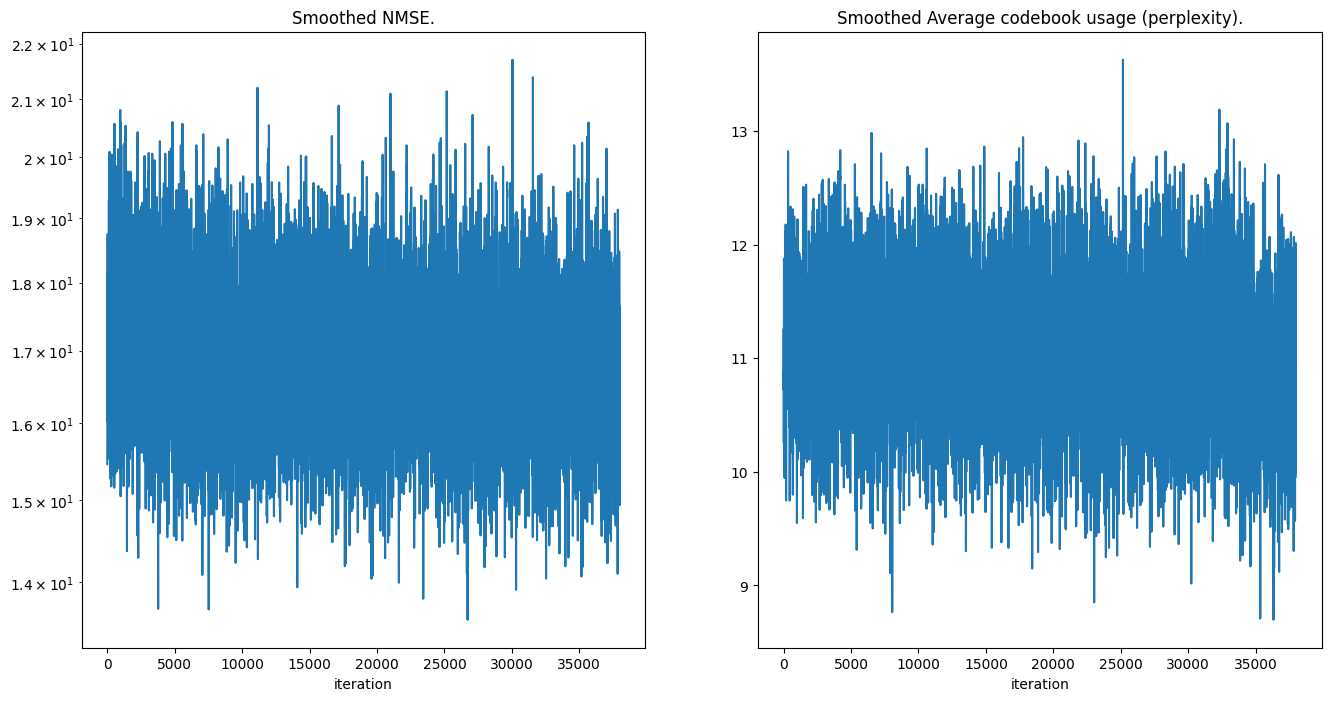

In [39]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')